In [ ]:
eta = 0.1
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 8
n_center = 8
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations= 10       # num mirror steps (for the frist and second)
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100

outer_lr_final_factor = 1e0
outer_eta_final_factor = 1e0
import math
outer_lr_factor = pow(math.e, math.log(outer_lr_final_factor)/n_max_mirror_iterations)
outer_eta_factor = pow(math.e, math.log(outer_eta_final_factor)/n_max_mirror_iterations)

In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=99543e11fb7c9b2ffc165efc9264fc2fd7ed899f7fc67f933a5fbc2db8d4bf71
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


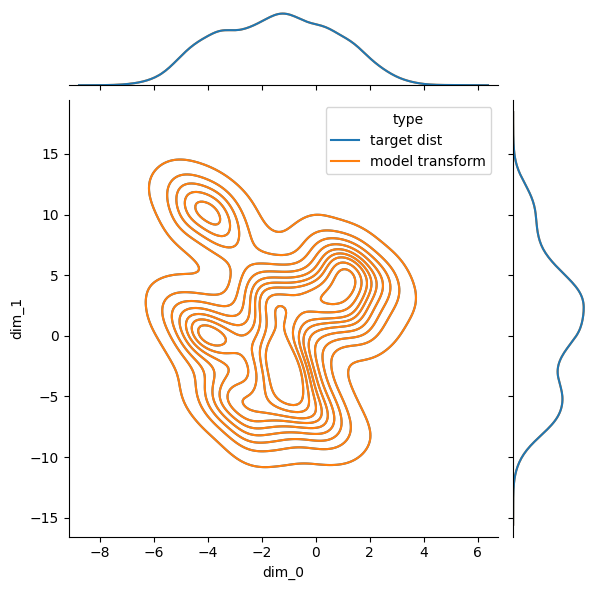

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])



trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:10<00:00,  9.50it/s]

Loss: 25.21908950805664


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


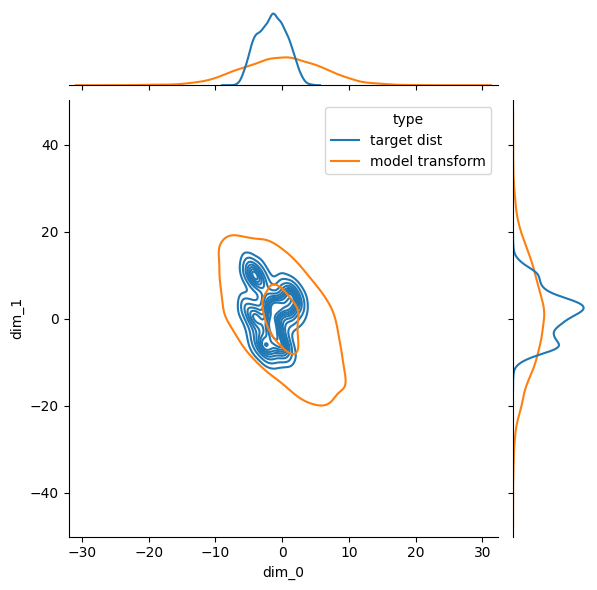

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:30<33:07,  2.97it/s]

trail: 0 m step: 0 Loss: 50.80150604248047  L_n: 36.089134216308594  kld: 1.4712371826171875 KLD1: 35.844383239746094 KLD2: 7.426036357879639


  3%|▎         | 200/6000 [01:01<33:41,  2.87it/s]

trail: 0 m step: 0 Loss: 48.816646575927734  L_n: 33.06625747680664  kld: 1.5750389099121094 KLD1: 33.1881103515625 KLD2: 7.228579521179199


  5%|▌         | 300/6000 [01:32<32:20,  2.94it/s]

trail: 0 m step: 0 Loss: 47.85380935668945  L_n: 31.295028686523438  kld: 1.6558780670166016 KLD1: 31.612892150878906 KLD2: 7.03522253036499


  7%|▋         | 400/6000 [02:03<31:58,  2.92it/s]

trail: 0 m step: 0 Loss: 47.27764892578125  L_n: 30.380123138427734  kld: 1.6897525787353516 KLD1: 30.633743286132812 KLD2: 6.884456634521484


  8%|▊         | 500/6000 [02:34<31:27,  2.91it/s]

trail: 0 m step: 0 Loss: 47.14323043823242  L_n: 29.901981353759766  kld: 1.7241249084472656 KLD1: 29.729217529296875 KLD2: 6.692509174346924


 10%|█         | 600/6000 [03:05<30:51,  2.92it/s]

trail: 0 m step: 0 Loss: 46.42755317687988  L_n: 28.840272903442383  kld: 1.75872802734375 KLD1: 28.914867401123047 KLD2: 6.600520133972168


 12%|█▏        | 700/6000 [03:36<30:17,  2.92it/s]

trail: 0 m step: 0 Loss: 46.017709732055664  L_n: 27.71647071838379  kld: 1.8301239013671875 KLD1: 27.654930114746094 KLD2: 6.447295665740967


 13%|█▎        | 800/6000 [04:07<29:49,  2.91it/s]

trail: 0 m step: 0 Loss: 45.287071228027344  L_n: 26.97696304321289  kld: 1.8310108184814453 KLD1: 27.359954833984375 KLD2: 6.349607467651367


 15%|█▌        | 900/6000 [04:38<29:10,  2.91it/s]

trail: 0 m step: 0 Loss: 45.11691665649414  L_n: 26.49060821533203  kld: 1.862630844116211 KLD1: 26.63387107849121 KLD2: 6.277683734893799


 17%|█▋        | 1000/6000 [05:09<28:42,  2.90it/s]

trail: 0 m step: 0 Loss: 45.108028411865234  L_n: 26.559120178222656  kld: 1.8548908233642578 KLD1: 26.46771812438965 KLD2: 6.247074604034424


 18%|█▊        | 1100/6000 [05:40<28:10,  2.90it/s]

trail: 0 m step: 0 Loss: 44.858726501464844  L_n: 26.029800415039062  kld: 1.8828926086425781 KLD1: 25.85550308227539 KLD2: 6.138820171356201


 20%|██        | 1200/6000 [06:11<27:31,  2.91it/s]

trail: 0 m step: 0 Loss: 44.787485122680664  L_n: 25.865766525268555  kld: 1.892171859741211 KLD1: 25.491512298583984 KLD2: 6.075598239898682


 22%|██▏       | 1300/6000 [06:42<26:56,  2.91it/s]

trail: 0 m step: 0 Loss: 44.189239501953125  L_n: 25.30633544921875  kld: 1.8882904052734375 KLD1: 25.21854591369629 KLD2: 6.049647331237793


 23%|██▎       | 1400/6000 [07:13<26:26,  2.90it/s]

trail: 0 m step: 0 Loss: 44.09894943237305  L_n: 25.271530151367188  kld: 1.882741928100586 KLD1: 25.273714065551758 KLD2: 5.9917073249816895


 25%|██▌       | 1500/6000 [07:44<25:51,  2.90it/s]

trail: 0 m step: 0 Loss: 43.89910125732422  L_n: 24.883255004882812  kld: 1.9015846252441406 KLD1: 24.932071685791016 KLD2: 5.957448959350586


 27%|██▋       | 1600/6000 [08:16<25:18,  2.90it/s]

trail: 0 m step: 0 Loss: 43.92668914794922  L_n: 24.794170379638672  kld: 1.9132518768310547 KLD1: 24.744964599609375 KLD2: 5.924753665924072


 28%|██▊       | 1700/6000 [08:47<24:39,  2.91it/s]

trail: 0 m step: 0 Loss: 43.45879554748535  L_n: 24.43730354309082  kld: 1.9021492004394531 KLD1: 24.56789207458496 KLD2: 5.884487152099609


 30%|███       | 1800/6000 [09:18<24:03,  2.91it/s]

trail: 0 m step: 0 Loss: 43.3715763092041  L_n: 24.163908004760742  kld: 1.920766830444336 KLD1: 24.341676712036133 KLD2: 5.90889310836792


 32%|███▏      | 1900/6000 [09:49<23:32,  2.90it/s]

trail: 0 m step: 0 Loss: 43.45555114746094  L_n: 24.345596313476562  kld: 1.9109954833984375 KLD1: 24.34178924560547 KLD2: 5.856017112731934


 33%|███▎      | 2000/6000 [10:20<22:54,  2.91it/s]

trail: 0 m step: 0 Loss: 43.37700843811035  L_n: 24.34391975402832  kld: 1.9033088684082031 KLD1: 24.40243148803711 KLD2: 5.813483715057373


 35%|███▌      | 2100/6000 [10:51<22:22,  2.91it/s]

trail: 0 m step: 0 Loss: 43.307273864746094  L_n: 24.132125854492188  kld: 1.9175148010253906 KLD1: 24.088356018066406 KLD2: 5.816742897033691


 37%|███▋      | 2200/6000 [11:22<21:45,  2.91it/s]

trail: 0 m step: 0 Loss: 43.435089111328125  L_n: 24.056427001953125  kld: 1.9378662109375 KLD1: 23.89695930480957 KLD2: 5.805395603179932


 38%|███▊      | 2300/6000 [11:53<21:14,  2.90it/s]

trail: 0 m step: 0 Loss: 43.04813766479492  L_n: 23.990100860595703  kld: 1.9058036804199219 KLD1: 24.321636199951172 KLD2: 5.749900817871094


 40%|████      | 2400/6000 [12:24<20:36,  2.91it/s]

trail: 0 m step: 0 Loss: 43.21120262145996  L_n: 23.724088668823242  kld: 1.9487113952636719 KLD1: 23.829708099365234 KLD2: 5.768009662628174


 42%|████▏     | 2500/6000 [12:55<20:02,  2.91it/s]

trail: 0 m step: 0 Loss: 43.34123229980469  L_n: 23.70467758178711  kld: 1.9636554718017578 KLD1: 23.636383056640625 KLD2: 5.7661967277526855


 43%|████▎     | 2600/6000 [13:26<19:27,  2.91it/s]

trail: 0 m step: 0 Loss: 43.32635498046875  L_n: 23.992706298828125  kld: 1.9333648681640625 KLD1: 23.914426803588867 KLD2: 5.732705116271973


 45%|████▌     | 2700/6000 [13:57<18:54,  2.91it/s]

trail: 0 m step: 0 Loss: 42.904380798339844  L_n: 23.62564468383789  kld: 1.9278736114501953 KLD1: 23.957921981811523 KLD2: 5.722888946533203


 47%|████▋     | 2800/6000 [14:28<18:21,  2.90it/s]

trail: 0 m step: 0 Loss: 43.44349670410156  L_n: 24.000499725341797  kld: 1.9442996978759766 KLD1: 23.712133407592773 KLD2: 5.737827777862549


 48%|████▊     | 2900/6000 [14:59<17:45,  2.91it/s]

trail: 0 m step: 0 Loss: 42.9716739654541  L_n: 23.637605667114258  kld: 1.9334068298339844 KLD1: 23.80622673034668 KLD2: 5.71772575378418


 50%|█████     | 3000/6000 [15:30<17:10,  2.91it/s]

trail: 0 m step: 0 Loss: 43.32790565490723  L_n: 23.947050094604492  kld: 1.9380855560302734 KLD1: 23.766454696655273 KLD2: 5.721317291259766


 52%|█████▏    | 3100/6000 [16:02<16:37,  2.91it/s]

trail: 0 m step: 0 Loss: 43.33892059326172  L_n: 23.890316009521484  kld: 1.9448604583740234 KLD1: 23.678356170654297 KLD2: 5.732391357421875


 53%|█████▎    | 3200/6000 [16:33<16:04,  2.90it/s]

trail: 0 m step: 0 Loss: 43.209768295288086  L_n: 23.886877059936523  kld: 1.9322891235351562 KLD1: 23.78874969482422 KLD2: 5.704950332641602


 55%|█████▌    | 3300/6000 [17:04<15:29,  2.91it/s]

trail: 0 m step: 0 Loss: 43.09030532836914  L_n: 23.616371154785156  kld: 1.9473934173583984 KLD1: 23.5308837890625 KLD2: 5.672799110412598


 57%|█████▋    | 3400/6000 [17:35<14:56,  2.90it/s]

trail: 0 m step: 0 Loss: 42.907114028930664  L_n: 23.642187118530273  kld: 1.926492691040039 KLD1: 23.856468200683594 KLD2: 5.680893421173096


 58%|█████▊    | 3500/6000 [18:06<14:19,  2.91it/s]

trail: 0 m step: 0 Loss: 42.944570541381836  L_n: 23.44856834411621  kld: 1.9496002197265625 KLD1: 23.508943557739258 KLD2: 5.654706954956055


 60%|██████    | 3600/6000 [18:37<13:46,  2.90it/s]

trail: 0 m step: 0 Loss: 43.31400108337402  L_n: 23.621217727661133  kld: 1.969278335571289 KLD1: 23.349695205688477 KLD2: 5.642198085784912


 62%|██████▏   | 3700/6000 [19:08<13:11,  2.91it/s]

trail: 0 m step: 0 Loss: 43.157880783081055  L_n: 23.619211196899414  kld: 1.953866958618164 KLD1: 23.431846618652344 KLD2: 5.647327423095703


 63%|██████▎   | 3800/6000 [19:39<12:37,  2.91it/s]

trail: 0 m step: 0 Loss: 43.28437423706055  L_n: 23.50762939453125  kld: 1.9776744842529297 KLD1: 23.228792190551758 KLD2: 5.650548934936523


 65%|██████▌   | 3900/6000 [20:10<12:03,  2.90it/s]

trail: 0 m step: 0 Loss: 43.13363265991211  L_n: 23.6497802734375  kld: 1.948385238647461 KLD1: 23.48845863342285 KLD2: 5.632437229156494


 67%|██████▋   | 4000/6000 [20:41<11:29,  2.90it/s]

trail: 0 m step: 0 Loss: 42.938926696777344  L_n: 23.487518310546875  kld: 1.9451408386230469 KLD1: 23.61037254333496 KLD2: 5.618541240692139


 68%|██████▊   | 4100/6000 [21:12<10:54,  2.90it/s]

trail: 0 m step: 0 Loss: 42.827444076538086  L_n: 23.35963249206543  kld: 1.9467811584472656 KLD1: 23.452556610107422 KLD2: 5.614426612854004


 70%|███████   | 4200/6000 [21:44<10:21,  2.89it/s]

trail: 0 m step: 0 Loss: 43.05262565612793  L_n: 23.481569290161133  kld: 1.9571056365966797 KLD1: 23.357528686523438 KLD2: 5.608536243438721


 72%|███████▏  | 4300/6000 [22:15<09:45,  2.90it/s]

trail: 0 m step: 0 Loss: 43.04400062561035  L_n: 23.62415885925293  kld: 1.9419841766357422 KLD1: 23.41656494140625 KLD2: 5.6525068283081055


 73%|███████▎  | 4400/6000 [22:46<09:10,  2.91it/s]

trail: 0 m step: 0 Loss: 43.303226470947266  L_n: 23.65801239013672  kld: 1.9645214080810547 KLD1: 23.312305450439453 KLD2: 5.648070335388184


 75%|███████▌  | 4500/6000 [23:17<08:35,  2.91it/s]

trail: 0 m step: 0 Loss: 42.46166229248047  L_n: 23.241004943847656  kld: 1.9220657348632812 KLD1: 23.653671264648438 KLD2: 5.626287460327148


 77%|███████▋  | 4600/6000 [23:48<08:02,  2.90it/s]

trail: 0 m step: 0 Loss: 42.86715126037598  L_n: 23.29292869567871  kld: 1.9574222564697266 KLD1: 23.311447143554688 KLD2: 5.627026081085205


 78%|███████▊  | 4700/6000 [24:19<07:26,  2.91it/s]

trail: 0 m step: 0 Loss: 42.67397689819336  L_n: 23.457477569580078  kld: 1.9216499328613281 KLD1: 23.67557716369629 KLD2: 5.626353740692139


 80%|████████  | 4800/6000 [24:50<06:51,  2.92it/s]

trail: 0 m step: 0 Loss: 42.657691955566406  L_n: 23.142349243164062  kld: 1.9515342712402344 KLD1: 23.389272689819336 KLD2: 5.620372772216797


 82%|████████▏ | 4900/6000 [25:21<06:19,  2.90it/s]

trail: 0 m step: 0 Loss: 42.71702575683594  L_n: 23.380783081054688  kld: 1.933624267578125 KLD1: 23.5456600189209 KLD2: 5.5953192710876465


 83%|████████▎ | 5000/6000 [25:52<05:44,  2.90it/s]

trail: 0 m step: 0 Loss: 43.07302665710449  L_n: 23.57862663269043  kld: 1.9494400024414062 KLD1: 23.400510787963867 KLD2: 5.6121416091918945


 85%|████████▌ | 5100/6000 [26:23<05:10,  2.90it/s]

trail: 0 m step: 0 Loss: 43.35704803466797  L_n: 23.64826202392578  kld: 1.9708786010742188 KLD1: 23.14488410949707 KLD2: 5.582239151000977


 87%|████████▋ | 5200/6000 [26:54<04:35,  2.91it/s]

trail: 0 m step: 0 Loss: 42.86480140686035  L_n: 23.33795738220215  kld: 1.9526844024658203 KLD1: 23.375347137451172 KLD2: 5.640207767486572


 88%|████████▊ | 5300/6000 [27:26<04:01,  2.90it/s]

trail: 0 m step: 0 Loss: 42.84387016296387  L_n: 23.346590042114258  kld: 1.949728012084961 KLD1: 23.425182342529297 KLD2: 5.586324691772461


 90%|█████████ | 5400/6000 [27:57<03:27,  2.90it/s]

trail: 0 m step: 0 Loss: 42.70150375366211  L_n: 23.087608337402344  kld: 1.9613895416259766 KLD1: 23.258459091186523 KLD2: 5.572220325469971


 92%|█████████▏| 5500/6000 [28:28<02:52,  2.90it/s]

trail: 0 m step: 0 Loss: 42.89175987243652  L_n: 23.477487564086914  kld: 1.941427230834961 KLD1: 23.45009994506836 KLD2: 5.594341278076172


 93%|█████████▎| 5600/6000 [28:59<02:17,  2.90it/s]

trail: 0 m step: 0 Loss: 42.756425857543945  L_n: 23.094999313354492  kld: 1.9661426544189453 KLD1: 23.129886627197266 KLD2: 5.569952487945557


 95%|█████████▌| 5700/6000 [29:30<01:43,  2.89it/s]

trail: 0 m step: 0 Loss: 42.8083610534668  L_n: 23.184337615966797  kld: 1.96240234375 KLD1: 23.26817512512207 KLD2: 5.593989849090576


 97%|█████████▋| 5800/6000 [30:01<01:08,  2.90it/s]

trail: 0 m step: 0 Loss: 42.984819412231445  L_n: 23.29594612121582  kld: 1.9688873291015625 KLD1: 23.194499969482422 KLD2: 5.581437587738037


 98%|█████████▊| 5900/6000 [30:33<00:34,  2.89it/s]

trail: 0 m step: 0 Loss: 42.82541465759277  L_n: 23.24558448791504  kld: 1.9579830169677734 KLD1: 23.227182388305664 KLD2: 5.5720062255859375


100%|██████████| 6000/6000 [31:04<00:00,  3.22it/s]

trail: 0 m step: 0 Loss: 42.848833084106445  L_n: 23.337629318237305  kld: 1.951120376586914 KLD1: 23.428348541259766 KLD2: 5.566260814666748



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


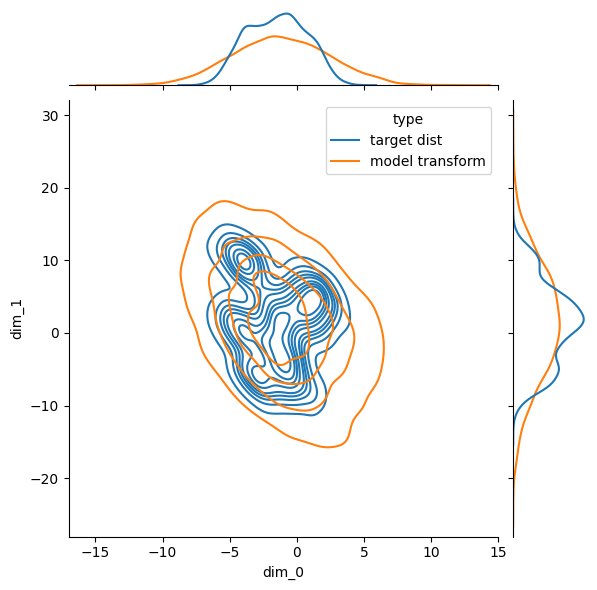

trail: 0 m step: 0 kl_test: 23.422340393066406


  2%|▏         | 100/6000 [00:31<34:16,  2.87it/s]

trail: 0 m step: 1 Loss: 17.594228744506836  L_n: 14.015108108520508  kld: 0.3579120635986328 KLD1: 13.966638565063477 KLD2: 4.279898166656494


  3%|▎         | 200/6000 [01:02<33:17,  2.90it/s]

trail: 0 m step: 1 Loss: 17.085430145263672  L_n: 13.258506774902344  kld: 0.3826923370361328 KLD1: 13.400070190429688 KLD2: 4.188621997833252


  5%|▌         | 300/6000 [01:33<32:47,  2.90it/s]

trail: 0 m step: 1 Loss: 16.987821578979492  L_n: 12.991621017456055  kld: 0.39962005615234375 KLD1: 13.089537620544434 KLD2: 4.109567642211914


  7%|▋         | 400/6000 [02:05<32:21,  2.88it/s]

trail: 0 m step: 1 Loss: 16.847366333007812  L_n: 12.786735534667969  kld: 0.4060630798339844 KLD1: 12.946077346801758 KLD2: 4.061458110809326


  8%|▊         | 500/6000 [02:36<31:46,  2.88it/s]

trail: 0 m step: 1 Loss: 16.9940128326416  L_n: 12.849992752075195  kld: 0.4144020080566406 KLD1: 12.816554069519043 KLD2: 3.9601311683654785


 10%|█         | 600/6000 [03:07<31:01,  2.90it/s]

trail: 0 m step: 1 Loss: 16.832075119018555  L_n: 12.725763320922852  kld: 0.4106311798095703 KLD1: 12.854959487915039 KLD2: 3.985135078430176


 12%|█▏        | 700/6000 [03:38<30:35,  2.89it/s]

trail: 0 m step: 1 Loss: 16.95330810546875  L_n: 12.466346740722656  kld: 0.4486961364746094 KLD1: 12.374974250793457 KLD2: 3.901402711868286


 13%|█▎        | 800/6000 [04:10<29:59,  2.89it/s]

trail: 0 m step: 1 Loss: 16.68445587158203  L_n: 12.401390075683594  kld: 0.42830657958984375 KLD1: 12.50277042388916 KLD2: 3.88507342338562


 15%|█▌        | 900/6000 [04:41<29:19,  2.90it/s]

trail: 0 m step: 1 Loss: 16.832386016845703  L_n: 12.39413833618164  kld: 0.44382476806640625 KLD1: 12.372797966003418 KLD2: 3.874171018600464


 17%|█▋        | 1000/6000 [05:12<28:40,  2.91it/s]

trail: 0 m step: 1 Loss: 16.713930130004883  L_n: 12.326112747192383  kld: 0.43878173828125 KLD1: 12.406590461730957 KLD2: 3.885237455368042


 18%|█▊        | 1100/6000 [05:43<28:17,  2.89it/s]

trail: 0 m step: 1 Loss: 16.820335388183594  L_n: 12.36989974975586  kld: 0.44504356384277344 KLD1: 12.245807647705078 KLD2: 3.8395748138427734


 20%|██        | 1200/6000 [06:14<27:38,  2.89it/s]

trail: 0 m step: 1 Loss: 17.00064468383789  L_n: 12.504356384277344  kld: 0.4496288299560547 KLD1: 12.145106315612793 KLD2: 3.813856601715088


 22%|██▏       | 1300/6000 [06:46<27:07,  2.89it/s]

trail: 0 m step: 1 Loss: 16.723339080810547  L_n: 12.231399536132812  kld: 0.44919395446777344 KLD1: 12.1265869140625 KLD2: 3.8256475925445557


 23%|██▎       | 1400/6000 [07:17<26:33,  2.89it/s]

trail: 0 m step: 1 Loss: 16.651052474975586  L_n: 12.292036056518555  kld: 0.4359016418457031 KLD1: 12.350068092346191 KLD2: 3.7951459884643555


 25%|██▌       | 1500/6000 [07:48<26:03,  2.88it/s]

trail: 0 m step: 1 Loss: 16.59971809387207  L_n: 12.155252456665039  kld: 0.4444465637207031 KLD1: 12.235249519348145 KLD2: 3.7968788146972656


 27%|██▋       | 1600/6000 [08:20<25:24,  2.89it/s]

trail: 0 m step: 1 Loss: 16.740724563598633  L_n: 12.314455032348633  kld: 0.442626953125 KLD1: 12.233070373535156 KLD2: 3.7897350788116455


 28%|██▊       | 1700/6000 [08:51<24:49,  2.89it/s]

trail: 0 m step: 1 Loss: 16.479869842529297  L_n: 12.061267852783203  kld: 0.4418601989746094 KLD1: 12.162075996398926 KLD2: 3.777406930923462


 30%|███       | 1800/6000 [09:22<24:15,  2.89it/s]

trail: 0 m step: 1 Loss: 16.41490364074707  L_n: 11.957620620727539  kld: 0.4457283020019531 KLD1: 12.171390533447266 KLD2: 3.810760736465454


 32%|███▏      | 1900/6000 [09:53<23:42,  2.88it/s]

trail: 0 m step: 1 Loss: 16.607330322265625  L_n: 12.17226791381836  kld: 0.44350624084472656 KLD1: 12.08931827545166 KLD2: 3.7904577255249023


 33%|███▎      | 2000/6000 [10:25<23:07,  2.88it/s]

trail: 0 m step: 1 Loss: 16.431758880615234  L_n: 11.95132064819336  kld: 0.4480438232421875 KLD1: 12.030583381652832 KLD2: 3.73978590965271


 35%|███▌      | 2100/6000 [10:56<22:31,  2.89it/s]

trail: 0 m step: 1 Loss: 16.52800750732422  L_n: 12.010757446289062  kld: 0.4517250061035156 KLD1: 12.001021385192871 KLD2: 3.7683475017547607


 37%|███▋      | 2200/6000 [11:27<21:54,  2.89it/s]

trail: 0 m step: 1 Loss: 16.54288101196289  L_n: 12.012126922607422  kld: 0.4530754089355469 KLD1: 12.003192901611328 KLD2: 3.7738006114959717


 38%|███▊      | 2300/6000 [11:59<21:19,  2.89it/s]

trail: 0 m step: 1 Loss: 16.367900848388672  L_n: 11.918609619140625  kld: 0.4449291229248047 KLD1: 12.087126731872559 KLD2: 3.722210168838501


 40%|████      | 2400/6000 [12:30<20:48,  2.88it/s]

trail: 0 m step: 1 Loss: 16.525829315185547  L_n: 11.883609771728516  kld: 0.4642219543457031 KLD1: 11.871415138244629 KLD2: 3.7609150409698486


 42%|████▏     | 2500/6000 [13:01<20:11,  2.89it/s]

trail: 0 m step: 1 Loss: 16.55748176574707  L_n: 11.860578536987305  kld: 0.46969032287597656 KLD1: 11.803671836853027 KLD2: 3.7608513832092285


 43%|████▎     | 2600/6000 [13:33<19:39,  2.88it/s]

trail: 0 m step: 1 Loss: 16.585742950439453  L_n: 12.057506561279297  kld: 0.4528236389160156 KLD1: 11.959877967834473 KLD2: 3.7372829914093018


 45%|████▌     | 2700/6000 [14:04<19:02,  2.89it/s]

trail: 0 m step: 1 Loss: 16.386375427246094  L_n: 11.85272216796875  kld: 0.4533653259277344 KLD1: 11.958343505859375 KLD2: 3.728877305984497


 47%|████▋     | 2800/6000 [14:35<18:24,  2.90it/s]

trail: 0 m step: 1 Loss: 16.649049758911133  L_n: 12.031034469604492  kld: 0.46180152893066406 KLD1: 11.832512855529785 KLD2: 3.7470808029174805


 48%|████▊     | 2900/6000 [15:06<17:51,  2.89it/s]

trail: 0 m step: 1 Loss: 16.33043670654297  L_n: 11.779579162597656  kld: 0.45508575439453125 KLD1: 11.891072273254395 KLD2: 3.7353522777557373


 50%|█████     | 3000/6000 [15:38<17:19,  2.89it/s]

trail: 0 m step: 1 Loss: 16.540027618408203  L_n: 11.959529876708984  kld: 0.4580497741699219 KLD1: 11.872347831726074 KLD2: 3.7522623538970947


 52%|█████▏    | 3100/6000 [16:09<16:45,  2.89it/s]

trail: 0 m step: 1 Loss: 16.577665328979492  L_n: 11.947309494018555  kld: 0.46303558349609375 KLD1: 11.840241432189941 KLD2: 3.756971836090088


 53%|█████▎    | 3200/6000 [16:40<16:08,  2.89it/s]

trail: 0 m step: 1 Loss: 16.553783416748047  L_n: 12.002735137939453  kld: 0.4551048278808594 KLD1: 11.863673210144043 KLD2: 3.736792802810669


 55%|█████▌    | 3300/6000 [17:11<15:32,  2.89it/s]

trail: 0 m step: 1 Loss: 16.463520050048828  L_n: 11.890117645263672  kld: 0.4573402404785156 KLD1: 11.844745635986328 KLD2: 3.7301177978515625


 57%|█████▋    | 3400/6000 [17:43<14:58,  2.89it/s]

trail: 0 m step: 1 Loss: 16.408470153808594  L_n: 11.914623260498047  kld: 0.4493846893310547 KLD1: 11.974095344543457 KLD2: 3.734074115753174


 58%|█████▊    | 3500/6000 [18:14<14:25,  2.89it/s]

trail: 0 m step: 1 Loss: 16.44712257385254  L_n: 11.767213821411133  kld: 0.4679908752441406 KLD1: 11.778947830200195 KLD2: 3.7107646465301514


 60%|██████    | 3600/6000 [18:45<13:48,  2.90it/s]

trail: 0 m step: 1 Loss: 16.61930274963379  L_n: 11.94114875793457  kld: 0.4678153991699219 KLD1: 11.76518726348877 KLD2: 3.7142491340637207


 62%|██████▏   | 3700/6000 [19:16<13:13,  2.90it/s]

trail: 0 m step: 1 Loss: 16.570274353027344  L_n: 11.914302825927734  kld: 0.46559715270996094 KLD1: 11.750431060791016 KLD2: 3.720877170562744


 63%|██████▎   | 3800/6000 [19:48<12:40,  2.89it/s]

trail: 0 m step: 1 Loss: 16.585243225097656  L_n: 11.838672637939453  kld: 0.4746570587158203 KLD1: 11.718534469604492 KLD2: 3.7377355098724365


 65%|██████▌   | 3900/6000 [20:19<12:06,  2.89it/s]

trail: 0 m step: 1 Loss: 16.42366600036621  L_n: 11.81593132019043  kld: 0.4607734680175781 KLD1: 11.808215141296387 KLD2: 3.7215898036956787


 67%|██████▋   | 4000/6000 [20:50<11:33,  2.88it/s]

trail: 0 m step: 1 Loss: 16.391315460205078  L_n: 11.808223724365234  kld: 0.4583091735839844 KLD1: 11.874028205871582 KLD2: 3.712303400039673


 68%|██████▊   | 4100/6000 [21:21<10:57,  2.89it/s]

trail: 0 m step: 1 Loss: 16.36705207824707  L_n: 11.744096755981445  kld: 0.4622955322265625 KLD1: 11.831608772277832 KLD2: 3.706500768661499


 70%|███████   | 4200/6000 [21:53<10:22,  2.89it/s]

trail: 0 m step: 1 Loss: 16.524272918701172  L_n: 11.87533950805664  kld: 0.4648933410644531 KLD1: 11.783332824707031 KLD2: 3.7101240158081055


 72%|███████▏  | 4300/6000 [22:24<09:49,  2.88it/s]

trail: 0 m step: 1 Loss: 16.46580696105957  L_n: 11.861848831176758  kld: 0.46039581298828125 KLD1: 11.745964050292969 KLD2: 3.7420451641082764


 73%|███████▎  | 4400/6000 [22:55<09:13,  2.89it/s]

trail: 0 m step: 1 Loss: 16.63702392578125  L_n: 11.929821014404297  kld: 0.4707202911376953 KLD1: 11.691679954528809 KLD2: 3.7458226680755615


 75%|███████▌  | 4500/6000 [23:27<08:40,  2.88it/s]

trail: 0 m step: 1 Loss: 16.060941696166992  L_n: 11.598737716674805  kld: 0.44622039794921875 KLD1: 11.888047218322754 KLD2: 3.7247207164764404


 77%|███████▋  | 4600/6000 [23:58<08:04,  2.89it/s]

trail: 0 m step: 1 Loss: 16.383459091186523  L_n: 11.766874313354492  kld: 0.4616584777832031 KLD1: 11.767545700073242 KLD2: 3.740169048309326


 78%|███████▊  | 4700/6000 [24:29<07:30,  2.88it/s]

trail: 0 m step: 1 Loss: 16.271181106567383  L_n: 11.799325942993164  kld: 0.4471855163574219 KLD1: 11.94218921661377 KLD2: 3.732886552810669


 80%|████████  | 4800/6000 [25:01<06:56,  2.88it/s]

trail: 0 m step: 1 Loss: 16.256011962890625  L_n: 11.642192840576172  kld: 0.4613819122314453 KLD1: 11.782998085021973 KLD2: 3.73374605178833


 82%|████████▏ | 4900/6000 [25:32<06:20,  2.89it/s]

trail: 0 m step: 1 Loss: 16.291812896728516  L_n: 11.783012390136719  kld: 0.4508800506591797 KLD1: 11.857185363769531 KLD2: 3.7100753784179688


 83%|████████▎ | 5000/6000 [26:03<05:45,  2.89it/s]

trail: 0 m step: 1 Loss: 16.542064666748047  L_n: 11.919757843017578  kld: 0.4622306823730469 KLD1: 11.780673027038574 KLD2: 3.728671073913574


 85%|████████▌ | 5100/6000 [26:34<05:10,  2.90it/s]

trail: 0 m step: 1 Loss: 16.70673370361328  L_n: 11.963005065917969  kld: 0.47437286376953125 KLD1: 11.643566131591797 KLD2: 3.7052249908447266


 87%|████████▋ | 5200/6000 [27:06<04:37,  2.88it/s]

trail: 0 m step: 1 Loss: 16.334369659423828  L_n: 11.742046356201172  kld: 0.4592323303222656 KLD1: 11.799668312072754 KLD2: 3.7613730430603027


 88%|████████▊ | 5300/6000 [27:37<04:02,  2.89it/s]

trail: 0 m step: 1 Loss: 16.242979049682617  L_n: 11.632478713989258  kld: 0.46105003356933594 KLD1: 11.832883834838867 KLD2: 3.7083487510681152


 90%|█████████ | 5400/6000 [28:08<03:27,  2.89it/s]

trail: 0 m step: 1 Loss: 16.282644271850586  L_n: 11.602983474731445  kld: 0.46796607971191406 KLD1: 11.715468406677246 KLD2: 3.7017006874084473


 92%|█████████▏| 5500/6000 [28:39<02:53,  2.88it/s]

trail: 0 m step: 1 Loss: 16.35786247253418  L_n: 11.77421760559082  kld: 0.45836448669433594 KLD1: 11.8448486328125 KLD2: 3.720690965652466


 93%|█████████▎| 5600/6000 [29:11<02:18,  2.89it/s]

trail: 0 m step: 1 Loss: 16.350448608398438  L_n: 11.640880584716797  kld: 0.47095680236816406 KLD1: 11.653942108154297 KLD2: 3.7067179679870605


 95%|█████████▌| 5700/6000 [29:42<01:43,  2.89it/s]

trail: 0 m step: 1 Loss: 16.31196403503418  L_n: 11.663202285766602  kld: 0.4648761749267578 KLD1: 11.73160457611084 KLD2: 3.7266030311584473


 97%|█████████▋| 5800/6000 [30:13<01:09,  2.89it/s]

trail: 0 m step: 1 Loss: 16.383222579956055  L_n: 11.716588973999023  kld: 0.4666633605957031 KLD1: 11.71810245513916 KLD2: 3.7188186645507812


 98%|█████████▊| 5900/6000 [30:44<00:34,  2.89it/s]

trail: 0 m step: 1 Loss: 16.363525390625  L_n: 11.691226959228516  kld: 0.46722984313964844 KLD1: 11.658047676086426 KLD2: 3.7075693607330322


100%|██████████| 6000/6000 [31:16<00:00,  3.20it/s]

trail: 0 m step: 1 Loss: 16.3520565032959  L_n: 11.75334358215332  kld: 0.4598712921142578 KLD1: 11.776168823242188 KLD2: 3.703094005584717



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


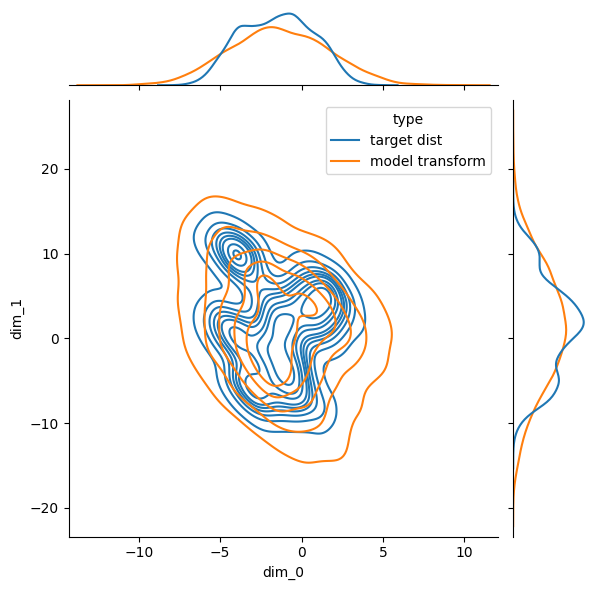

trail: 0 m step: 1 kl_test: 11.803628921508789


  2%|▏         | 100/6000 [00:31<34:23,  2.86it/s]

trail: 0 m step: 2 Loss: 9.495189666748047  L_n: 7.867115020751953  kld: 0.16280746459960938 KLD1: 7.874451160430908 KLD2: 2.9074604511260986


  3%|▎         | 200/6000 [01:02<33:31,  2.88it/s]

trail: 0 m step: 2 Loss: 9.22667121887207  L_n: 7.512174606323242  kld: 0.1714496612548828 KLD1: 7.554080963134766 KLD2: 2.860637664794922


  5%|▌         | 300/6000 [01:34<33:00,  2.88it/s]

trail: 0 m step: 2 Loss: 9.247493743896484  L_n: 7.4859619140625  kld: 0.17615318298339844 KLD1: 7.439431190490723 KLD2: 2.807633876800537


  7%|▋         | 400/6000 [02:05<32:23,  2.88it/s]

trail: 0 m step: 2 Loss: 9.146480560302734  L_n: 7.32025146484375  kld: 0.18262290954589844 KLD1: 7.417518615722656 KLD2: 2.780374765396118


  8%|▊         | 500/6000 [02:36<31:52,  2.88it/s]

trail: 0 m step: 2 Loss: 9.204109191894531  L_n: 7.388942718505859  kld: 0.1815166473388672 KLD1: 7.418395042419434 KLD2: 2.7200233936309814


 10%|█         | 600/6000 [03:08<31:18,  2.87it/s]

trail: 0 m step: 2 Loss: 9.101045608520508  L_n: 7.266939163208008  kld: 0.18341064453125 KLD1: 7.4411702156066895 KLD2: 2.7485666275024414


 12%|█▏        | 700/6000 [03:39<30:41,  2.88it/s]

trail: 0 m step: 2 Loss: 9.240234375  L_n: 7.199104309082031  kld: 0.20411300659179688 KLD1: 7.10728120803833 KLD2: 2.7057740688323975


 13%|█▎        | 800/6000 [04:11<30:08,  2.87it/s]

trail: 0 m step: 2 Loss: 9.124612808227539  L_n: 7.229986190795898  kld: 0.18946266174316406 KLD1: 7.22280740737915 KLD2: 2.6994214057922363


 15%|█▌        | 900/6000 [04:42<29:32,  2.88it/s]

trail: 0 m step: 2 Loss: 9.109027862548828  L_n: 7.1313934326171875  kld: 0.19776344299316406 KLD1: 7.185462951660156 KLD2: 2.701749086380005


 17%|█▋        | 1000/6000 [05:13<29:00,  2.87it/s]

trail: 0 m step: 2 Loss: 9.062314987182617  L_n: 7.171121597290039  kld: 0.1891193389892578 KLD1: 7.280970096588135 KLD2: 2.7321043014526367


 18%|█▊        | 1100/6000 [05:45<28:27,  2.87it/s]

trail: 0 m step: 2 Loss: 9.220542907714844  L_n: 7.229099273681641  kld: 0.1991443634033203 KLD1: 7.116179466247559 KLD2: 2.6987197399139404


 20%|██        | 1200/6000 [06:16<27:50,  2.87it/s]

trail: 0 m step: 2 Loss: 9.279869079589844  L_n: 7.26055908203125  kld: 0.20193099975585938 KLD1: 7.086865425109863 KLD2: 2.6760332584381104


 22%|██▏       | 1300/6000 [06:48<27:11,  2.88it/s]

trail: 0 m step: 2 Loss: 9.196584701538086  L_n: 7.179811477661133  kld: 0.2016773223876953 KLD1: 7.046111583709717 KLD2: 2.691526412963867


 23%|██▎       | 1400/6000 [07:19<26:39,  2.88it/s]

trail: 0 m step: 2 Loss: 9.05693244934082  L_n: 7.089807510375977  kld: 0.19671249389648438 KLD1: 7.16832971572876 KLD2: 2.650409460067749


 25%|██▌       | 1500/6000 [07:50<26:04,  2.88it/s]

trail: 0 m step: 2 Loss: 9.03292465209961  L_n: 7.064311981201172  kld: 0.19686126708984375 KLD1: 7.1471452713012695 KLD2: 2.6658315658569336


 27%|██▋       | 1600/6000 [08:22<25:30,  2.87it/s]

trail: 0 m step: 2 Loss: 9.154495239257812  L_n: 7.144283294677734  kld: 0.2010211944580078 KLD1: 7.039896488189697 KLD2: 2.6537890434265137


 28%|██▊       | 1700/6000 [08:53<24:56,  2.87it/s]

trail: 0 m step: 2 Loss: 9.007564544677734  L_n: 7.039981842041016  kld: 0.19675827026367188 KLD1: 7.120368480682373 KLD2: 2.6586945056915283


 30%|███       | 1800/6000 [09:25<24:16,  2.88it/s]

trail: 0 m step: 2 Loss: 8.961935043334961  L_n: 7.002344131469727  kld: 0.19595909118652344 KLD1: 7.095244407653809 KLD2: 2.692136287689209


 32%|███▏      | 1900/6000 [09:56<23:46,  2.87it/s]

trail: 0 m step: 2 Loss: 9.139518737792969  L_n: 7.179203033447266  kld: 0.1960315704345703 KLD1: 7.09816837310791 KLD2: 2.685905694961548


 33%|███▎      | 2000/6000 [10:27<23:05,  2.89it/s]

trail: 0 m step: 2 Loss: 9.012731552124023  L_n: 7.080110549926758  kld: 0.19326210021972656 KLD1: 7.0990800857543945 KLD2: 2.6569669246673584


 35%|███▌      | 2100/6000 [10:59<22:32,  2.88it/s]

trail: 0 m step: 2 Loss: 9.023101806640625  L_n: 7.030265808105469  kld: 0.19928359985351562 KLD1: 7.055660724639893 KLD2: 2.6660916805267334


 37%|███▋      | 2200/6000 [11:30<21:59,  2.88it/s]

trail: 0 m step: 2 Loss: 9.005544662475586  L_n: 7.012460708618164  kld: 0.1993083953857422 KLD1: 7.070321083068848 KLD2: 2.6725003719329834


 38%|███▊      | 2300/6000 [12:01<21:25,  2.88it/s]

trail: 0 m step: 2 Loss: 8.905899047851562  L_n: 6.980525970458984  kld: 0.1925373077392578 KLD1: 7.120709419250488 KLD2: 2.627159595489502


 40%|████      | 2400/6000 [12:33<20:51,  2.88it/s]

trail: 0 m step: 2 Loss: 9.009943008422852  L_n: 6.948003768920898  kld: 0.2061939239501953 KLD1: 6.9814605712890625 KLD2: 2.6667356491088867


 42%|████▏     | 2500/6000 [13:04<20:16,  2.88it/s]

trail: 0 m step: 2 Loss: 9.122089385986328  L_n: 7.008995056152344  kld: 0.21130943298339844 KLD1: 6.912097454071045 KLD2: 2.6693928241729736


 43%|████▎     | 2600/6000 [13:36<19:45,  2.87it/s]

trail: 0 m step: 2 Loss: 9.0975341796875  L_n: 7.0877227783203125  kld: 0.20098114013671875 KLD1: 7.033257484436035 KLD2: 2.6441402435302734


 45%|████▌     | 2700/6000 [14:07<19:06,  2.88it/s]

trail: 0 m step: 2 Loss: 8.935514450073242  L_n: 6.952157974243164  kld: 0.1983356475830078 KLD1: 7.052120685577393 KLD2: 2.635883331298828


 47%|████▋     | 2800/6000 [14:38<18:34,  2.87it/s]

trail: 0 m step: 2 Loss: 9.112184524536133  L_n: 7.083318710327148  kld: 0.20288658142089844 KLD1: 6.9669413566589355 KLD2: 2.6563549041748047


 48%|████▊     | 2900/6000 [15:10<18:00,  2.87it/s]

trail: 0 m step: 2 Loss: 8.925079345703125  L_n: 6.938251495361328  kld: 0.1986827850341797 KLD1: 7.018377780914307 KLD2: 2.6463630199432373


 50%|█████     | 3000/6000 [15:41<17:26,  2.87it/s]

trail: 0 m step: 2 Loss: 9.05257797241211  L_n: 7.0140228271484375  kld: 0.2038555145263672 KLD1: 6.959444522857666 KLD2: 2.6628408432006836


 52%|█████▏    | 3100/6000 [16:13<16:47,  2.88it/s]

trail: 0 m step: 2 Loss: 9.092741012573242  L_n: 7.06019401550293  kld: 0.20325469970703125 KLD1: 6.983968734741211 KLD2: 2.673339366912842


 53%|█████▎    | 3200/6000 [16:44<16:12,  2.88it/s]

trail: 0 m step: 2 Loss: 9.132312774658203  L_n: 7.117809295654297  kld: 0.20145034790039062 KLD1: 6.999777793884277 KLD2: 2.6508026123046875


 55%|█████▌    | 3300/6000 [17:16<15:39,  2.87it/s]

trail: 0 m step: 2 Loss: 8.970724105834961  L_n: 6.963811874389648  kld: 0.20069122314453125 KLD1: 7.007334232330322 KLD2: 2.6443164348602295


 57%|█████▋    | 3400/6000 [17:47<15:03,  2.88it/s]

trail: 0 m step: 2 Loss: 8.930400848388672  L_n: 6.9813385009765625  kld: 0.19490623474121094 KLD1: 7.099424839019775 KLD2: 2.648766279220581


 58%|█████▊    | 3500/6000 [18:18<14:26,  2.89it/s]

trail: 0 m step: 2 Loss: 9.030048370361328  L_n: 6.929924011230469  kld: 0.21001243591308594 KLD1: 6.932933330535889 KLD2: 2.6271984577178955


 60%|██████    | 3600/6000 [18:50<13:53,  2.88it/s]

trail: 0 m step: 2 Loss: 9.112569808959961  L_n: 7.015439987182617  kld: 0.20971298217773438 KLD1: 6.92978048324585 KLD2: 2.632009506225586


 62%|██████▏   | 3700/6000 [19:21<13:18,  2.88it/s]

trail: 0 m step: 2 Loss: 9.096786499023438  L_n: 7.005130767822266  kld: 0.2091655731201172 KLD1: 6.897134304046631 KLD2: 2.6400234699249268


 63%|██████▎   | 3800/6000 [19:52<12:43,  2.88it/s]

trail: 0 m step: 2 Loss: 9.067968368530273  L_n: 6.958269119262695  kld: 0.2109699249267578 KLD1: 6.903100490570068 KLD2: 2.6582281589508057


 65%|██████▌   | 3900/6000 [20:24<12:08,  2.88it/s]

trail: 0 m step: 2 Loss: 9.005216598510742  L_n: 6.981729507446289  kld: 0.2023487091064453 KLD1: 6.979729652404785 KLD2: 2.643188953399658


 67%|██████▋   | 4000/6000 [20:55<11:31,  2.89it/s]

trail: 0 m step: 2 Loss: 8.92672348022461  L_n: 6.879299163818359  kld: 0.204742431640625 KLD1: 6.940134048461914 KLD2: 2.6321828365325928


 68%|██████▊   | 4100/6000 [21:26<10:59,  2.88it/s]

trail: 0 m step: 2 Loss: 8.978145599365234  L_n: 6.936634063720703  kld: 0.20415115356445312 KLD1: 6.928774833679199 KLD2: 2.6309006214141846


 70%|███████   | 4200/6000 [21:58<10:23,  2.88it/s]

trail: 0 m step: 2 Loss: 9.054252624511719  L_n: 7.015277862548828  kld: 0.20389747619628906 KLD1: 6.947330951690674 KLD2: 2.63677716255188


 72%|███████▏  | 4300/6000 [22:29<09:50,  2.88it/s]

trail: 0 m step: 2 Loss: 9.016597747802734  L_n: 6.999500274658203  kld: 0.20170974731445312 KLD1: 6.924813747406006 KLD2: 2.6621527671813965


 73%|███████▎  | 4400/6000 [23:00<09:15,  2.88it/s]

trail: 0 m step: 2 Loss: 9.18000602722168  L_n: 7.063173294067383  kld: 0.2116832733154297 KLD1: 6.874974727630615 KLD2: 2.669201135635376


 75%|███████▌  | 4500/6000 [23:32<08:41,  2.88it/s]

trail: 0 m step: 2 Loss: 8.74970817565918  L_n: 6.797479629516602  kld: 0.1952228546142578 KLD1: 7.039241790771484 KLD2: 2.6447839736938477


 77%|███████▋  | 4600/6000 [24:03<08:05,  2.88it/s]

trail: 0 m step: 2 Loss: 9.028297424316406  L_n: 6.954418182373047  kld: 0.20738792419433594 KLD1: 6.927198886871338 KLD2: 2.6653168201446533


 78%|███████▊  | 4700/6000 [24:34<07:31,  2.88it/s]

trail: 0 m step: 2 Loss: 8.861953735351562  L_n: 6.936122894287109  kld: 0.1925830841064453 KLD1: 7.091114521026611 KLD2: 2.6588401794433594


 80%|████████  | 4800/6000 [25:06<06:55,  2.89it/s]

trail: 0 m step: 2 Loss: 8.908340454101562  L_n: 6.880580902099609  kld: 0.2027759552001953 KLD1: 6.969573497772217 KLD2: 2.660935401916504


 82%|████████▏ | 4900/6000 [25:37<06:21,  2.88it/s]

trail: 0 m step: 2 Loss: 8.942422866821289  L_n: 6.959524154663086  kld: 0.1982898712158203 KLD1: 7.01135778427124 KLD2: 2.636375904083252


 83%|████████▎ | 5000/6000 [26:08<05:47,  2.88it/s]

trail: 0 m step: 2 Loss: 9.116544723510742  L_n: 7.065057754516602  kld: 0.20514869689941406 KLD1: 6.9420599937438965 KLD2: 2.6539924144744873


 85%|████████▌ | 5100/6000 [26:40<05:13,  2.87it/s]

trail: 0 m step: 2 Loss: 9.196840286254883  L_n: 7.090536117553711  kld: 0.2106304168701172 KLD1: 6.8835344314575195 KLD2: 2.638486862182617


 87%|████████▋ | 5200/6000 [27:11<04:38,  2.88it/s]

trail: 0 m step: 2 Loss: 8.93421745300293  L_n: 6.890512466430664  kld: 0.20437049865722656 KLD1: 6.970998287200928 KLD2: 2.687201499938965


 88%|████████▊ | 5300/6000 [27:43<04:04,  2.87it/s]

trail: 0 m step: 2 Loss: 8.84146499633789  L_n: 6.8320159912109375  kld: 0.2009449005126953 KLD1: 7.033664703369141 KLD2: 2.6409409046173096


 90%|█████████ | 5400/6000 [28:14<03:28,  2.88it/s]

trail: 0 m step: 2 Loss: 8.961942672729492  L_n: 6.886194229125977  kld: 0.20757484436035156 KLD1: 6.926247596740723 KLD2: 2.63539981842041


 92%|█████████▏| 5500/6000 [28:45<02:53,  2.88it/s]

trail: 0 m step: 2 Loss: 8.972034454345703  L_n: 6.972675323486328  kld: 0.1999359130859375 KLD1: 6.999535083770752 KLD2: 2.6473441123962402


 93%|█████████▎| 5600/6000 [29:17<02:18,  2.89it/s]

trail: 0 m step: 2 Loss: 8.967338562011719  L_n: 6.913181304931641  kld: 0.2054157257080078 KLD1: 6.911617755889893 KLD2: 2.6398072242736816


 95%|█████████▌| 5700/6000 [29:48<01:44,  2.87it/s]

trail: 0 m step: 2 Loss: 8.928594589233398  L_n: 6.875295639038086  kld: 0.20532989501953125 KLD1: 6.906841278076172 KLD2: 2.65285587310791


 97%|█████████▋| 5800/6000 [30:19<01:09,  2.87it/s]

trail: 0 m step: 2 Loss: 8.950119018554688  L_n: 6.912345886230469  kld: 0.20377731323242188 KLD1: 6.95906400680542 KLD2: 2.650115966796875


 98%|█████████▊| 5900/6000 [30:51<00:34,  2.88it/s]

trail: 0 m step: 2 Loss: 8.96197509765625  L_n: 6.890251159667969  kld: 0.20717239379882812 KLD1: 6.889467239379883 KLD2: 2.6372287273406982


100%|██████████| 6000/6000 [31:22<00:00,  3.19it/s]

trail: 0 m step: 2 Loss: 8.980283737182617  L_n: 6.95134162902832  kld: 0.2028942108154297 KLD1: 6.919982433319092 KLD2: 2.633683204650879



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


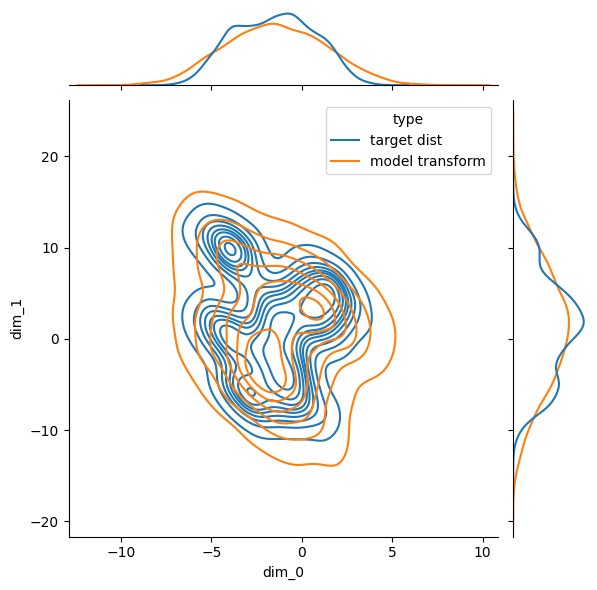

trail: 0 m step: 2 kl_test: 7.024566650390625


  2%|▏         | 100/6000 [00:31<34:24,  2.86it/s]

trail: 0 m step: 3 Loss: 5.788318634033203  L_n: 4.895164489746094  kld: 0.08931541442871094 KLD1: 4.90159797668457 KLD2: 2.0853445529937744


  3%|▎         | 200/6000 [01:02<33:32,  2.88it/s]

trail: 0 m step: 3 Loss: 5.640758514404297  L_n: 4.751476287841797  kld: 0.08892822265625 KLD1: 4.775368690490723 KLD2: 2.0806870460510254


  5%|▌         | 300/6000 [01:34<32:57,  2.88it/s]

trail: 0 m step: 3 Loss: 5.679939270019531  L_n: 4.714344024658203  kld: 0.09655952453613281 KLD1: 4.699718475341797 KLD2: 2.03505277633667


  7%|▋         | 400/6000 [02:05<32:24,  2.88it/s]

trail: 0 m step: 3 Loss: 5.618955612182617  L_n: 4.654867172241211  kld: 0.09640884399414062 KLD1: 4.721023082733154 KLD2: 2.0341522693634033


  8%|▊         | 500/6000 [02:37<31:51,  2.88it/s]

trail: 0 m step: 3 Loss: 5.625734329223633  L_n: 4.679536819458008  kld: 0.0946197509765625 KLD1: 4.68341064453125 KLD2: 1.9896061420440674


 10%|█         | 600/6000 [03:08<31:11,  2.89it/s]

trail: 0 m step: 3 Loss: 5.6085968017578125  L_n: 4.651947021484375  kld: 0.09566497802734375 KLD1: 4.710209369659424 KLD2: 2.0165042877197266


 12%|█▏        | 700/6000 [03:39<30:33,  2.89it/s]

trail: 0 m step: 3 Loss: 5.698263168334961  L_n: 4.605714797973633  kld: 0.10925483703613281 KLD1: 4.505431175231934 KLD2: 1.9919140338897705


 13%|█▎        | 800/6000 [04:10<29:58,  2.89it/s]

trail: 0 m step: 3 Loss: 5.6265411376953125  L_n: 4.611660003662109  kld: 0.10148811340332031 KLD1: 4.607653617858887 KLD2: 1.9845077991485596


 15%|█▌        | 900/6000 [04:42<29:26,  2.89it/s]

trail: 0 m step: 3 Loss: 5.581230163574219  L_n: 4.514678955078125  kld: 0.10665512084960938 KLD1: 4.581595420837402 KLD2: 1.987898826599121


 17%|█▋        | 1000/6000 [05:13<28:54,  2.88it/s]

trail: 0 m step: 3 Loss: 5.564949035644531  L_n: 4.583827972412109  kld: 0.09811210632324219 KLD1: 4.674169540405273 KLD2: 2.01357364654541


 18%|█▊        | 1100/6000 [05:44<28:23,  2.88it/s]

trail: 0 m step: 3 Loss: 5.693359375  L_n: 4.628009796142578  kld: 0.10653495788574219 KLD1: 4.565612316131592 KLD2: 1.987077236175537


 20%|██        | 1200/6000 [06:16<27:48,  2.88it/s]

trail: 0 m step: 3 Loss: 5.733732223510742  L_n: 4.638895034790039  kld: 0.10948371887207031 KLD1: 4.5196614265441895 KLD2: 1.9718223810195923


 22%|██▏       | 1300/6000 [06:47<27:07,  2.89it/s]

trail: 0 m step: 3 Loss: 5.686183929443359  L_n: 4.6214447021484375  kld: 0.10647392272949219 KLD1: 4.5288801193237305 KLD2: 1.986419439315796


 23%|██▎       | 1400/6000 [07:18<26:32,  2.89it/s]

trail: 0 m step: 3 Loss: 5.587247848510742  L_n: 4.540399551391602  kld: 0.10468482971191406 KLD1: 4.5748419761657715 KLD2: 1.949800729751587


 25%|██▌       | 1500/6000 [07:50<26:07,  2.87it/s]

trail: 0 m step: 3 Loss: 5.558815002441406  L_n: 4.528312683105469  kld: 0.10305023193359375 KLD1: 4.621636390686035 KLD2: 1.9694650173187256


 27%|██▋       | 1600/6000 [08:21<25:25,  2.88it/s]

trail: 0 m step: 3 Loss: 5.668970108032227  L_n: 4.576993942260742  kld: 0.10919761657714844 KLD1: 4.494946002960205 KLD2: 1.956304669380188


 28%|██▊       | 1700/6000 [08:53<24:51,  2.88it/s]

trail: 0 m step: 3 Loss: 5.538516998291016  L_n: 4.462734222412109  kld: 0.10757827758789062 KLD1: 4.546624183654785 KLD2: 1.9517784118652344


 30%|███       | 1800/6000 [09:24<24:16,  2.88it/s]

trail: 0 m step: 3 Loss: 5.541717529296875  L_n: 4.482776641845703  kld: 0.10589408874511719 KLD1: 4.53671932220459 KLD2: 1.9935823678970337


 32%|███▏      | 1900/6000 [09:55<23:45,  2.88it/s]

trail: 0 m step: 3 Loss: 5.634950637817383  L_n: 4.575723648071289  kld: 0.10592269897460938 KLD1: 4.548067092895508 KLD2: 1.9813896417617798


 33%|███▎      | 2000/6000 [10:27<23:06,  2.88it/s]

trail: 0 m step: 3 Loss: 5.567728042602539  L_n: 4.568868637084961  kld: 0.09988594055175781 KLD1: 4.558257102966309 KLD2: 1.9639571905136108


 35%|███▌      | 2100/6000 [10:58<22:39,  2.87it/s]

trail: 0 m step: 3 Loss: 5.560064315795898  L_n: 4.505434036254883  kld: 0.10546302795410156 KLD1: 4.534353733062744 KLD2: 1.9694093465805054


 37%|███▋      | 2200/6000 [11:30<21:56,  2.89it/s]

trail: 0 m step: 3 Loss: 5.53886604309082  L_n: 4.489042282104492  kld: 0.10498237609863281 KLD1: 4.536929607391357 KLD2: 1.9770578145980835


 38%|███▊      | 2300/6000 [12:01<21:28,  2.87it/s]

trail: 0 m step: 3 Loss: 5.487329483032227  L_n: 4.471742630004883  kld: 0.10155868530273438 KLD1: 4.561746120452881 KLD2: 1.9311569929122925


 40%|████      | 2400/6000 [12:32<20:51,  2.88it/s]

trail: 0 m step: 3 Loss: 5.528053283691406  L_n: 4.411243438720703  kld: 0.11168098449707031 KLD1: 4.476917743682861 KLD2: 1.9717975854873657


 42%|████▏     | 2500/6000 [13:04<20:15,  2.88it/s]

trail: 0 m step: 3 Loss: 5.6607818603515625  L_n: 4.512653350830078  kld: 0.11481285095214844 KLD1: 4.414695739746094 KLD2: 1.9731100797653198


 43%|████▎     | 2600/6000 [13:35<19:41,  2.88it/s]

trail: 0 m step: 3 Loss: 5.605403900146484  L_n: 4.545967102050781  kld: 0.10594367980957031 KLD1: 4.520625114440918 KLD2: 1.9505983591079712


 45%|████▌     | 2700/6000 [14:06<19:06,  2.88it/s]

trail: 0 m step: 3 Loss: 5.500665664672852  L_n: 4.463373184204102  kld: 0.103729248046875 KLD1: 4.53133487701416 KLD2: 1.9451954364776611


 47%|████▋     | 2800/6000 [14:38<18:32,  2.88it/s]

trail: 0 m step: 3 Loss: 5.613988876342773  L_n: 4.542097091674805  kld: 0.10718917846679688 KLD1: 4.4855451583862305 KLD2: 1.9613429307937622


 48%|████▊     | 2900/6000 [15:09<17:58,  2.87it/s]

trail: 0 m step: 3 Loss: 5.524284362792969  L_n: 4.478084564208984  kld: 0.10461997985839844 KLD1: 4.5084452629089355 KLD2: 1.9547593593597412


 50%|█████     | 3000/6000 [15:41<17:21,  2.88it/s]

trail: 0 m step: 3 Loss: 5.588579177856445  L_n: 4.503622055053711  kld: 0.10849571228027344 KLD1: 4.473299980163574 KLD2: 1.967288851737976


 52%|█████▏    | 3100/6000 [16:12<16:51,  2.87it/s]

trail: 0 m step: 3 Loss: 5.613264083862305  L_n: 4.554380416870117  kld: 0.10588836669921875 KLD1: 4.498831272125244 KLD2: 1.9847363233566284


 53%|█████▎    | 3200/6000 [16:43<16:13,  2.88it/s]

trail: 0 m step: 3 Loss: 5.642732620239258  L_n: 4.588350296020508  kld: 0.105438232421875 KLD1: 4.527683258056641 KLD2: 1.9591577053070068


 55%|█████▌    | 3300/6000 [17:15<15:39,  2.87it/s]

trail: 0 m step: 3 Loss: 5.514850616455078  L_n: 4.452934265136719  kld: 0.10619163513183594 KLD1: 4.485380172729492 KLD2: 1.9516397714614868


 57%|█████▋    | 3400/6000 [17:46<15:06,  2.87it/s]

trail: 0 m step: 3 Loss: 5.46905517578125  L_n: 4.461021423339844  kld: 0.10080337524414062 KLD1: 4.585258483886719 KLD2: 1.959350347518921


 58%|█████▊    | 3500/6000 [18:18<14:30,  2.87it/s]

trail: 0 m step: 3 Loss: 5.579355239868164  L_n: 4.447134017944336  kld: 0.11322212219238281 KLD1: 4.462299823760986 KLD2: 1.9387651681900024


 60%|██████    | 3600/6000 [18:49<13:56,  2.87it/s]

trail: 0 m step: 3 Loss: 5.6234283447265625  L_n: 4.488212585449219  kld: 0.11352157592773438 KLD1: 4.4445295333862305 KLD2: 1.941888451576233


 62%|██████▏   | 3700/6000 [19:21<13:20,  2.87it/s]

trail: 0 m step: 3 Loss: 5.618949890136719  L_n: 4.502159118652344  kld: 0.1116790771484375 KLD1: 4.47360372543335 KLD2: 1.9543265104293823


 63%|██████▎   | 3800/6000 [19:52<12:44,  2.88it/s]

trail: 0 m step: 3 Loss: 5.598054885864258  L_n: 4.481931686401367  kld: 0.11161231994628906 KLD1: 4.434655666351318 KLD2: 1.9711315631866455


 65%|██████▌   | 3900/6000 [20:23<12:07,  2.88it/s]

trail: 0 m step: 3 Loss: 5.565788269042969  L_n: 4.494106292724609  kld: 0.10716819763183594 KLD1: 4.535282611846924 KLD2: 1.9573601484298706


 67%|██████▋   | 4000/6000 [20:55<11:32,  2.89it/s]

trail: 0 m step: 3 Loss: 5.503480911254883  L_n: 4.413393020629883  kld: 0.1090087890625 KLD1: 4.445995807647705 KLD2: 1.9484370946884155


 68%|██████▊   | 4100/6000 [21:26<10:59,  2.88it/s]

trail: 0 m step: 3 Loss: 5.5745849609375  L_n: 4.492012023925781  kld: 0.10825729370117188 KLD1: 4.451603889465332 KLD2: 1.9426597356796265


 70%|███████   | 4200/6000 [21:57<10:24,  2.88it/s]

trail: 0 m step: 3 Loss: 5.563926696777344  L_n: 4.497585296630859  kld: 0.10663414001464844 KLD1: 4.497259140014648 KLD2: 1.9502228498458862


 72%|███████▏  | 4300/6000 [22:29<09:50,  2.88it/s]

trail: 0 m step: 3 Loss: 5.530473709106445  L_n: 4.477560043334961  kld: 0.10529136657714844 KLD1: 4.475898265838623 KLD2: 1.9729913473129272


 73%|███████▎  | 4400/6000 [23:00<09:16,  2.88it/s]

trail: 0 m step: 3 Loss: 5.65863037109375  L_n: 4.535316467285156  kld: 0.11233139038085938 KLD1: 4.420479774475098 KLD2: 1.980168342590332


 75%|███████▌  | 4500/6000 [23:32<08:40,  2.88it/s]

trail: 0 m step: 3 Loss: 5.324213027954102  L_n: 4.325887680053711  kld: 0.09983253479003906 KLD1: 4.5588059425354 KLD2: 1.956790566444397


 77%|███████▋  | 4600/6000 [24:03<08:06,  2.88it/s]

trail: 0 m step: 3 Loss: 5.541313171386719  L_n: 4.442222595214844  kld: 0.1099090576171875 KLD1: 4.4415740966796875 KLD2: 1.976731538772583


 78%|███████▊  | 4700/6000 [24:34<07:31,  2.88it/s]

trail: 0 m step: 3 Loss: 5.463857650756836  L_n: 4.466581344604492  kld: 0.09972763061523438 KLD1: 4.5780134201049805 KLD2: 1.9711464643478394


 80%|████████  | 4800/6000 [25:06<06:57,  2.87it/s]

trail: 0 m step: 3 Loss: 5.477375030517578  L_n: 4.408287048339844  kld: 0.10690879821777344 KLD1: 4.489394187927246 KLD2: 1.9739896059036255


 82%|████████▏ | 4900/6000 [25:37<06:21,  2.88it/s]

trail: 0 m step: 3 Loss: 5.507474899291992  L_n: 4.47996711730957  kld: 0.10275077819824219 KLD1: 4.516176700592041 KLD2: 1.952030062675476


 83%|████████▎ | 5000/6000 [26:09<05:46,  2.88it/s]

trail: 0 m step: 3 Loss: 5.618358612060547  L_n: 4.537712097167969  kld: 0.10806465148925781 KLD1: 4.469481945037842 KLD2: 1.967694878578186


 85%|████████▌ | 5100/6000 [26:40<05:12,  2.88it/s]

trail: 0 m step: 3 Loss: 5.72212028503418  L_n: 4.601343154907227  kld: 0.11207771301269531 KLD1: 4.440253734588623 KLD2: 1.9582085609436035


 87%|████████▋ | 5200/6000 [27:11<04:37,  2.88it/s]

trail: 0 m step: 3 Loss: 5.531589508056641  L_n: 4.447624206542969  kld: 0.10839653015136719 KLD1: 4.479641437530518 KLD2: 2.000004768371582


 88%|████████▊ | 5300/6000 [27:43<04:03,  2.87it/s]

trail: 0 m step: 3 Loss: 5.42755126953125  L_n: 4.381771087646484  kld: 0.10457801818847656 KLD1: 4.539318084716797 KLD2: 1.9558143615722656


 90%|█████████ | 5400/6000 [28:14<03:28,  2.88it/s]

trail: 0 m step: 3 Loss: 5.55108642578125  L_n: 4.442630767822266  kld: 0.11084556579589844 KLD1: 4.450045585632324 KLD2: 1.9483575820922852


 92%|█████████▏| 5500/6000 [28:46<02:53,  2.88it/s]

trail: 0 m step: 3 Loss: 5.5523681640625  L_n: 4.510917663574219  kld: 0.10414505004882812 KLD1: 4.540996074676514 KLD2: 1.959792971611023


 93%|█████████▎| 5600/6000 [29:17<02:19,  2.88it/s]

trail: 0 m step: 3 Loss: 5.523567199707031  L_n: 4.449424743652344  kld: 0.10741424560546875 KLD1: 4.462627410888672 KLD2: 1.9536620378494263


 95%|█████████▌| 5700/6000 [29:48<01:44,  2.88it/s]

trail: 0 m step: 3 Loss: 5.501415252685547  L_n: 4.406482696533203  kld: 0.10949325561523438 KLD1: 4.444092750549316 KLD2: 1.9651002883911133


 97%|█████████▋| 5800/6000 [30:20<01:09,  2.87it/s]

trail: 0 m step: 3 Loss: 5.503320693969727  L_n: 4.444913864135742  kld: 0.10584068298339844 KLD1: 4.484580039978027 KLD2: 1.964190125465393


 98%|█████████▊| 5900/6000 [30:51<00:34,  2.87it/s]

trail: 0 m step: 3 Loss: 5.557554244995117  L_n: 4.460142135620117  kld: 0.1097412109375 KLD1: 4.435705184936523 KLD2: 1.9507427215576172


100%|██████████| 6000/6000 [31:22<00:00,  3.19it/s]

trail: 0 m step: 3 Loss: 5.575933456420898  L_n: 4.493074417114258  kld: 0.10828590393066406 KLD1: 4.454253673553467 KLD2: 1.9454829692840576



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


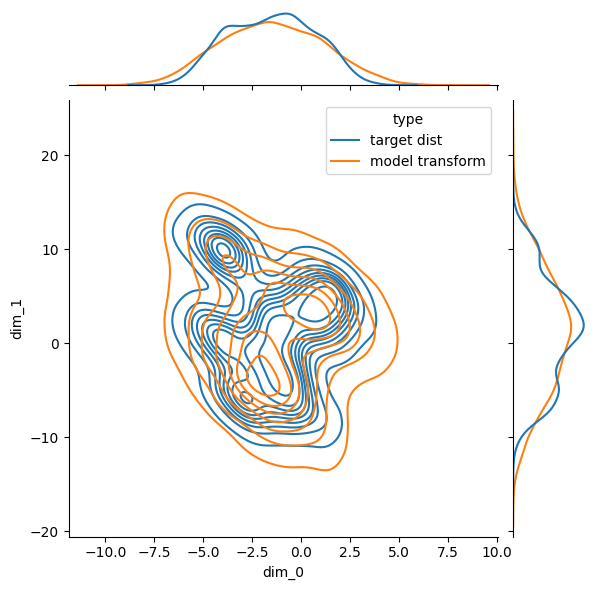

trail: 0 m step: 3 kl_test: 4.529273986816406


  2%|▏         | 100/6000 [00:31<34:14,  2.87it/s]

trail: 0 m step: 4 Loss: 3.830677032470703  L_n: 3.302417755126953  kld: 0.052825927734375 KLD1: 3.2839889526367188 KLD2: 1.563062310218811


  3%|▎         | 200/6000 [01:02<33:28,  2.89it/s]

trail: 0 m step: 4 Loss: 3.75872802734375  L_n: 3.242389678955078  kld: 0.05163383483886719 KLD1: 3.2534754276275635 KLD2: 1.5747560262680054


  5%|▌         | 300/6000 [01:34<32:53,  2.89it/s]

trail: 0 m step: 4 Loss: 3.742015838623047  L_n: 3.157794952392578  kld: 0.058422088623046875 KLD1: 3.1698548793792725 KLD2: 1.536329746246338


  7%|▋         | 400/6000 [02:05<32:25,  2.88it/s]

trail: 0 m step: 4 Loss: 3.714031219482422  L_n: 3.1585922241210938  kld: 0.05554389953613281 KLD1: 3.2083542346954346 KLD2: 1.5396015644073486


  8%|▊         | 500/6000 [02:37<31:59,  2.87it/s]

trail: 0 m step: 4 Loss: 3.7010574340820312  L_n: 3.161144256591797  kld: 0.05399131774902344 KLD1: 3.236778974533081 KLD2: 1.5063810348510742


 10%|█         | 600/6000 [03:08<31:19,  2.87it/s]

trail: 0 m step: 4 Loss: 3.706512451171875  L_n: 3.158721923828125  kld: 0.054779052734375 KLD1: 3.180384635925293 KLD2: 1.5257248878479004


 12%|█▏        | 700/6000 [03:39<30:39,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7709426879882812  L_n: 3.1083106994628906  kld: 0.06626319885253906 KLD1: 3.0917699337005615 KLD2: 1.5077075958251953


 13%|█▎        | 800/6000 [04:11<30:04,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7432479858398438  L_n: 3.140697479248047  kld: 0.06025505065917969 KLD1: 3.140453577041626 KLD2: 1.5036582946777344


 15%|█▌        | 900/6000 [04:42<29:29,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6996631622314453  L_n: 3.067777633666992  kld: 0.06318855285644531 KLD1: 3.1354355812072754 KLD2: 1.5073037147521973


 17%|█▋        | 1000/6000 [05:14<28:52,  2.89it/s]

trail: 0 m step: 4 Loss: 3.7078781127929688  L_n: 3.1439132690429688  kld: 0.056396484375 KLD1: 3.1743295192718506 KLD2: 1.5333738327026367


 18%|█▊        | 1100/6000 [05:45<28:23,  2.88it/s]

trail: 0 m step: 4 Loss: 3.791444778442383  L_n: 3.1561832427978516  kld: 0.06352615356445312 KLD1: 3.1043648719787598 KLD2: 1.5049591064453125


 20%|██        | 1200/6000 [06:16<27:45,  2.88it/s]

trail: 0 m step: 4 Loss: 3.8192672729492188  L_n: 3.160125732421875  kld: 0.06591415405273438 KLD1: 3.084549903869629 KLD2: 1.4941216707229614


 22%|██▏       | 1300/6000 [06:48<27:14,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7521514892578125  L_n: 3.1184158325195312  kld: 0.06337356567382812 KLD1: 3.078965425491333 KLD2: 1.5053997039794922


 23%|██▎       | 1400/6000 [07:19<26:43,  2.87it/s]

trail: 0 m step: 4 Loss: 3.6890830993652344  L_n: 3.067668914794922  kld: 0.06214141845703125 KLD1: 3.110764741897583 KLD2: 1.4759923219680786


 25%|██▌       | 1500/6000 [07:51<26:04,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6819114685058594  L_n: 3.0937042236328125  kld: 0.05882072448730469 KLD1: 3.169196367263794 KLD2: 1.4954235553741455


 27%|██▋       | 1600/6000 [08:22<25:32,  2.87it/s]

trail: 0 m step: 4 Loss: 3.764394760131836  L_n: 3.118356704711914  kld: 0.06460380554199219 KLD1: 3.0583415031433105 KLD2: 1.4853111505508423


 28%|██▊       | 1700/6000 [08:53<24:55,  2.87it/s]

trail: 0 m step: 4 Loss: 3.695211410522461  L_n: 3.0426883697509766  kld: 0.06525230407714844 KLD1: 3.0640811920166016 KLD2: 1.4761598110198975


 30%|███       | 1800/6000 [09:25<24:20,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6756858825683594  L_n: 3.0423126220703125  kld: 0.06333732604980469 KLD1: 3.062656879425049 KLD2: 1.5202194452285767


 32%|███▏      | 1900/6000 [09:56<23:44,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7577476501464844  L_n: 3.10125732421875  kld: 0.06564903259277344 KLD1: 3.0516467094421387 KLD2: 1.502089023590088


 33%|███▎      | 2000/6000 [10:27<23:12,  2.87it/s]

trail: 0 m step: 4 Loss: 3.693632125854492  L_n: 3.1135692596435547  kld: 0.05800628662109375 KLD1: 3.1194374561309814 KLD2: 1.487874984741211


 35%|███▌      | 2100/6000 [10:59<22:33,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6751937866210938  L_n: 3.060455322265625  kld: 0.061473846435546875 KLD1: 3.0691778659820557 KLD2: 1.497122049331665


 37%|███▋      | 2200/6000 [11:30<21:55,  2.89it/s]

trail: 0 m step: 4 Loss: 3.7129898071289062  L_n: 3.0999679565429688  kld: 0.06130218505859375 KLD1: 3.080796718597412 KLD2: 1.5074076652526855


 38%|███▊      | 2300/6000 [12:02<21:20,  2.89it/s]

trail: 0 m step: 4 Loss: 3.6487693786621094  L_n: 3.055927276611328  kld: 0.059284210205078125 KLD1: 3.1007468700408936 KLD2: 1.4602246284484863


 40%|████      | 2400/6000 [12:33<20:47,  2.89it/s]

trail: 0 m step: 4 Loss: 3.665668487548828  L_n: 3.014690399169922  kld: 0.06509780883789062 KLD1: 3.0632662773132324 KLD2: 1.4994077682495117


 42%|████▏     | 2500/6000 [13:04<20:15,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7848129272460938  L_n: 3.1048622131347656  kld: 0.06799507141113281 KLD1: 2.9954323768615723 KLD2: 1.4999622106552124


 43%|████▎     | 2600/6000 [13:36<19:35,  2.89it/s]

trail: 0 m step: 4 Loss: 3.7220630645751953  L_n: 3.115201950073242  kld: 0.06068611145019531 KLD1: 3.095102548599243 KLD2: 1.4802579879760742


 45%|████▌     | 2700/6000 [14:07<19:04,  2.88it/s]

trail: 0 m step: 4 Loss: 3.656892776489258  L_n: 3.0625438690185547  kld: 0.05943489074707031 KLD1: 3.089243173599243 KLD2: 1.4763848781585693


 47%|████▋     | 2800/6000 [14:38<18:28,  2.89it/s]

trail: 0 m step: 4 Loss: 3.7150821685791016  L_n: 3.092866897583008  kld: 0.062221527099609375 KLD1: 3.0690596103668213 KLD2: 1.489270806312561


 48%|████▊     | 2900/6000 [15:10<17:57,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6318492889404297  L_n: 3.037729263305664  kld: 0.05941200256347656 KLD1: 3.117457389831543 KLD2: 1.4818519353866577


 50%|█████     | 3000/6000 [15:41<17:20,  2.88it/s]

trail: 0 m step: 4 Loss: 3.698068618774414  L_n: 3.056760787963867  kld: 0.06413078308105469 KLD1: 3.0387327671051025 KLD2: 1.4944453239440918


 52%|█████▏    | 3100/6000 [16:12<16:48,  2.87it/s]

trail: 0 m step: 4 Loss: 3.6927623748779297  L_n: 3.088380813598633  kld: 0.06043815612792969 KLD1: 3.0900113582611084 KLD2: 1.5146567821502686


 53%|█████▎    | 3200/6000 [16:44<16:10,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7515926361083984  L_n: 3.1293582916259766  kld: 0.06222343444824219 KLD1: 3.0621931552886963 KLD2: 1.4853168725967407


 55%|█████▌    | 3300/6000 [17:15<15:36,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6605377197265625  L_n: 3.042499542236328  kld: 0.06180381774902344 KLD1: 3.039552688598633 KLD2: 1.4817306995391846


 57%|█████▋    | 3400/6000 [17:46<15:02,  2.88it/s]

trail: 0 m step: 4 Loss: 3.629556655883789  L_n: 3.059602737426758  kld: 0.056995391845703125 KLD1: 3.1297972202301025 KLD2: 1.4902528524398804


 58%|█████▊    | 3500/6000 [18:18<14:24,  2.89it/s]

trail: 0 m step: 4 Loss: 3.699960708618164  L_n: 3.033018112182617  kld: 0.06669425964355469 KLD1: 3.04085111618042 KLD2: 1.4695497751235962


 60%|██████    | 3600/6000 [18:49<13:51,  2.88it/s]

trail: 0 m step: 4 Loss: 3.763916015625  L_n: 3.0785675048828125  kld: 0.06853485107421875 KLD1: 2.9926931858062744 KLD2: 1.471567153930664


 62%|██████▏   | 3700/6000 [19:20<13:16,  2.89it/s]

trail: 0 m step: 4 Loss: 3.7290782928466797  L_n: 3.071596145629883  kld: 0.06574821472167969 KLD1: 3.0331671237945557 KLD2: 1.4849894046783447


 63%|██████▎   | 3800/6000 [19:51<12:40,  2.89it/s]

trail: 0 m step: 4 Loss: 3.731142044067383  L_n: 3.071981430053711  kld: 0.06591606140136719 KLD1: 3.0217959880828857 KLD2: 1.4983186721801758


 65%|██████▌   | 3900/6000 [20:23<12:07,  2.89it/s]

trail: 0 m step: 4 Loss: 3.683320999145508  L_n: 3.057004928588867  kld: 0.06263160705566406 KLD1: 3.0898308753967285 KLD2: 1.486429214477539


 67%|██████▋   | 4000/6000 [20:54<11:33,  2.89it/s]

trail: 0 m step: 4 Loss: 3.6653919219970703  L_n: 3.0141849517822266  kld: 0.06512069702148438 KLD1: 3.0356314182281494 KLD2: 1.4767158031463623


 68%|██████▊   | 4100/6000 [21:25<10:58,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7075748443603516  L_n: 3.0821361541748047  kld: 0.06254386901855469 KLD1: 3.0291030406951904 KLD2: 1.471904993057251


 70%|███████   | 4200/6000 [21:57<10:23,  2.89it/s]

trail: 0 m step: 4 Loss: 3.6936283111572266  L_n: 3.074922561645508  kld: 0.061870574951171875 KLD1: 3.0766193866729736 KLD2: 1.4801298379898071


 72%|███████▏  | 4300/6000 [22:28<09:47,  2.90it/s]

trail: 0 m step: 4 Loss: 3.689706802368164  L_n: 3.0699710845947266  kld: 0.06197357177734375 KLD1: 3.034343719482422 KLD2: 1.500752329826355


 73%|███████▎  | 4400/6000 [22:59<09:14,  2.89it/s]

trail: 0 m step: 4 Loss: 3.7895736694335938  L_n: 3.1259117126464844  kld: 0.06636619567871094 KLD1: 3.029116630554199 KLD2: 1.50886070728302


 75%|███████▌  | 4500/6000 [23:31<08:40,  2.88it/s]

trail: 0 m step: 4 Loss: 3.5112571716308594  L_n: 2.9391860961914062  kld: 0.05720710754394531 KLD1: 3.112488269805908 KLD2: 1.4869577884674072


 77%|███████▋  | 4600/6000 [24:02<08:05,  2.88it/s]

trail: 0 m step: 4 Loss: 3.681438446044922  L_n: 3.0300979614257812  kld: 0.06513404846191406 KLD1: 3.0206103324890137 KLD2: 1.5043048858642578


 78%|███████▊  | 4700/6000 [24:33<07:29,  2.89it/s]

trail: 0 m step: 4 Loss: 3.6609745025634766  L_n: 3.097715377807617  kld: 0.05632591247558594 KLD1: 3.138967990875244 KLD2: 1.500453233718872


 80%|████████  | 4800/6000 [25:05<06:56,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6126937866210938  L_n: 2.991718292236328  kld: 0.06209754943847656 KLD1: 3.066523313522339 KLD2: 1.5032142400741577


 82%|████████▏ | 4900/6000 [25:36<06:22,  2.88it/s]

trail: 0 m step: 4 Loss: 3.675966262817383  L_n: 3.0837154388427734  kld: 0.05922508239746094 KLD1: 3.0898654460906982 KLD2: 1.4829965829849243


 83%|████████▎ | 5000/6000 [26:07<05:47,  2.88it/s]

trail: 0 m step: 4 Loss: 3.7290897369384766  L_n: 3.1013622283935547  kld: 0.06277275085449219 KLD1: 3.0357666015625 KLD2: 1.4973998069763184


 85%|████████▌ | 5100/6000 [26:39<05:12,  2.88it/s]

trail: 0 m step: 4 Loss: 3.8059120178222656  L_n: 3.149250030517578  kld: 0.06566619873046875 KLD1: 3.044121026992798 KLD2: 1.4916077852249146


 87%|████████▋ | 5200/6000 [27:10<04:36,  2.89it/s]

trail: 0 m step: 4 Loss: 3.655435562133789  L_n: 3.0244083404541016  kld: 0.06310272216796875 KLD1: 3.0468943119049072 KLD2: 1.5285407304763794


 88%|████████▊ | 5300/6000 [27:41<04:03,  2.88it/s]

trail: 0 m step: 4 Loss: 3.5757923126220703  L_n: 2.9852962493896484  kld: 0.05904960632324219 KLD1: 3.1025311946868896 KLD2: 1.4857995510101318


 90%|█████████ | 5400/6000 [28:13<03:27,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6834850311279297  L_n: 3.022684097290039  kld: 0.06608009338378906 KLD1: 3.0296683311462402 KLD2: 1.4780004024505615


 92%|█████████▏| 5500/6000 [28:44<02:53,  2.89it/s]

trail: 0 m step: 4 Loss: 3.701810836791992  L_n: 3.1006336212158203  kld: 0.06011772155761719 KLD1: 3.0955755710601807 KLD2: 1.4903249740600586


 93%|█████████▎| 5600/6000 [29:15<02:18,  2.89it/s]

trail: 0 m step: 4 Loss: 3.644186019897461  L_n: 3.031393051147461  kld: 0.061279296875 KLD1: 3.0603187084198 KLD2: 1.485232949256897


 95%|█████████▌| 5700/6000 [29:47<01:43,  2.89it/s]

trail: 0 m step: 4 Loss: 3.638582229614258  L_n: 2.9976367950439453  kld: 0.06409454345703125 KLD1: 3.034280776977539 KLD2: 1.4942375421524048


 97%|█████████▋| 5800/6000 [30:18<01:09,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6386871337890625  L_n: 3.0258750915527344  kld: 0.06128120422363281 KLD1: 3.0632779598236084 KLD2: 1.4929466247558594


 98%|█████████▊| 5900/6000 [30:49<00:34,  2.88it/s]

trail: 0 m step: 4 Loss: 3.6502456665039062  L_n: 3.021831512451172  kld: 0.06284141540527344 KLD1: 3.0355803966522217 KLD2: 1.4829542636871338


100%|██████████| 6000/6000 [31:21<00:00,  3.19it/s]

trail: 0 m step: 4 Loss: 3.7104930877685547  L_n: 3.0699291229248047  kld: 0.064056396484375 KLD1: 3.0279250144958496 KLD2: 1.4763078689575195



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


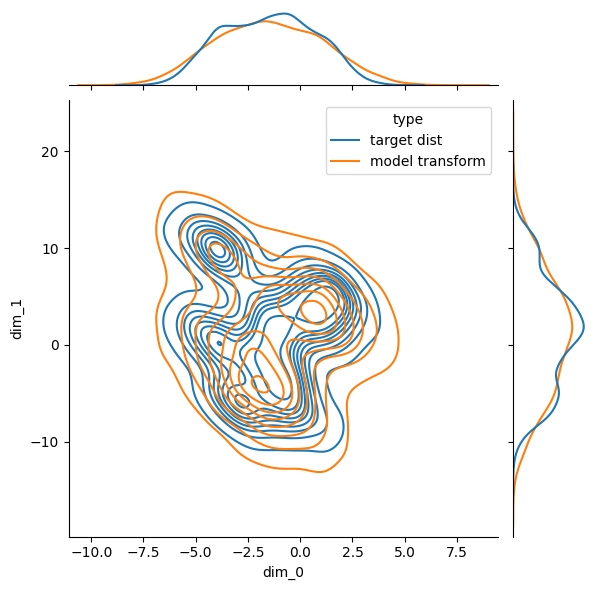

trail: 0 m step: 4 kl_test: 3.081510543823242


  2%|▏         | 100/6000 [00:31<34:22,  2.86it/s]

trail: 0 m step: 5 Loss: 2.6616172790527344  L_n: 2.3287277221679688  kld: 0.03328895568847656 KLD1: 2.3065147399902344 KLD2: 1.2035777568817139


  3%|▎         | 200/6000 [01:02<33:19,  2.90it/s]

trail: 0 m step: 5 Loss: 2.616037368774414  L_n: 2.2992076873779297  kld: 0.03168296813964844 KLD1: 2.304351568222046 KLD2: 1.217673659324646


  5%|▌         | 300/6000 [01:33<32:57,  2.88it/s]

trail: 0 m step: 5 Loss: 2.6021156311035156  L_n: 2.22894287109375  kld: 0.03731727600097656 KLD1: 2.2311699390411377 KLD2: 1.1866326332092285


  7%|▋         | 400/6000 [02:05<32:18,  2.89it/s]

trail: 0 m step: 5 Loss: 2.589712142944336  L_n: 2.2557735443115234  kld: 0.03339385986328125 KLD1: 2.300393581390381 KLD2: 1.1932506561279297


  8%|▊         | 500/6000 [02:36<31:45,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5800704956054688  L_n: 2.2382164001464844  kld: 0.03418540954589844 KLD1: 2.3125431537628174 KLD2: 1.1597379446029663


 10%|█         | 600/6000 [03:07<31:04,  2.90it/s]

trail: 0 m step: 5 Loss: 2.578350067138672  L_n: 2.2448501586914062  kld: 0.03334999084472656 KLD1: 2.2571959495544434 KLD2: 1.1809204816818237


 12%|█▏        | 700/6000 [03:39<30:36,  2.89it/s]

trail: 0 m step: 5 Loss: 2.6426162719726562  L_n: 2.1987762451171875  kld: 0.044384002685546875 KLD1: 2.1807570457458496 KLD2: 1.162056565284729


 13%|█▎        | 800/6000 [04:10<30:03,  2.88it/s]

trail: 0 m step: 5 Loss: 2.618070602416992  L_n: 2.239004135131836  kld: 0.037906646728515625 KLD1: 2.2243010997772217 KLD2: 1.1656219959259033


 15%|█▌        | 900/6000 [04:41<29:23,  2.89it/s]

trail: 0 m step: 5 Loss: 2.583871841430664  L_n: 2.1719799041748047  kld: 0.04118919372558594 KLD1: 2.215751886367798 KLD2: 1.1655710935592651


 17%|█▋        | 1000/6000 [05:12<28:51,  2.89it/s]

trail: 0 m step: 5 Loss: 2.6098995208740234  L_n: 2.250955581665039  kld: 0.03589439392089844 KLD1: 2.250422239303589 KLD2: 1.1891694068908691


 18%|█▊        | 1100/6000 [05:44<28:14,  2.89it/s]

trail: 0 m step: 5 Loss: 2.6509761810302734  L_n: 2.243051528930664  kld: 0.04079246520996094 KLD1: 2.201047897338867 KLD2: 1.165840744972229


 20%|██        | 1200/6000 [06:15<27:41,  2.89it/s]

trail: 0 m step: 5 Loss: 2.6829376220703125  L_n: 2.265838623046875  kld: 0.04170989990234375 KLD1: 2.172119140625 KLD2: 1.1576355695724487


 22%|██▏       | 1300/6000 [06:46<27:12,  2.88it/s]

trail: 0 m step: 5 Loss: 2.6251754760742188  L_n: 2.2269210815429688  kld: 0.039825439453125 KLD1: 2.2019381523132324 KLD2: 1.1681325435638428


 23%|██▎       | 1400/6000 [07:17<26:30,  2.89it/s]

trail: 0 m step: 5 Loss: 2.600564956665039  L_n: 2.2073841094970703  kld: 0.039318084716796875 KLD1: 2.2107410430908203 KLD2: 1.143447995185852


 25%|██▌       | 1500/6000 [07:49<26:02,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5294036865234375  L_n: 2.17333984375  kld: 0.03560638427734375 KLD1: 2.262910842895508 KLD2: 1.1611144542694092


 27%|██▋       | 1600/6000 [08:20<25:28,  2.88it/s]

trail: 0 m step: 5 Loss: 2.642995834350586  L_n: 2.2358341217041016  kld: 0.04071617126464844 KLD1: 2.16260027885437 KLD2: 1.1531643867492676


 28%|██▊       | 1700/6000 [08:52<24:46,  2.89it/s]

trail: 0 m step: 5 Loss: 2.605897903442383  L_n: 2.187063217163086  kld: 0.04188346862792969 KLD1: 2.1622159481048584 KLD2: 1.1431597471237183


 30%|███       | 1800/6000 [09:23<24:17,  2.88it/s]

trail: 0 m step: 5 Loss: 2.554342269897461  L_n: 2.1529979705810547  kld: 0.040134429931640625 KLD1: 2.1813275814056396 KLD2: 1.1796590089797974


 32%|███▏      | 1900/6000 [09:54<23:42,  2.88it/s]

trail: 0 m step: 5 Loss: 2.6455631256103516  L_n: 2.2250308990478516  kld: 0.04205322265625 KLD1: 2.1651408672332764 KLD2: 1.164540410041809


 33%|███▎      | 2000/6000 [10:26<23:09,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5666980743408203  L_n: 2.2102527618408203  kld: 0.03564453125 KLD1: 2.2303528785705566 KLD2: 1.1503154039382935


 35%|███▌      | 2100/6000 [10:57<22:30,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5494232177734375  L_n: 2.1677627563476562  kld: 0.038166046142578125 KLD1: 2.211010217666626 KLD2: 1.1612614393234253


 37%|███▋      | 2200/6000 [11:28<21:56,  2.89it/s]

trail: 0 m step: 5 Loss: 2.600828170776367  L_n: 2.2055110931396484  kld: 0.039531707763671875 KLD1: 2.1780056953430176 KLD2: 1.168084740638733


 38%|███▊      | 2300/6000 [11:59<21:20,  2.89it/s]

trail: 0 m step: 5 Loss: 2.538196563720703  L_n: 2.171966552734375  kld: 0.03662300109863281 KLD1: 2.2241008281707764 KLD2: 1.1266018152236938


 40%|████      | 2400/6000 [12:31<20:48,  2.88it/s]

trail: 0 m step: 5 Loss: 2.551668167114258  L_n: 2.131040573120117  kld: 0.04206275939941406 KLD1: 2.1808714866638184 KLD2: 1.1599557399749756


 42%|████▏     | 2500/6000 [13:02<20:14,  2.88it/s]

trail: 0 m step: 5 Loss: 2.6539649963378906  L_n: 2.2097434997558594  kld: 0.044422149658203125 KLD1: 2.1274139881134033 KLD2: 1.164912223815918


 43%|████▎     | 2600/6000 [13:33<19:40,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5966224670410156  L_n: 2.223297119140625  kld: 0.03733253479003906 KLD1: 2.216583251953125 KLD2: 1.1458666324615479


 45%|████▌     | 2700/6000 [14:05<19:05,  2.88it/s]

trail: 0 m step: 5 Loss: 2.543153762817383  L_n: 2.1636104583740234  kld: 0.03795433044433594 KLD1: 2.1933679580688477 KLD2: 1.1409162282943726


 47%|████▋     | 2800/6000 [14:36<18:30,  2.88it/s]

trail: 0 m step: 5 Loss: 2.6109867095947266  L_n: 2.2127323150634766  kld: 0.039825439453125 KLD1: 2.1937663555145264 KLD2: 1.152040958404541


 48%|████▊     | 2900/6000 [15:07<17:54,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5248794555664062  L_n: 2.1643714904785156  kld: 0.03605079650878906 KLD1: 2.209472179412842 KLD2: 1.1461821794509888


 50%|█████     | 3000/6000 [15:39<17:21,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5711631774902344  L_n: 2.166748046875  kld: 0.04044151306152344 KLD1: 2.158984661102295 KLD2: 1.1589280366897583


 52%|█████▏    | 3100/6000 [16:10<16:47,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5733699798583984  L_n: 2.2048511505126953  kld: 0.03685188293457031 KLD1: 2.205408811569214 KLD2: 1.178954839706421


 53%|█████▎    | 3200/6000 [16:41<16:08,  2.89it/s]

trail: 0 m step: 5 Loss: 2.6332244873046875  L_n: 2.2343406677246094  kld: 0.03988838195800781 KLD1: 2.166510581970215 KLD2: 1.1479140520095825


 55%|█████▌    | 3300/6000 [17:13<15:36,  2.88it/s]

trail: 0 m step: 5 Loss: 2.571523666381836  L_n: 2.174165725708008  kld: 0.03973579406738281 KLD1: 2.14646053314209 KLD2: 1.1474310159683228


 57%|█████▋    | 3400/6000 [17:44<15:00,  2.89it/s]

trail: 0 m step: 5 Loss: 2.509979248046875  L_n: 2.156585693359375  kld: 0.03533935546875 KLD1: 2.2204761505126953 KLD2: 1.1557939052581787


 58%|█████▊    | 3500/6000 [18:15<14:29,  2.88it/s]

trail: 0 m step: 5 Loss: 2.580343246459961  L_n: 2.1632251739501953  kld: 0.04171180725097656 KLD1: 2.176065683364868 KLD2: 1.1391351222991943


 60%|██████    | 3600/6000 [18:47<13:53,  2.88it/s]

trail: 0 m step: 5 Loss: 2.6168041229248047  L_n: 2.174013137817383  kld: 0.04427909851074219 KLD1: 2.116826057434082 KLD2: 1.1381288766860962


 62%|██████▏   | 3700/6000 [19:18<13:16,  2.89it/s]

trail: 0 m step: 5 Loss: 2.591094970703125  L_n: 2.1837234497070312  kld: 0.040737152099609375 KLD1: 2.181837558746338 KLD2: 1.1527245044708252


 63%|██████▎   | 3800/6000 [19:50<12:44,  2.88it/s]

trail: 0 m step: 5 Loss: 2.591571807861328  L_n: 2.1828079223632812  kld: 0.04087638854980469 KLD1: 2.174166202545166 KLD2: 1.165582299232483


 65%|██████▌   | 3900/6000 [20:21<12:10,  2.87it/s]

trail: 0 m step: 5 Loss: 2.5873050689697266  L_n: 2.189565658569336  kld: 0.03977394104003906 KLD1: 2.1910529136657715 KLD2: 1.1512656211853027


 67%|██████▋   | 4000/6000 [20:52<11:33,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5737438201904297  L_n: 2.153078079223633  kld: 0.04206657409667969 KLD1: 2.1567249298095703 KLD2: 1.1445491313934326


 68%|██████▊   | 4100/6000 [21:24<10:58,  2.89it/s]

trail: 0 m step: 5 Loss: 2.577695846557617  L_n: 2.1890926361083984  kld: 0.038860321044921875 KLD1: 2.16741943359375 KLD2: 1.1401339769363403


 70%|███████   | 4200/6000 [21:55<10:23,  2.88it/s]

trail: 0 m step: 5 Loss: 2.5817623138427734  L_n: 2.1970882415771484  kld: 0.0384674072265625 KLD1: 2.1951544284820557 KLD2: 1.1471120119094849


 72%|███████▏  | 4300/6000 [22:26<09:49,  2.88it/s]

trail: 0 m step: 5 Loss: 2.591167449951172  L_n: 2.2003707885742188  kld: 0.03907966613769531 KLD1: 2.1626527309417725 KLD2: 1.1658693552017212


 73%|███████▎  | 4400/6000 [22:58<09:13,  2.89it/s]

trail: 0 m step: 5 Loss: 2.6605491638183594  L_n: 2.2325782775878906  kld: 0.042797088623046875 KLD1: 2.1589202880859375 KLD2: 1.172651767730713


 75%|███████▌  | 4500/6000 [23:29<08:40,  2.88it/s]

trail: 0 m step: 5 Loss: 2.4357681274414062  L_n: 2.0810203552246094  kld: 0.03547477722167969 KLD1: 2.2198433876037598 KLD2: 1.1526191234588623


 77%|███████▋  | 4600/6000 [24:00<08:04,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5716285705566406  L_n: 2.160614013671875  kld: 0.04110145568847656 KLD1: 2.157365560531616 KLD2: 1.168300986289978


 78%|███████▊  | 4700/6000 [24:32<07:28,  2.90it/s]

trail: 0 m step: 5 Loss: 2.517026901245117  L_n: 2.185586929321289  kld: 0.03314399719238281 KLD1: 2.2643957138061523 KLD2: 1.1650655269622803


 80%|████████  | 4800/6000 [25:03<06:56,  2.88it/s]

trail: 0 m step: 5 Loss: 2.537374496459961  L_n: 2.153635025024414  kld: 0.03837394714355469 KLD1: 2.1924874782562256 KLD2: 1.1689693927764893


 82%|████████▏ | 4900/6000 [25:34<06:20,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5627994537353516  L_n: 2.1947574615478516  kld: 0.03680419921875 KLD1: 2.194694757461548 KLD2: 1.1497451066970825


 83%|████████▎ | 5000/6000 [26:05<05:46,  2.88it/s]

trail: 0 m step: 5 Loss: 2.597806930541992  L_n: 2.208250045776367  kld: 0.0389556884765625 KLD1: 2.1806139945983887 KLD2: 1.1630380153656006


 85%|████████▌ | 5100/6000 [26:37<05:11,  2.89it/s]

trail: 0 m step: 5 Loss: 2.679079055786133  L_n: 2.262971878051758  kld: 0.0416107177734375 KLD1: 2.153352975845337 KLD2: 1.1569401025772095


 87%|████████▋ | 5200/6000 [27:08<04:37,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5465030670166016  L_n: 2.1511287689208984  kld: 0.03953742980957031 KLD1: 2.1697616577148438 KLD2: 1.1926623582839966


 88%|████████▊ | 5300/6000 [27:39<04:02,  2.89it/s]

trail: 0 m step: 5 Loss: 2.49542236328125  L_n: 2.133922576904297  kld: 0.03614997863769531 KLD1: 2.23697566986084 KLD2: 1.1527363061904907


 90%|█████████ | 5400/6000 [28:11<03:27,  2.89it/s]

trail: 0 m step: 5 Loss: 2.578014373779297  L_n: 2.1611061096191406  kld: 0.041690826416015625 KLD1: 2.1602635383605957 KLD2: 1.1449191570281982


 92%|█████████▏| 5500/6000 [28:42<02:53,  2.88it/s]

trail: 0 m step: 5 Loss: 2.589628219604492  L_n: 2.208311080932617  kld: 0.0381317138671875 KLD1: 2.1907236576080322 KLD2: 1.1532944440841675


 93%|█████████▎| 5600/6000 [29:13<02:18,  2.90it/s]

trail: 0 m step: 5 Loss: 2.522907257080078  L_n: 2.1429443359375  kld: 0.03799629211425781 KLD1: 2.179701089859009 KLD2: 1.1479841470718384


 95%|█████████▌| 5700/6000 [29:44<01:43,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5610504150390625  L_n: 2.157665252685547  kld: 0.04033851623535156 KLD1: 2.155256748199463 KLD2: 1.159208059310913


 97%|█████████▋| 5800/6000 [30:16<01:09,  2.89it/s]

trail: 0 m step: 5 Loss: 2.542306900024414  L_n: 2.1665592193603516  kld: 0.03757476806640625 KLD1: 2.2023379802703857 KLD2: 1.1602556705474854


 98%|█████████▊| 5900/6000 [30:47<00:34,  2.89it/s]

trail: 0 m step: 5 Loss: 2.5500526428222656  L_n: 2.160991668701172  kld: 0.038906097412109375 KLD1: 2.167391061782837 KLD2: 1.1506154537200928


100%|██████████| 6000/6000 [31:18<00:00,  3.19it/s]

trail: 0 m step: 5 Loss: 2.601369857788086  L_n: 2.201608657836914  kld: 0.03997611999511719 KLD1: 2.146655797958374 KLD2: 1.1433923244476318



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


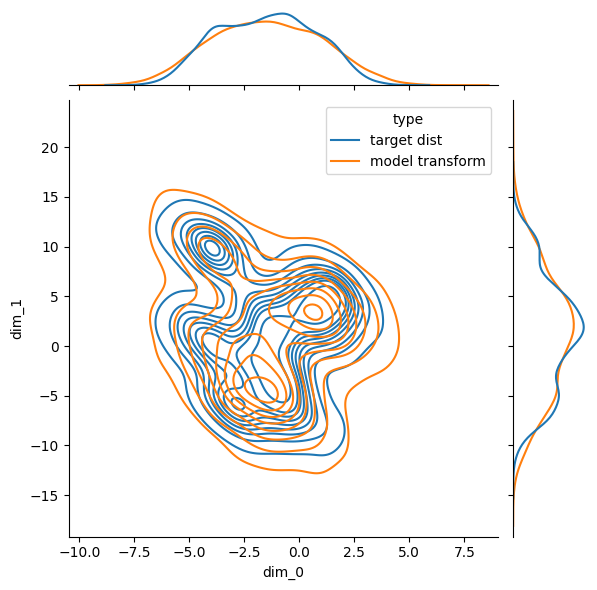

trail: 0 m step: 5 kl_test: 2.170743942260742


  2%|▏         | 100/6000 [00:31<34:14,  2.87it/s]

trail: 0 m step: 6 Loss: 1.9203472137451172  L_n: 1.6942882537841797  kld: 0.02260589599609375 KLD1: 1.696272611618042 KLD2: 0.944952130317688


  3%|▎         | 200/6000 [01:02<33:29,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8983497619628906  L_n: 1.6913642883300781  kld: 0.02069854736328125 KLD1: 1.696673035621643 KLD2: 0.9590824246406555


  5%|▌         | 300/6000 [01:34<32:59,  2.88it/s]

trail: 0 m step: 6 Loss: 1.8710269927978516  L_n: 1.6334667205810547  kld: 0.023756027221679688 KLD1: 1.6391046047210693 KLD2: 0.9389089345932007


  7%|▋         | 400/6000 [02:05<32:20,  2.89it/s]

trail: 0 m step: 6 Loss: 1.866281509399414  L_n: 1.648824691772461  kld: 0.021745681762695312 KLD1: 1.680281400680542 KLD2: 0.9377807378768921


  8%|▊         | 500/6000 [02:36<31:46,  2.88it/s]

trail: 0 m step: 6 Loss: 1.8614788055419922  L_n: 1.6235942840576172  kld: 0.0237884521484375 KLD1: 1.6833420991897583 KLD2: 0.9092930555343628


 10%|█         | 600/6000 [03:08<31:19,  2.87it/s]

trail: 0 m step: 6 Loss: 1.865652084350586  L_n: 1.638448715209961  kld: 0.0227203369140625 KLD1: 1.6836844682693481 KLD2: 0.9328397512435913


 12%|█▏        | 700/6000 [03:39<30:36,  2.89it/s]

trail: 0 m step: 6 Loss: 1.909219741821289  L_n: 1.6055126190185547  kld: 0.030370712280273438 KLD1: 1.5918753147125244 KLD2: 0.9168682098388672


 13%|█▎        | 800/6000 [04:10<30:00,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9169597625732422  L_n: 1.6627483367919922  kld: 0.025421142578125 KLD1: 1.6356924772262573 KLD2: 0.9163261651992798


 15%|█▌        | 900/6000 [04:42<29:22,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8819198608398438  L_n: 1.6106185913085938  kld: 0.027130126953125 KLD1: 1.6529364585876465 KLD2: 0.9180888533592224


 17%|█▋        | 1000/6000 [05:13<28:53,  2.88it/s]

trail: 0 m step: 6 Loss: 1.8940353393554688  L_n: 1.6533470153808594  kld: 0.024068832397460938 KLD1: 1.6626101732254028 KLD2: 0.9382318258285522


 18%|█▊        | 1100/6000 [05:44<28:17,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9122505187988281  L_n: 1.6301345825195312  kld: 0.028211593627929688 KLD1: 1.5963517427444458 KLD2: 0.9144889712333679


 20%|██        | 1200/6000 [06:15<27:38,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9558277130126953  L_n: 1.6672840118408203  kld: 0.0288543701171875 KLD1: 1.6027508974075317 KLD2: 0.9092016220092773


 22%|██▏       | 1300/6000 [06:47<27:09,  2.88it/s]

trail: 0 m step: 6 Loss: 1.9264678955078125  L_n: 1.6474037170410156  kld: 0.027906417846679688 KLD1: 1.619470477104187 KLD2: 0.9166697263717651


 23%|██▎       | 1400/6000 [07:18<26:35,  2.88it/s]

trail: 0 m step: 6 Loss: 1.8812808990478516  L_n: 1.6191349029541016  kld: 0.026214599609375 KLD1: 1.6248449087142944 KLD2: 0.9001216292381287


 25%|██▌       | 1500/6000 [07:49<25:54,  2.89it/s]

trail: 0 m step: 6 Loss: 1.855560302734375  L_n: 1.6071090698242188  kld: 0.024845123291015625 KLD1: 1.6503726243972778 KLD2: 0.9116773009300232


 27%|██▋       | 1600/6000 [08:21<25:27,  2.88it/s]

trail: 0 m step: 6 Loss: 1.942291259765625  L_n: 1.6696739196777344  kld: 0.027261734008789062 KLD1: 1.5894113779067993 KLD2: 0.9094102382659912


 28%|██▊       | 1700/6000 [08:52<24:48,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9024028778076172  L_n: 1.6167964935302734  kld: 0.028560638427734375 KLD1: 1.584262490272522 KLD2: 0.901282787322998


 30%|███       | 1800/6000 [09:23<24:10,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8660049438476562  L_n: 1.5858345031738281  kld: 0.028017044067382812 KLD1: 1.606716513633728 KLD2: 0.9329015612602234


 32%|███▏      | 1900/6000 [09:54<23:37,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9475135803222656  L_n: 1.6553268432617188  kld: 0.029218673706054688 KLD1: 1.5879907608032227 KLD2: 0.9211696982383728


 33%|███▎      | 2000/6000 [10:26<23:06,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8657989501953125  L_n: 1.6259498596191406  kld: 0.023984909057617188 KLD1: 1.6401126384735107 KLD2: 0.9044749736785889


 35%|███▌      | 2100/6000 [10:57<22:27,  2.89it/s]

trail: 0 m step: 6 Loss: 1.834524154663086  L_n: 1.5832881927490234  kld: 0.02512359619140625 KLD1: 1.6408284902572632 KLD2: 0.9169495105743408


 37%|███▋      | 2200/6000 [11:28<21:57,  2.88it/s]

trail: 0 m step: 6 Loss: 1.8946781158447266  L_n: 1.6253032684326172  kld: 0.026937484741210938 KLD1: 1.5954885482788086 KLD2: 0.9234535098075867


 38%|███▊      | 2300/6000 [12:00<21:19,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8365516662597656  L_n: 1.5866508483886719  kld: 0.024990081787109375 KLD1: 1.6348447799682617 KLD2: 0.8809869885444641


 40%|████      | 2400/6000 [12:31<20:47,  2.89it/s]

trail: 0 m step: 6 Loss: 1.858102798461914  L_n: 1.574575424194336  kld: 0.028352737426757812 KLD1: 1.6201894283294678 KLD2: 0.9153196811676025


 42%|████▏     | 2500/6000 [13:02<20:07,  2.90it/s]

trail: 0 m step: 6 Loss: 1.9467144012451172  L_n: 1.6411571502685547  kld: 0.03055572509765625 KLD1: 1.565887451171875 KLD2: 0.9172613024711609


 43%|████▎     | 2600/6000 [13:33<19:34,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9031295776367188  L_n: 1.6614112854003906  kld: 0.024171829223632812 KLD1: 1.6337860822677612 KLD2: 0.9017376899719238


 45%|████▌     | 2700/6000 [14:05<19:01,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8411903381347656  L_n: 1.5790634155273438  kld: 0.026212692260742188 KLD1: 1.6177271604537964 KLD2: 0.8989839553833008


 47%|████▋     | 2800/6000 [14:36<18:24,  2.90it/s]

trail: 0 m step: 6 Loss: 1.9011116027832031  L_n: 1.6355514526367188  kld: 0.026556015014648438 KLD1: 1.6002724170684814 KLD2: 0.9074552655220032


 48%|████▊     | 2900/6000 [15:07<17:50,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8402214050292969  L_n: 1.6005630493164062  kld: 0.023965835571289062 KLD1: 1.6442663669586182 KLD2: 0.9027230143547058


 50%|█████     | 3000/6000 [15:38<17:15,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8820781707763672  L_n: 1.6061420440673828  kld: 0.027593612670898438 KLD1: 1.59073007106781 KLD2: 0.9114644527435303


 52%|█████▏    | 3100/6000 [16:10<16:42,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8869705200195312  L_n: 1.6438789367675781  kld: 0.024309158325195312 KLD1: 1.607493281364441 KLD2: 0.932219922542572


 53%|█████▎    | 3200/6000 [16:41<16:09,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8922977447509766  L_n: 1.6318302154541016  kld: 0.0260467529296875 KLD1: 1.5941358804702759 KLD2: 0.9047689437866211


 55%|█████▌    | 3300/6000 [17:12<15:34,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8581905364990234  L_n: 1.6011943817138672  kld: 0.025699615478515625 KLD1: 1.5951088666915894 KLD2: 0.9050942063331604


 57%|█████▋    | 3400/6000 [17:43<15:00,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8280906677246094  L_n: 1.6018218994140625  kld: 0.022626876831054688 KLD1: 1.6489390134811401 KLD2: 0.9102125763893127


 58%|█████▊    | 3500/6000 [18:15<14:21,  2.90it/s]

trail: 0 m step: 6 Loss: 1.856576919555664  L_n: 1.5845699310302734  kld: 0.027200698852539062 KLD1: 1.6103665828704834 KLD2: 0.8944994211196899


 60%|██████    | 3600/6000 [18:46<13:47,  2.90it/s]

trail: 0 m step: 6 Loss: 1.9243659973144531  L_n: 1.6140213012695312  kld: 0.031034469604492188 KLD1: 1.538318157196045 KLD2: 0.8937351107597351


 62%|██████▏   | 3700/6000 [19:17<13:14,  2.89it/s]

trail: 0 m step: 6 Loss: 1.889028549194336  L_n: 1.6176700592041016  kld: 0.027135848999023438 KLD1: 1.594675898551941 KLD2: 0.907800555229187


 63%|██████▎   | 3800/6000 [19:48<12:38,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8997268676757812  L_n: 1.6200141906738281  kld: 0.027971267700195312 KLD1: 1.6016587018966675 KLD2: 0.9198718667030334


 65%|██████▌   | 3900/6000 [20:20<12:06,  2.89it/s]

trail: 0 m step: 6 Loss: 1.894796371459961  L_n: 1.6245059967041016  kld: 0.027029037475585938 KLD1: 1.6072485446929932 KLD2: 0.9075607061386108


 67%|██████▋   | 4000/6000 [20:51<11:31,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8568496704101562  L_n: 1.5756301879882812  kld: 0.0281219482421875 KLD1: 1.5833735466003418 KLD2: 0.8994772434234619


 68%|██████▊   | 4100/6000 [21:22<10:57,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8718986511230469  L_n: 1.6177635192871094  kld: 0.02541351318359375 KLD1: 1.602618932723999 KLD2: 0.8941847681999207


 70%|███████   | 4200/6000 [21:53<10:23,  2.89it/s]

trail: 0 m step: 6 Loss: 1.876485824584961  L_n: 1.621664047241211  kld: 0.025482177734375 KLD1: 1.62039315700531 KLD2: 0.9016726613044739


 72%|███████▏  | 4300/6000 [22:25<09:49,  2.88it/s]

trail: 0 m step: 6 Loss: 1.8836326599121094  L_n: 1.6137237548828125  kld: 0.026990890502929688 KLD1: 1.5800215005874634 KLD2: 0.91928631067276


 73%|███████▎  | 4400/6000 [22:56<09:14,  2.89it/s]

trail: 0 m step: 6 Loss: 1.9414196014404297  L_n: 1.6463909149169922  kld: 0.02950286865234375 KLD1: 1.5779764652252197 KLD2: 0.9268840551376343


 75%|███████▌  | 4500/6000 [23:27<08:39,  2.89it/s]

trail: 0 m step: 6 Loss: 1.7640018463134766  L_n: 1.534261703491211  kld: 0.022974014282226562 KLD1: 1.6411491632461548 KLD2: 0.9082949757575989


 77%|███████▋  | 4600/6000 [23:59<08:03,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8862800598144531  L_n: 1.6106681823730469  kld: 0.027561187744140625 KLD1: 1.5977731943130493 KLD2: 0.9223839640617371


 78%|███████▊  | 4700/6000 [24:30<07:28,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8222923278808594  L_n: 1.6168708801269531  kld: 0.020542144775390625 KLD1: 1.6845226287841797 KLD2: 0.9196224212646484


 80%|████████  | 4800/6000 [25:01<06:54,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8468494415283203  L_n: 1.5922374725341797  kld: 0.025461196899414062 KLD1: 1.606057047843933 KLD2: 0.9228906035423279


 82%|████████▏ | 4900/6000 [25:32<06:20,  2.89it/s]

trail: 0 m step: 6 Loss: 1.852457046508789  L_n: 1.616689682006836  kld: 0.023576736450195312 KLD1: 1.6250755786895752 KLD2: 0.9061870574951172


 83%|████████▎ | 5000/6000 [26:04<05:45,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8857994079589844  L_n: 1.6363754272460938  kld: 0.024942398071289062 KLD1: 1.611931562423706 KLD2: 0.9183290600776672


 85%|████████▌ | 5100/6000 [26:35<05:10,  2.90it/s]

trail: 0 m step: 6 Loss: 1.9395065307617188  L_n: 1.6694259643554688  kld: 0.027008056640625 KLD1: 1.5982874631881714 KLD2: 0.9158438444137573


 87%|████████▋ | 5200/6000 [27:06<04:35,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8519020080566406  L_n: 1.5876960754394531  kld: 0.02642059326171875 KLD1: 1.585267424583435 KLD2: 0.9454616904258728


 88%|████████▊ | 5300/6000 [27:37<04:02,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8292732238769531  L_n: 1.5940780639648438  kld: 0.023519515991210938 KLD1: 1.6333239078521729 KLD2: 0.9079639315605164


 90%|█████████ | 5400/6000 [28:08<03:26,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8839778900146484  L_n: 1.5967121124267578  kld: 0.028726577758789062 KLD1: 1.5919824838638306 KLD2: 0.9017361998558044


 92%|█████████▏| 5500/6000 [28:40<02:52,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8707084655761719  L_n: 1.6192436218261719  kld: 0.025146484375 KLD1: 1.6224913597106934 KLD2: 0.9091394543647766


 93%|█████████▎| 5600/6000 [29:11<02:17,  2.90it/s]

trail: 0 m step: 6 Loss: 1.8540878295898438  L_n: 1.5965385437011719  kld: 0.025754928588867188 KLD1: 1.5778003931045532 KLD2: 0.9037513732910156


 95%|█████████▌| 5700/6000 [29:42<01:43,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8758983612060547  L_n: 1.602499008178711  kld: 0.027339935302734375 KLD1: 1.575437307357788 KLD2: 0.9135115146636963


 97%|█████████▋| 5800/6000 [30:13<01:09,  2.89it/s]

trail: 0 m step: 6 Loss: 1.862722396850586  L_n: 1.6077861785888672  kld: 0.025493621826171875 KLD1: 1.6053587198257446 KLD2: 0.914360523223877


 98%|█████████▊| 5900/6000 [30:45<00:34,  2.89it/s]

trail: 0 m step: 6 Loss: 1.8506317138671875  L_n: 1.5940170288085938  kld: 0.025661468505859375 KLD1: 1.6135919094085693 KLD2: 0.9069325923919678


100%|██████████| 6000/6000 [31:16<00:00,  3.20it/s]

trail: 0 m step: 6 Loss: 1.8757610321044922  L_n: 1.6102962493896484  kld: 0.026546478271484375 KLD1: 1.5818514823913574 KLD2: 0.8998745083808899



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


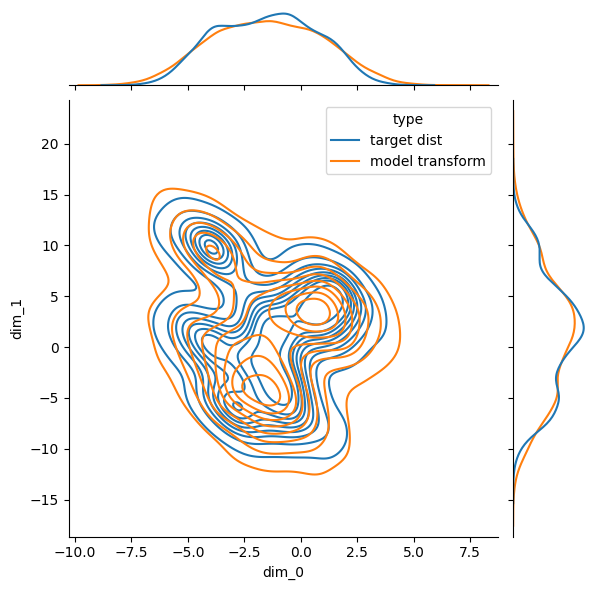

trail: 0 m step: 6 kl_test: 1.6099071502685547


  2%|▏         | 100/6000 [00:31<34:18,  2.87it/s]

trail: 0 m step: 7 Loss: 1.4469327926635742  L_n: 1.2886896133422852  kld: 0.015824317932128906 KLD1: 1.2752512693405151 KLD2: 0.7541360259056091


  3%|▎         | 200/6000 [01:02<33:22,  2.90it/s]

trail: 0 m step: 7 Loss: 1.4103097915649414  L_n: 1.2772150039672852  kld: 0.013309478759765625 KLD1: 1.3068501949310303 KLD2: 0.7691066861152649


  5%|▌         | 300/6000 [01:33<32:58,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4283523559570312  L_n: 1.2623844146728516  kld: 0.01659679412841797 KLD1: 1.2440546751022339 KLD2: 0.7534531354904175


  7%|▋         | 400/6000 [02:05<32:20,  2.89it/s]

trail: 0 m step: 7 Loss: 1.394866943359375  L_n: 1.250518798828125  kld: 0.014434814453125 KLD1: 1.2703526020050049 KLD2: 0.7474692463874817


  8%|▊         | 500/6000 [02:36<31:48,  2.88it/s]

trail: 0 m step: 7 Loss: 1.404153823852539  L_n: 1.2430686950683594  kld: 0.01610851287841797 KLD1: 1.2982091903686523 KLD2: 0.7224556803703308


 10%|█         | 600/6000 [03:07<31:12,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4218883514404297  L_n: 1.2571220397949219  kld: 0.01647663116455078 KLD1: 1.2594090700149536 KLD2: 0.7403867840766907


 12%|█▏        | 700/6000 [03:39<30:35,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4506950378417969  L_n: 1.2246456146240234  kld: 0.022604942321777344 KLD1: 1.1844561100006104 KLD2: 0.7269183397293091


 13%|█▎        | 800/6000 [04:10<30:06,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4397954940795898  L_n: 1.2554216384887695  kld: 0.01843738555908203 KLD1: 1.2230128049850464 KLD2: 0.7335054874420166


 15%|█▌        | 900/6000 [04:41<29:23,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4011478424072266  L_n: 1.2149333953857422  kld: 0.018621444702148438 KLD1: 1.2543538808822632 KLD2: 0.7343774437904358


 17%|█▋        | 1000/6000 [05:13<28:56,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4228620529174805  L_n: 1.2530126571655273  kld: 0.016984939575195312 KLD1: 1.2653993368148804 KLD2: 0.7539675831794739


 18%|█▊        | 1100/6000 [05:44<28:16,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4329414367675781  L_n: 1.2233905792236328  kld: 0.02095508575439453 KLD1: 1.2001177072525024 KLD2: 0.7285178899765015


 20%|██        | 1200/6000 [06:15<27:42,  2.89it/s]

trail: 0 m step: 7 Loss: 1.473292350769043  L_n: 1.270808219909668  kld: 0.0202484130859375 KLD1: 1.2021496295928955 KLD2: 0.727322518825531


 22%|██▏       | 1300/6000 [06:47<27:07,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4476251602172852  L_n: 1.2418317794799805  kld: 0.02057933807373047 KLD1: 1.228812575340271 KLD2: 0.7355578541755676


 23%|██▎       | 1400/6000 [07:18<26:36,  2.88it/s]

trail: 0 m step: 7 Loss: 1.417576789855957  L_n: 1.2314767837524414  kld: 0.018610000610351562 KLD1: 1.2297385931015015 KLD2: 0.7171880602836609


 25%|██▌       | 1500/6000 [07:49<25:54,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4057502746582031  L_n: 1.2217388153076172  kld: 0.018401145935058594 KLD1: 1.2407217025756836 KLD2: 0.7253419160842896


 27%|██▋       | 1600/6000 [08:20<25:26,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4410552978515625  L_n: 1.2500534057617188  kld: 0.019100189208984375 KLD1: 1.2184200286865234 KLD2: 0.7236747741699219


 28%|██▊       | 1700/6000 [08:52<24:49,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4191064834594727  L_n: 1.2177000045776367  kld: 0.020140647888183594 KLD1: 1.2030941247940063 KLD2: 0.7165984511375427


 30%|███       | 1800/6000 [09:23<24:12,  2.89it/s]

trail: 0 m step: 7 Loss: 1.401759147644043  L_n: 1.1993894577026367  kld: 0.020236968994140625 KLD1: 1.1980109214782715 KLD2: 0.7450498342514038


 32%|███▏      | 1900/6000 [09:54<23:33,  2.90it/s]

trail: 0 m step: 7 Loss: 1.456639289855957  L_n: 1.2483282089233398  kld: 0.02083110809326172 KLD1: 1.1881568431854248 KLD2: 0.7352743148803711


 33%|███▎      | 2000/6000 [10:26<23:05,  2.89it/s]

trail: 0 m step: 7 Loss: 1.414968490600586  L_n: 1.2351531982421875  kld: 0.017981529235839844 KLD1: 1.2341437339782715 KLD2: 0.7186495661735535


 35%|███▌      | 2100/6000 [10:57<22:29,  2.89it/s]

trail: 0 m step: 7 Loss: 1.3832759857177734  L_n: 1.2071418762207031  kld: 0.01761341094970703 KLD1: 1.2396653890609741 KLD2: 0.7317297458648682


 37%|███▋      | 2200/6000 [11:28<21:56,  2.89it/s]

trail: 0 m step: 7 Loss: 1.426351547241211  L_n: 1.2310867309570312  kld: 0.01952648162841797 KLD1: 1.2016452550888062 KLD2: 0.738068163394928


 38%|███▊      | 2300/6000 [11:59<21:20,  2.89it/s]

trail: 0 m step: 7 Loss: 1.3869638442993164  L_n: 1.2109346389770508  kld: 0.017602920532226562 KLD1: 1.2261518239974976 KLD2: 0.7002323865890503


 40%|████      | 2400/6000 [12:31<20:46,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4026613235473633  L_n: 1.2015981674194336  kld: 0.02010631561279297 KLD1: 1.211165428161621 KLD2: 0.7309689521789551


 42%|████▏     | 2500/6000 [13:02<20:10,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4607820510864258  L_n: 1.2424383163452148  kld: 0.021834373474121094 KLD1: 1.1811652183532715 KLD2: 0.7325390577316284


 43%|████▎     | 2600/6000 [13:33<19:40,  2.88it/s]

trail: 0 m step: 7 Loss: 1.413893699645996  L_n: 1.2456560134887695  kld: 0.016823768615722656 KLD1: 1.2457935810089111 KLD2: 0.7183775901794434


 45%|████▌     | 2700/6000 [14:05<19:04,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3805341720581055  L_n: 1.1956262588500977  kld: 0.01849079132080078 KLD1: 1.215656042098999 KLD2: 0.7130329012870789


 47%|████▋     | 2800/6000 [14:36<18:31,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4167518615722656  L_n: 1.2294692993164062  kld: 0.018728256225585938 KLD1: 1.2006322145462036 KLD2: 0.7236724495887756


 48%|████▊     | 2900/6000 [15:07<17:57,  2.88it/s]

trail: 0 m step: 7 Loss: 1.356093406677246  L_n: 1.1929960250854492  kld: 0.016309738159179688 KLD1: 1.2310479879379272 KLD2: 0.7186404466629028


 50%|█████     | 3000/6000 [15:39<17:21,  2.88it/s]

trail: 0 m step: 7 Loss: 1.404444694519043  L_n: 1.2116689682006836  kld: 0.019277572631835938 KLD1: 1.2095837593078613 KLD2: 0.7293909192085266


 52%|█████▏    | 3100/6000 [16:10<16:47,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4025659561157227  L_n: 1.2400598526000977  kld: 0.0162506103515625 KLD1: 1.2333095073699951 KLD2: 0.7481083869934082


 53%|█████▎    | 3200/6000 [16:41<16:11,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4178314208984375  L_n: 1.2332191467285156  kld: 0.018461227416992188 KLD1: 1.1972992420196533 KLD2: 0.7212055325508118


 55%|█████▌    | 3300/6000 [17:13<15:36,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3815860748291016  L_n: 1.1966304779052734  kld: 0.018495559692382812 KLD1: 1.2057257890701294 KLD2: 0.7235204577445984


 57%|█████▋    | 3400/6000 [17:44<15:02,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3855552673339844  L_n: 1.2211322784423828  kld: 0.016442298889160156 KLD1: 1.234973430633545 KLD2: 0.7277963161468506


 58%|█████▊    | 3500/6000 [18:16<14:27,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3788604736328125  L_n: 1.186666488647461  kld: 0.019219398498535156 KLD1: 1.2108547687530518 KLD2: 0.7126886248588562


 60%|██████    | 3600/6000 [18:47<13:52,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4372968673706055  L_n: 1.2143278121948242  kld: 0.022296905517578125 KLD1: 1.16838800907135 KLD2: 0.7127106189727783


 62%|██████▏   | 3700/6000 [19:18<13:17,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4271697998046875  L_n: 1.2306556701660156  kld: 0.019651412963867188 KLD1: 1.206116795539856 KLD2: 0.725851833820343


 63%|██████▎   | 3800/6000 [19:50<12:43,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4322786331176758  L_n: 1.227372169494629  kld: 0.020490646362304688 KLD1: 1.2053896188735962 KLD2: 0.7336388230323792


 65%|██████▌   | 3900/6000 [20:21<12:06,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4188642501831055  L_n: 1.2295217514038086  kld: 0.018934249877929688 KLD1: 1.2188068628311157 KLD2: 0.7257302403450012


 67%|██████▋   | 4000/6000 [20:52<11:34,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3937654495239258  L_n: 1.2001123428344727  kld: 0.019365310668945312 KLD1: 1.2021862268447876 KLD2: 0.7187716364860535


 68%|██████▊   | 4100/6000 [21:24<10:58,  2.88it/s]

trail: 0 m step: 7 Loss: 1.392378807067871  L_n: 1.2169408798217773  kld: 0.017543792724609375 KLD1: 1.2231860160827637 KLD2: 0.7129305005073547


 70%|███████   | 4200/6000 [21:55<10:25,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3981256484985352  L_n: 1.2241182327270508  kld: 0.017400741577148438 KLD1: 1.2241839170455933 KLD2: 0.7192103862762451


 72%|███████▏  | 4300/6000 [22:26<09:48,  2.89it/s]

trail: 0 m step: 7 Loss: 1.3975019454956055  L_n: 1.2124223709106445  kld: 0.018507957458496094 KLD1: 1.1923116445541382 KLD2: 0.7356271147727966


 73%|███████▎  | 4400/6000 [22:58<09:14,  2.88it/s]

trail: 0 m step: 7 Loss: 1.464798927307129  L_n: 1.257908821105957  kld: 0.020689010620117188 KLD1: 1.1884328126907349 KLD2: 0.7415672540664673


 75%|███████▌  | 4500/6000 [23:29<08:40,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3077869415283203  L_n: 1.147378921508789  kld: 0.016040802001953125 KLD1: 1.2310230731964111 KLD2: 0.724794864654541


 77%|███████▋  | 4600/6000 [24:00<08:04,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4111213684082031  L_n: 1.2224178314208984  kld: 0.01887035369873047 KLD1: 1.2169288396835327 KLD2: 0.7381447553634644


 78%|███████▊  | 4700/6000 [24:31<07:29,  2.90it/s]

trail: 0 m step: 7 Loss: 1.3451128005981445  L_n: 1.2112360000610352  kld: 0.013387680053710938 KLD1: 1.2687820196151733 KLD2: 0.7348056435585022


 80%|████████  | 4800/6000 [25:03<06:54,  2.90it/s]

trail: 0 m step: 7 Loss: 1.373199462890625  L_n: 1.1986103057861328  kld: 0.01745891571044922 KLD1: 1.2175521850585938 KLD2: 0.7379562258720398


 82%|████████▏ | 4900/6000 [25:34<06:20,  2.89it/s]

trail: 0 m step: 7 Loss: 1.383305549621582  L_n: 1.2235078811645508  kld: 0.015979766845703125 KLD1: 1.2332640886306763 KLD2: 0.7238503694534302


 83%|████████▎ | 5000/6000 [26:05<05:47,  2.88it/s]

trail: 0 m step: 7 Loss: 1.4014339447021484  L_n: 1.227579116821289  kld: 0.017385482788085938 KLD1: 1.1997097730636597 KLD2: 0.733025848865509


 85%|████████▌ | 5100/6000 [26:36<05:11,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4655494689941406  L_n: 1.2722969055175781  kld: 0.01932525634765625 KLD1: 1.2079468965530396 KLD2: 0.7304036021232605


 87%|████████▋ | 5200/6000 [27:08<04:36,  2.89it/s]

trail: 0 m step: 7 Loss: 1.3936758041381836  L_n: 1.2059831619262695  kld: 0.018769264221191406 KLD1: 1.2156997919082642 KLD2: 0.7594163417816162


 88%|████████▊ | 5300/6000 [27:39<04:02,  2.89it/s]

trail: 0 m step: 7 Loss: 1.3491086959838867  L_n: 1.1852197647094727  kld: 0.016388893127441406 KLD1: 1.2497620582580566 KLD2: 0.7244158387184143


 90%|█████████ | 5400/6000 [28:10<03:27,  2.89it/s]

trail: 0 m step: 7 Loss: 1.4169063568115234  L_n: 1.2165679931640625  kld: 0.020033836364746094 KLD1: 1.1886096000671387 KLD2: 0.7176899909973145


 92%|█████████▏| 5500/6000 [28:42<02:53,  2.88it/s]

trail: 0 m step: 7 Loss: 1.417734146118164  L_n: 1.2441558837890625  kld: 0.017357826232910156 KLD1: 1.2250484228134155 KLD2: 0.7265371680259705


 93%|█████████▎| 5600/6000 [29:13<02:18,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3920574188232422  L_n: 1.21136474609375  kld: 0.01806926727294922 KLD1: 1.1981769800186157 KLD2: 0.7207790613174438


 95%|█████████▌| 5700/6000 [29:44<01:44,  2.87it/s]

trail: 0 m step: 7 Loss: 1.4016103744506836  L_n: 1.207413673400879  kld: 0.01941967010498047 KLD1: 1.198233723640442 KLD2: 0.7291854619979858


 97%|█████████▋| 5800/6000 [30:16<01:09,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3924484252929688  L_n: 1.2175064086914062  kld: 0.01749420166015625 KLD1: 1.2267447710037231 KLD2: 0.7328269481658936


 98%|█████████▊| 5900/6000 [30:47<00:34,  2.88it/s]

trail: 0 m step: 7 Loss: 1.3972597122192383  L_n: 1.2181787490844727  kld: 0.017908096313476562 KLD1: 1.2090574502944946 KLD2: 0.7250964045524597


100%|██████████| 6000/6000 [31:18<00:00,  3.19it/s]

trail: 0 m step: 7 Loss: 1.404454231262207  L_n: 1.2176198959350586  kld: 0.018683433532714844 KLD1: 1.1845238208770752 KLD2: 0.7168252468109131



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


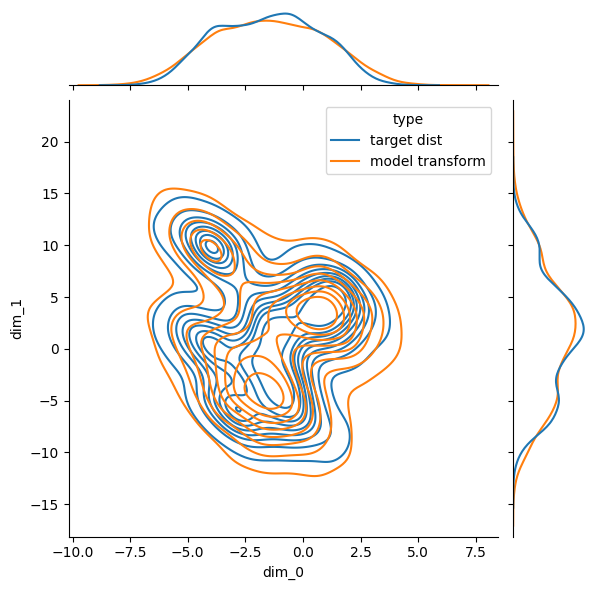

trail: 0 m step: 7 kl_test: 1.212289810180664


  2%|▏         | 100/6000 [00:31<34:16,  2.87it/s]

trail: 0 m step: 8 Loss: 1.1081161499023438  L_n: 0.9939804077148438  kld: 0.01141357421875 KLD1: 0.9943361878395081 KLD2: 0.6078346371650696


  3%|▎         | 200/6000 [01:02<33:25,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0865459442138672  L_n: 0.9811363220214844  kld: 0.010540962219238281 KLD1: 1.0006992816925049 KLD2: 0.6206235289573669


  5%|▌         | 300/6000 [01:34<33:00,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0772171020507812  L_n: 0.9559669494628906  kld: 0.012125015258789062 KLD1: 0.960755467414856 KLD2: 0.6074396967887878


  7%|▋         | 400/6000 [02:05<32:21,  2.88it/s]

trail: 0 m step: 8 Loss: 1.070694923400879  L_n: 0.9638547897338867  kld: 0.010684013366699219 KLD1: 0.9817275404930115 KLD2: 0.6030678749084473


  8%|▊         | 500/6000 [02:36<31:48,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0784788131713867  L_n: 0.9580392837524414  kld: 0.012043952941894531 KLD1: 0.9800139665603638 KLD2: 0.5825976133346558


 10%|█         | 600/6000 [03:08<31:06,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0984001159667969  L_n: 0.9841213226318359  kld: 0.011427879333496094 KLD1: 0.9766139388084412 KLD2: 0.6001853942871094


 12%|█▏        | 700/6000 [03:39<30:32,  2.89it/s]

trail: 0 m step: 8 Loss: 1.1066341400146484  L_n: 0.9341144561767578  kld: 0.017251968383789062 KLD1: 0.9248787760734558 KLD2: 0.5875663161277771


 13%|█▎        | 800/6000 [04:10<30:03,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1088800430297852  L_n: 0.9752130508422852  kld: 0.01336669921875 KLD1: 0.9518606066703796 KLD2: 0.5897020101547241


 15%|█▌        | 900/6000 [04:42<29:27,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0831670761108398  L_n: 0.9371213912963867  kld: 0.014604568481445312 KLD1: 0.9772171378135681 KLD2: 0.5912601947784424


 17%|█▋        | 1000/6000 [05:13<28:47,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0915336608886719  L_n: 0.9712944030761719  kld: 0.01202392578125 KLD1: 0.9805160164833069 KLD2: 0.6106994152069092


 18%|█▊        | 1100/6000 [05:44<28:21,  2.88it/s]

trail: 0 m step: 8 Loss: 1.110672950744629  L_n: 0.954289436340332  kld: 0.015638351440429688 KLD1: 0.9166839718818665 KLD2: 0.5887055397033691


 20%|██        | 1200/6000 [06:15<27:43,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1383838653564453  L_n: 0.9841747283935547  kld: 0.015420913696289062 KLD1: 0.9374653100967407 KLD2: 0.586285412311554


 22%|██▏       | 1300/6000 [06:47<27:11,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1090927124023438  L_n: 0.958221435546875  kld: 0.015087127685546875 KLD1: 0.9509620070457458 KLD2: 0.5933626890182495


 23%|██▎       | 1400/6000 [07:18<26:35,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1006431579589844  L_n: 0.9488182067871094  kld: 0.0151824951171875 KLD1: 0.9383605122566223 KLD2: 0.5766595602035522


 25%|██▌       | 1500/6000 [07:49<26:00,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0697040557861328  L_n: 0.9152088165283203  kld: 0.01544952392578125 KLD1: 0.9579409956932068 KLD2: 0.5859126448631287


 27%|██▋       | 1600/6000 [08:21<25:25,  2.89it/s]

trail: 0 m step: 8 Loss: 1.1147851943969727  L_n: 0.9631319046020508  kld: 0.015165328979492188 KLD1: 0.9284047484397888 KLD2: 0.5868585109710693


 28%|██▊       | 1700/6000 [08:52<24:50,  2.89it/s]

trail: 0 m step: 8 Loss: 1.1027374267578125  L_n: 0.9492912292480469  kld: 0.015344619750976562 KLD1: 0.9323613047599792 KLD2: 0.5805725455284119


 30%|███       | 1800/6000 [09:23<24:16,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0903911590576172  L_n: 0.9272651672363281  kld: 0.016312599182128906 KLD1: 0.9430878758430481 KLD2: 0.6035251617431641


 32%|███▏      | 1900/6000 [09:55<23:42,  2.88it/s]

trail: 0 m step: 8 Loss: 1.108067512512207  L_n: 0.9596376419067383  kld: 0.014842987060546875 KLD1: 0.9330933094024658 KLD2: 0.5970651507377625


 33%|███▎      | 2000/6000 [10:26<23:08,  2.88it/s]

trail: 0 m step: 8 Loss: 1.071126937866211  L_n: 0.9442691802978516  kld: 0.012685775756835938 KLD1: 0.9582152366638184 KLD2: 0.5794183611869812


 35%|███▌      | 2100/6000 [10:58<22:36,  2.87it/s]

trail: 0 m step: 8 Loss: 1.0586967468261719  L_n: 0.9343090057373047  kld: 0.012438774108886719 KLD1: 0.9616163969039917 KLD2: 0.592911422252655


 37%|███▋      | 2200/6000 [11:29<22:03,  2.87it/s]

trail: 0 m step: 8 Loss: 1.0936412811279297  L_n: 0.9512577056884766  kld: 0.014238357543945312 KLD1: 0.9368878602981567 KLD2: 0.5970893502235413


 38%|███▊      | 2300/6000 [12:00<21:24,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0508203506469727  L_n: 0.9238195419311523  kld: 0.012700080871582031 KLD1: 0.966124415397644 KLD2: 0.5627714991569519


 40%|████      | 2400/6000 [12:32<20:48,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0550060272216797  L_n: 0.9052886962890625  kld: 0.014971733093261719 KLD1: 0.94223552942276 KLD2: 0.5901594758033752


 42%|████▏     | 2500/6000 [13:03<20:14,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1054906845092773  L_n: 0.9492311477661133  kld: 0.015625953674316406 KLD1: 0.92350172996521 KLD2: 0.5915645956993103


 43%|████▎     | 2600/6000 [13:35<19:36,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0861740112304688  L_n: 0.9628639221191406  kld: 0.012331008911132812 KLD1: 0.9703769087791443 KLD2: 0.5788577795028687


 45%|████▌     | 2700/6000 [14:06<19:02,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0517358779907227  L_n: 0.9152841567993164  kld: 0.013645172119140625 KLD1: 0.9385824203491211 KLD2: 0.5744649171829224


 47%|████▋     | 2800/6000 [14:37<18:27,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0938034057617188  L_n: 0.9491596221923828  kld: 0.014464378356933594 KLD1: 0.9223357439041138 KLD2: 0.5837205648422241


 48%|████▊     | 2900/6000 [15:09<17:52,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0326738357543945  L_n: 0.922123908996582  kld: 0.01105499267578125 KLD1: 0.9575249552726746 KLD2: 0.5796073079109192


 50%|█████     | 3000/6000 [15:40<17:19,  2.89it/s]

trail: 0 m step: 8 Loss: 1.083418846130371  L_n: 0.9383268356323242  kld: 0.014509201049804688 KLD1: 0.9352003931999207 KLD2: 0.5879269242286682


 52%|█████▏    | 3100/6000 [16:11<16:42,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0698175430297852  L_n: 0.958552360534668  kld: 0.011126518249511719 KLD1: 0.948576807975769 KLD2: 0.6052006483078003


 53%|█████▎    | 3200/6000 [16:42<16:07,  2.89it/s]

trail: 0 m step: 8 Loss: 1.1126470565795898  L_n: 0.971226692199707  kld: 0.014142036437988281 KLD1: 0.9300326108932495 KLD2: 0.5806829929351807


 55%|█████▌    | 3300/6000 [17:14<15:33,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0524625778198242  L_n: 0.9133691787719727  kld: 0.013909339904785156 KLD1: 0.9200682640075684 KLD2: 0.5806077122688293


 57%|█████▋    | 3400/6000 [17:45<15:00,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0629806518554688  L_n: 0.9376678466796875  kld: 0.012531280517578125 KLD1: 0.9633079767227173 KLD2: 0.5826646089553833


 58%|█████▊    | 3500/6000 [18:16<14:27,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0590639114379883  L_n: 0.9217348098754883  kld: 0.01373291015625 KLD1: 0.9385648369789124 KLD2: 0.5738052725791931


 60%|██████    | 3600/6000 [18:48<13:51,  2.88it/s]

trail: 0 m step: 8 Loss: 1.10601806640625  L_n: 0.9392681121826172  kld: 0.01667499542236328 KLD1: 0.8969314098358154 KLD2: 0.5738595724105835


 62%|██████▏   | 3700/6000 [19:19<13:16,  2.89it/s]

trail: 0 m step: 8 Loss: 1.1120166778564453  L_n: 0.9626235961914062  kld: 0.014939308166503906 KLD1: 0.9295227527618408 KLD2: 0.5853058695793152


 63%|██████▎   | 3800/6000 [19:50<12:41,  2.89it/s]

trail: 0 m step: 8 Loss: 1.1010370254516602  L_n: 0.947056770324707  kld: 0.015398025512695312 KLD1: 0.9253561496734619 KLD2: 0.5923169851303101


 65%|██████▌   | 3900/6000 [20:22<12:08,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0882339477539062  L_n: 0.9481582641601562  kld: 0.014007568359375 KLD1: 0.9418673515319824 KLD2: 0.5851283073425293


 67%|██████▋   | 4000/6000 [20:53<11:35,  2.88it/s]

trail: 0 m step: 8 Loss: 1.062840461730957  L_n: 0.9135618209838867  kld: 0.014927864074707031 KLD1: 0.9137599468231201 KLD2: 0.5797904133796692


 68%|██████▊   | 4100/6000 [21:24<11:01,  2.87it/s]

trail: 0 m step: 8 Loss: 1.0580368041992188  L_n: 0.9331817626953125  kld: 0.012485504150390625 KLD1: 0.9611716270446777 KLD2: 0.5724936127662659


 70%|███████   | 4200/6000 [21:56<10:25,  2.88it/s]

trail: 0 m step: 8 Loss: 1.07281494140625  L_n: 0.9453563690185547  kld: 0.012745857238769531 KLD1: 0.9515829682350159 KLD2: 0.578516960144043


 72%|███████▏  | 4300/6000 [22:27<09:50,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0766496658325195  L_n: 0.9390058517456055  kld: 0.013764381408691406 KLD1: 0.9203847646713257 KLD2: 0.5937557816505432


 73%|███████▎  | 4400/6000 [22:59<09:15,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1268091201782227  L_n: 0.9718465805053711  kld: 0.015496253967285156 KLD1: 0.9114153385162354 KLD2: 0.598857045173645


 75%|███████▌  | 4500/6000 [23:30<08:40,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0094614028930664  L_n: 0.8923215866088867  kld: 0.011713981628417969 KLD1: 0.9532796740531921 KLD2: 0.5836530923843384


 77%|███████▋  | 4600/6000 [24:01<08:05,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0849475860595703  L_n: 0.9407615661621094  kld: 0.014418601989746094 KLD1: 0.9399120807647705 KLD2: 0.5957615971565247


 78%|███████▊  | 4700/6000 [24:33<07:31,  2.88it/s]

trail: 0 m step: 8 Loss: 1.032179832458496  L_n: 0.9387102127075195  kld: 0.009346961975097656 KLD1: 0.9721997976303101 KLD2: 0.5923572182655334


 80%|████████  | 4800/6000 [25:04<06:56,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0503721237182617  L_n: 0.9302663803100586  kld: 0.012010574340820312 KLD1: 0.9441987872123718 KLD2: 0.598035454750061


 82%|████████▏ | 4900/6000 [25:35<06:21,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0410900115966797  L_n: 0.9230728149414062  kld: 0.011801719665527344 KLD1: 0.945782482624054 KLD2: 0.5826779007911682


 83%|████████▎ | 5000/6000 [26:07<05:47,  2.88it/s]

trail: 0 m step: 8 Loss: 1.078598976135254  L_n: 0.9589509963989258  kld: 0.011964797973632812 KLD1: 0.9313535690307617 KLD2: 0.5925798416137695


 85%|████████▌ | 5100/6000 [26:38<05:12,  2.88it/s]

trail: 0 m step: 8 Loss: 1.1379833221435547  L_n: 0.9918041229248047  kld: 0.014617919921875 KLD1: 0.9214404225349426 KLD2: 0.5906457901000977


 87%|████████▋ | 5200/6000 [27:09<04:37,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0572433471679688  L_n: 0.9223365783691406  kld: 0.013490676879882812 KLD1: 0.9405931234359741 KLD2: 0.6167685389518738


 88%|████████▊ | 5300/6000 [27:40<04:02,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0477561950683594  L_n: 0.9336299896240234  kld: 0.011412620544433594 KLD1: 0.9676691293716431 KLD2: 0.5847819447517395


 90%|█████████ | 5400/6000 [28:12<03:27,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0774612426757812  L_n: 0.932159423828125  kld: 0.014530181884765625 KLD1: 0.9200339317321777 KLD2: 0.5792481303215027


 92%|█████████▏| 5500/6000 [28:43<02:53,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0874509811401367  L_n: 0.961604118347168  kld: 0.012584686279296875 KLD1: 0.941628098487854 KLD2: 0.5873711705207825


 93%|█████████▎| 5600/6000 [29:14<02:18,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0811996459960938  L_n: 0.9396839141845703  kld: 0.014151573181152344 KLD1: 0.9193274974822998 KLD2: 0.5824266672134399


 95%|█████████▌| 5700/6000 [29:46<01:44,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0884532928466797  L_n: 0.9406147003173828  kld: 0.014783859252929688 KLD1: 0.9204542636871338 KLD2: 0.5894349813461304


 97%|█████████▋| 5800/6000 [30:17<01:09,  2.88it/s]

trail: 0 m step: 8 Loss: 1.0716867446899414  L_n: 0.9427309036254883  kld: 0.012895584106445312 KLD1: 0.9565443992614746 KLD2: 0.5915868878364563


 98%|█████████▊| 5900/6000 [30:48<00:34,  2.89it/s]

trail: 0 m step: 8 Loss: 1.0611658096313477  L_n: 0.9340696334838867  kld: 0.012709617614746094 KLD1: 0.9284433126449585 KLD2: 0.5866556763648987


100%|██████████| 6000/6000 [31:20<00:00,  3.19it/s]

trail: 0 m step: 8 Loss: 1.0733423233032227  L_n: 0.9432802200317383  kld: 0.013006210327148438 KLD1: 0.9180052280426025 KLD2: 0.5780224204063416



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


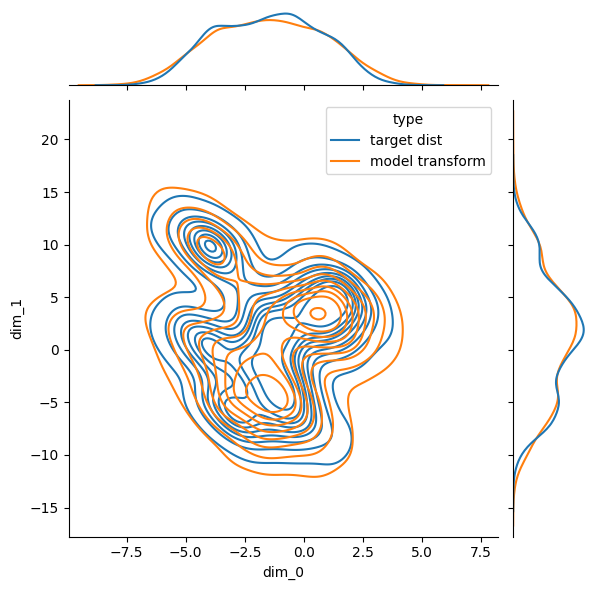

trail: 0 m step: 8 kl_test: 0.9334163665771484


  2%|▏         | 100/6000 [00:31<34:24,  2.86it/s]

trail: 0 m step: 9 Loss: 0.887822151184082  L_n: 0.7995977401733398  kld: 0.008822441101074219 KLD1: 0.7914196848869324 KLD2: 0.4943278729915619


  3%|▎         | 200/6000 [01:02<33:27,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8561344146728516  L_n: 0.7737941741943359  kld: 0.008234024047851562 KLD1: 0.7814597487449646 KLD2: 0.5046335458755493


  5%|▌         | 300/6000 [01:34<33:05,  2.87it/s]

trail: 0 m step: 9 Loss: 0.8582668304443359  L_n: 0.7614212036132812  kld: 0.009684562683105469 KLD1: 0.7425967454910278 KLD2: 0.495834082365036


  7%|▋         | 400/6000 [02:05<32:31,  2.87it/s]

trail: 0 m step: 9 Loss: 0.8303070068359375  L_n: 0.7549953460693359  kld: 0.007531166076660156 KLD1: 0.7783968448638916 KLD2: 0.49281200766563416


  8%|▊         | 500/6000 [02:36<31:48,  2.88it/s]

trail: 0 m step: 9 Loss: 0.845240592956543  L_n: 0.7492151260375977  kld: 0.009602546691894531 KLD1: 0.7838529944419861 KLD2: 0.47438764572143555


 10%|█         | 600/6000 [03:08<31:11,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8602085113525391  L_n: 0.7658138275146484  kld: 0.009439468383789062 KLD1: 0.7763635516166687 KLD2: 0.4910886585712433


 12%|█▏        | 700/6000 [03:39<30:41,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8735237121582031  L_n: 0.7412109375  kld: 0.013231277465820312 KLD1: 0.7338994145393372 KLD2: 0.48086801171302795


 13%|█▎        | 800/6000 [04:10<30:02,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8728818893432617  L_n: 0.764897346496582  kld: 0.010798454284667969 KLD1: 0.7323394417762756 KLD2: 0.48124969005584717


 15%|█▌        | 900/6000 [04:42<29:32,  2.88it/s]

trail: 0 m step: 9 Loss: 0.845489501953125  L_n: 0.7321929931640625  kld: 0.01132965087890625 KLD1: 0.7648034691810608 KLD2: 0.4836229383945465


 17%|█▋        | 1000/6000 [05:13<28:55,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8614358901977539  L_n: 0.7675180435180664  kld: 0.00939178466796875 KLD1: 0.781796932220459 KLD2: 0.5003916621208191


 18%|█▊        | 1100/6000 [05:44<28:12,  2.90it/s]

trail: 0 m step: 9 Loss: 0.8884754180908203  L_n: 0.7577743530273438  kld: 0.013070106506347656 KLD1: 0.7244614362716675 KLD2: 0.47835975885391235


 20%|██        | 1200/6000 [06:16<27:42,  2.89it/s]

trail: 0 m step: 9 Loss: 0.9002475738525391  L_n: 0.7749824523925781  kld: 0.012526512145996094 KLD1: 0.7061889171600342 KLD2: 0.47878924012184143


 22%|██▏       | 1300/6000 [06:47<27:08,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8865203857421875  L_n: 0.7684745788574219  kld: 0.011804580688476562 KLD1: 0.7389623522758484 KLD2: 0.4892934560775757


 23%|██▎       | 1400/6000 [07:18<26:39,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8657875061035156  L_n: 0.7529201507568359  kld: 0.011286735534667969 KLD1: 0.7494710683822632 KLD2: 0.4694616496562958


 25%|██▌       | 1500/6000 [07:50<26:01,  2.88it/s]

trail: 0 m step: 9 Loss: 0.850642204284668  L_n: 0.7398538589477539  kld: 0.011078834533691406 KLD1: 0.7576777935028076 KLD2: 0.4776462912559509


 27%|██▋       | 1600/6000 [08:21<25:27,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8705072402954102  L_n: 0.7636861801147461  kld: 0.010682106018066406 KLD1: 0.7377361059188843 KLD2: 0.47645702958106995


 28%|██▊       | 1700/6000 [08:52<24:48,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8716917037963867  L_n: 0.7491731643676758  kld: 0.012251853942871094 KLD1: 0.7419431209564209 KLD2: 0.47050052881240845


 30%|███       | 1800/6000 [09:24<24:19,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8516025543212891  L_n: 0.7240676879882812  kld: 0.012753486633300781 KLD1: 0.7357667088508606 KLD2: 0.4919692277908325


 32%|███▏      | 1900/6000 [09:55<23:43,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8698139190673828  L_n: 0.7624111175537109  kld: 0.010740280151367188 KLD1: 0.731923520565033 KLD2: 0.4902649223804474


 33%|███▎      | 2000/6000 [10:27<23:05,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8527975082397461  L_n: 0.7617025375366211  kld: 0.0091094970703125 KLD1: 0.7376562356948853 KLD2: 0.4728386700153351


 35%|███▌      | 2100/6000 [10:58<22:31,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8294820785522461  L_n: 0.7325315475463867  kld: 0.009695053100585938 KLD1: 0.761429488658905 KLD2: 0.48420965671539307


 37%|███▋      | 2200/6000 [11:29<21:59,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8629474639892578  L_n: 0.7562313079833984  kld: 0.010671615600585938 KLD1: 0.7282813787460327 KLD2: 0.49008259177207947


 38%|███▊      | 2300/6000 [12:00<21:22,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8394203186035156  L_n: 0.7474479675292969  kld: 0.009197235107421875 KLD1: 0.7596563100814819 KLD2: 0.45821142196655273


 40%|████      | 2400/6000 [12:32<20:51,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8403921127319336  L_n: 0.7273626327514648  kld: 0.011302947998046875 KLD1: 0.7360086441040039 KLD2: 0.4822518527507782


 42%|████▏     | 2500/6000 [13:03<20:16,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8573579788208008  L_n: 0.7428693771362305  kld: 0.011448860168457031 KLD1: 0.7143800854682922 KLD2: 0.4839220643043518


 43%|████▎     | 2600/6000 [13:35<19:40,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8489809036254883  L_n: 0.7599935531616211  kld: 0.008898735046386719 KLD1: 0.7687110304832458 KLD2: 0.4712653160095215


 45%|████▌     | 2700/6000 [14:06<19:08,  2.87it/s]

trail: 0 m step: 9 Loss: 0.817164421081543  L_n: 0.7150449752807617  kld: 0.010211944580078125 KLD1: 0.7406054139137268 KLD2: 0.4682638943195343


 47%|████▋     | 2800/6000 [14:37<18:30,  2.88it/s]

trail: 0 m step: 9 Loss: 0.846196174621582  L_n: 0.7416162490844727  kld: 0.010457992553710938 KLD1: 0.730213463306427 KLD2: 0.4761660099029541


 48%|████▊     | 2900/6000 [15:09<17:55,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8165798187255859  L_n: 0.7360324859619141  kld: 0.008054733276367188 KLD1: 0.7517690658569336 KLD2: 0.47150877118110657


 50%|█████     | 3000/6000 [15:40<17:19,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8749809265136719  L_n: 0.7602157592773438  kld: 0.011476516723632812 KLD1: 0.7353804707527161 KLD2: 0.48000359535217285


 52%|█████▏    | 3100/6000 [16:11<16:47,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8279523849487305  L_n: 0.7520112991333008  kld: 0.007594108581542969 KLD1: 0.7465752959251404 KLD2: 0.4959857165813446


 53%|█████▎    | 3200/6000 [16:42<16:09,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8662385940551758  L_n: 0.7688398361206055  kld: 0.009739875793457031 KLD1: 0.7400755882263184 KLD2: 0.47123396396636963


 55%|█████▌    | 3300/6000 [17:14<15:36,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8395023345947266  L_n: 0.7260150909423828  kld: 0.011348724365234375 KLD1: 0.7216667532920837 KLD2: 0.4733847677707672


 57%|█████▋    | 3400/6000 [17:45<15:02,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8419704437255859  L_n: 0.7536411285400391  kld: 0.008832931518554688 KLD1: 0.7629518508911133 KLD2: 0.4775475561618805


 58%|█████▊    | 3500/6000 [18:16<14:25,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8336820602416992  L_n: 0.7308473587036133  kld: 0.010283470153808594 KLD1: 0.7441954612731934 KLD2: 0.46643006801605225


 60%|██████    | 3600/6000 [18:48<13:53,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8755226135253906  L_n: 0.7480354309082031  kld: 0.01274871826171875 KLD1: 0.7010064721107483 KLD2: 0.46834656596183777


 62%|██████▏   | 3700/6000 [19:19<13:19,  2.88it/s]

trail: 0 m step: 9 Loss: 0.859980583190918  L_n: 0.7541990280151367  kld: 0.010578155517578125 KLD1: 0.7495030164718628 KLD2: 0.4795888066291809


 63%|██████▎   | 3800/6000 [19:51<12:44,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8705892562866211  L_n: 0.7472600936889648  kld: 0.012332916259765625 KLD1: 0.7263370752334595 KLD2: 0.48171600699424744


 65%|██████▌   | 3900/6000 [20:22<12:07,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8479347229003906  L_n: 0.7536258697509766  kld: 0.009430885314941406 KLD1: 0.7536075711250305 KLD2: 0.47568827867507935


 67%|██████▋   | 4000/6000 [20:53<11:35,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8289070129394531  L_n: 0.7181758880615234  kld: 0.011073112487792969 KLD1: 0.7200452089309692 KLD2: 0.472718745470047


 68%|██████▊   | 4100/6000 [21:25<10:59,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8336400985717773  L_n: 0.7416963577270508  kld: 0.009194374084472656 KLD1: 0.7659432888031006 KLD2: 0.4650106728076935


 70%|███████   | 4200/6000 [21:56<10:23,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8452472686767578  L_n: 0.7510242462158203  kld: 0.00942230224609375 KLD1: 0.7479372620582581 KLD2: 0.4719627797603607


 72%|███████▏  | 4300/6000 [22:27<09:50,  2.88it/s]

trail: 0 m step: 9 Loss: 0.844757080078125  L_n: 0.7399101257324219  kld: 0.010484695434570312 KLD1: 0.7211348414421082 KLD2: 0.48465609550476074


 73%|███████▎  | 4400/6000 [22:58<09:14,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8690471649169922  L_n: 0.7490749359130859  kld: 0.011997222900390625 KLD1: 0.7183268666267395 KLD2: 0.48960673809051514


 75%|███████▌  | 4500/6000 [23:30<08:41,  2.88it/s]

trail: 0 m step: 9 Loss: 0.7836847305297852  L_n: 0.6924848556518555  kld: 0.009119987487792969 KLD1: 0.7525327205657959 KLD2: 0.47465330362319946


 77%|███████▋  | 4600/6000 [24:01<08:06,  2.87it/s]

trail: 0 m step: 9 Loss: 0.8575210571289062  L_n: 0.7562980651855469  kld: 0.010122299194335938 KLD1: 0.7357594966888428 KLD2: 0.4879818260669708


 78%|███████▊  | 4700/6000 [24:33<07:31,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8027467727661133  L_n: 0.7403764724731445  kld: 0.006237030029296875 KLD1: 0.7685697078704834 KLD2: 0.4838389456272125


 80%|████████  | 4800/6000 [25:04<06:56,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8294973373413086  L_n: 0.7409582138061523  kld: 0.008853912353515625 KLD1: 0.7382760643959045 KLD2: 0.4882271885871887


 82%|████████▏ | 4900/6000 [25:35<06:20,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8227176666259766  L_n: 0.7349987030029297  kld: 0.008771896362304688 KLD1: 0.7543278932571411 KLD2: 0.4738905727863312


 83%|████████▎ | 5000/6000 [26:07<05:46,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8487691879272461  L_n: 0.7641115188598633  kld: 0.008465766906738281 KLD1: 0.7351834774017334 KLD2: 0.48441845178604126


 85%|████████▌ | 5100/6000 [26:38<05:12,  2.88it/s]

trail: 0 m step: 9 Loss: 0.894413948059082  L_n: 0.7859334945678711  kld: 0.010848045349121094 KLD1: 0.7231978178024292 KLD2: 0.4822062849998474


 87%|████████▋ | 5200/6000 [27:09<04:37,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8225698471069336  L_n: 0.7226629257202148  kld: 0.009990692138671875 KLD1: 0.7319120764732361 KLD2: 0.5052172541618347


 88%|████████▊ | 5300/6000 [27:41<04:03,  2.87it/s]

trail: 0 m step: 9 Loss: 0.819427490234375  L_n: 0.7392234802246094  kld: 0.008020401000976562 KLD1: 0.7680758833885193 KLD2: 0.47703877091407776


 90%|█████████ | 5400/6000 [28:12<03:28,  2.87it/s]

trail: 0 m step: 9 Loss: 0.8559770584106445  L_n: 0.7441587448120117  kld: 0.011181831359863281 KLD1: 0.7198483943939209 KLD2: 0.470356822013855


 92%|█████████▏| 5500/6000 [28:43<02:53,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8517904281616211  L_n: 0.7614870071411133  kld: 0.009030342102050781 KLD1: 0.7395881414413452 KLD2: 0.47803640365600586


 93%|█████████▎| 5600/6000 [29:15<02:18,  2.90it/s]

trail: 0 m step: 9 Loss: 0.8527774810791016  L_n: 0.7507152557373047  kld: 0.010206222534179688 KLD1: 0.7325910925865173 KLD2: 0.47163358330726624


 95%|█████████▌| 5700/6000 [29:46<01:44,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8569831848144531  L_n: 0.7476539611816406  kld: 0.01093292236328125 KLD1: 0.7276782989501953 KLD2: 0.47938889265060425


 97%|█████████▋| 5800/6000 [30:17<01:09,  2.89it/s]

trail: 0 m step: 9 Loss: 0.8318910598754883  L_n: 0.7397661209106445  kld: 0.009212493896484375 KLD1: 0.7547645568847656 KLD2: 0.48295339941978455


 98%|█████████▊| 5900/6000 [30:49<00:34,  2.88it/s]

trail: 0 m step: 9 Loss: 0.8354701995849609  L_n: 0.7435932159423828  kld: 0.009187698364257812 KLD1: 0.7301064133644104 KLD2: 0.4800408184528351


100%|██████████| 6000/6000 [31:20<00:00,  3.19it/s]

trail: 0 m step: 9 Loss: 0.8459081649780273  L_n: 0.7491579055786133  kld: 0.009675025939941406 KLD1: 0.7326151132583618 KLD2: 0.4713401794433594



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


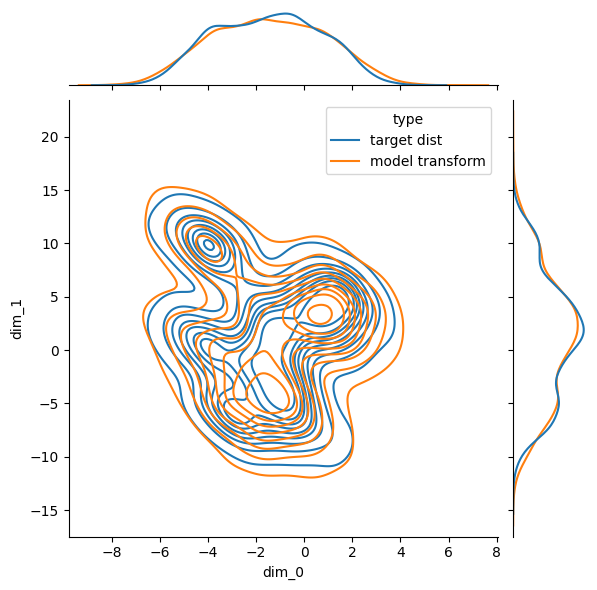

trail: 0 m step: 9 kl_test: 0.7444076538085938


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer_lr_input = optimizer_lr * (outer_lr_factor**mirror_itr)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


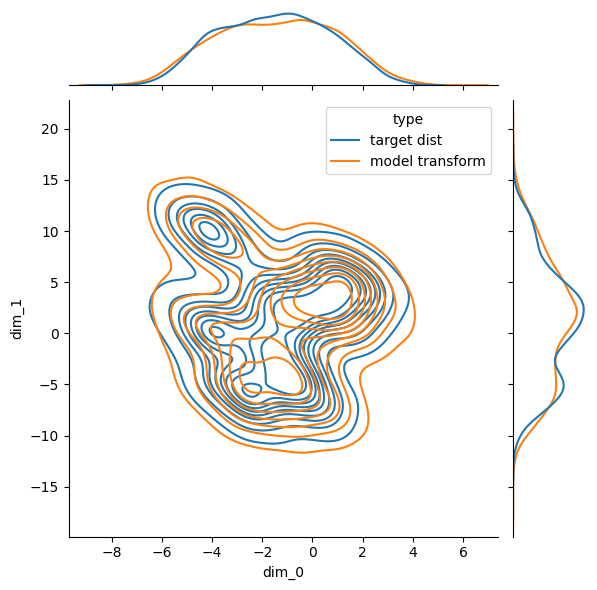

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:31<34:40,  2.84it/s]

trail: 0 m step: 0 Loss: 0.7140884399414062  L_n: 0.6457004547119141  kld: 0.006838798522949219 KLD1: 0.624162495136261 KLD2: 0.4090721011161804


  3%|▎         | 200/6000 [01:03<33:18,  2.90it/s]

trail: 0 m step: 0 Loss: 0.6632242202758789  L_n: 0.6129083633422852  kld: 0.005031585693359375 KLD1: 0.6229470372200012 KLD2: 0.41943320631980896


  5%|▌         | 300/6000 [01:34<32:55,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6739482879638672  L_n: 0.6022796630859375  kld: 0.007166862487792969 KLD1: 0.5969460010528564 KLD2: 0.4072379469871521


  7%|▋         | 400/6000 [02:05<32:25,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6807851791381836  L_n: 0.6064748764038086  kld: 0.0074310302734375 KLD1: 0.6128873825073242 KLD2: 0.4055421054363251


  8%|▊         | 500/6000 [02:36<31:44,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6678533554077148  L_n: 0.5972623825073242  kld: 0.0070590972900390625 KLD1: 0.6282610297203064 KLD2: 0.3864683210849762


 10%|█         | 600/6000 [03:08<31:19,  2.87it/s]

trail: 0 m step: 0 Loss: 0.6914749145507812  L_n: 0.6181564331054688  kld: 0.00733184814453125 KLD1: 0.6229782700538635 KLD2: 0.40244174003601074


 12%|█▏        | 700/6000 [03:39<30:38,  2.88it/s]

trail: 0 m step: 0 Loss: 0.7067394256591797  L_n: 0.5913829803466797  kld: 0.01153564453125 KLD1: 0.5921461582183838 KLD2: 0.39532026648521423


 13%|█▎        | 800/6000 [04:10<30:00,  2.89it/s]

trail: 0 m step: 0 Loss: 0.7070598602294922  L_n: 0.6190166473388672  kld: 0.0088043212890625 KLD1: 0.579279363155365 KLD2: 0.39397019147872925


 15%|█▌        | 900/6000 [04:42<29:28,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6892204284667969  L_n: 0.5961418151855469  kld: 0.009307861328125 KLD1: 0.6111650466918945 KLD2: 0.3968074917793274


 17%|█▋        | 1000/6000 [05:13<28:52,  2.89it/s]

trail: 0 m step: 0 Loss: 0.680506706237793  L_n: 0.612462043762207  kld: 0.006804466247558594 KLD1: 0.6311815977096558 KLD2: 0.41190439462661743


 18%|█▊        | 1100/6000 [05:44<28:24,  2.88it/s]

trail: 0 m step: 0 Loss: 0.710566520690918  L_n: 0.6014471054077148  kld: 0.010911941528320312 KLD1: 0.5789161920547485 KLD2: 0.38999247550964355


 20%|██        | 1200/6000 [06:16<27:47,  2.88it/s]

trail: 0 m step: 0 Loss: 0.7124319076538086  L_n: 0.6215181350708008  kld: 0.009091377258300781 KLD1: 0.5899926424026489 KLD2: 0.39417967200279236


 22%|██▏       | 1300/6000 [06:47<27:09,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6936426162719727  L_n: 0.6057233810424805  kld: 0.008791923522949219 KLD1: 0.5967599153518677 KLD2: 0.39873337745666504


 23%|██▎       | 1400/6000 [07:18<26:33,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6890964508056641  L_n: 0.5978107452392578  kld: 0.009128570556640625 KLD1: 0.6052111983299255 KLD2: 0.38780349493026733


 25%|██▌       | 1500/6000 [07:50<26:02,  2.88it/s]

trail: 0 m step: 0 Loss: 0.682744026184082  L_n: 0.5853357315063477  kld: 0.009740829467773438 KLD1: 0.6024433374404907 KLD2: 0.39263272285461426


 27%|██▋       | 1600/6000 [08:21<25:29,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6941251754760742  L_n: 0.5985097885131836  kld: 0.009561538696289062 KLD1: 0.5823246240615845 KLD2: 0.3945316672325134


 28%|██▊       | 1700/6000 [08:52<24:50,  2.88it/s]

trail: 0 m step: 0 Loss: 0.702143669128418  L_n: 0.6072721481323242  kld: 0.009487152099609375 KLD1: 0.5892823338508606 KLD2: 0.3901645839214325


 30%|███       | 1800/6000 [09:24<24:15,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6812009811401367  L_n: 0.5852422714233398  kld: 0.009595870971679688 KLD1: 0.6050253510475159 KLD2: 0.40823468565940857


 32%|███▏      | 1900/6000 [09:55<23:40,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6885709762573242  L_n: 0.6130971908569336  kld: 0.0075473785400390625 KLD1: 0.6008702516555786 KLD2: 0.40636318922042847


 33%|███▎      | 2000/6000 [10:26<23:06,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6807279586791992  L_n: 0.5945062637329102  kld: 0.008622169494628906 KLD1: 0.5946839451789856 KLD2: 0.38360071182250977


 35%|███▌      | 2100/6000 [10:57<22:29,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6493053436279297  L_n: 0.5789718627929688  kld: 0.007033348083496094 KLD1: 0.6153569221496582 KLD2: 0.3990500569343567


 37%|███▋      | 2200/6000 [11:29<21:53,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6845760345458984  L_n: 0.5969142913818359  kld: 0.00876617431640625 KLD1: 0.5796909928321838 KLD2: 0.40436163544654846


 38%|███▊      | 2300/6000 [12:00<21:19,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6695690155029297  L_n: 0.5963077545166016  kld: 0.0073261260986328125 KLD1: 0.612589418888092 KLD2: 0.37458163499832153


 40%|████      | 2400/6000 [12:31<20:45,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6793804168701172  L_n: 0.589019775390625  kld: 0.009036064147949219 KLD1: 0.5918733477592468 KLD2: 0.3965757191181183


 42%|████▏     | 2500/6000 [13:03<20:09,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6927394866943359  L_n: 0.6004810333251953  kld: 0.009225845336914062 KLD1: 0.5869802832603455 KLD2: 0.39742377400398254


 43%|████▎     | 2600/6000 [13:34<19:37,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6787614822387695  L_n: 0.6137685775756836  kld: 0.006499290466308594 KLD1: 0.6161407828330994 KLD2: 0.387007474899292


 45%|████▌     | 2700/6000 [14:05<19:03,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6583595275878906  L_n: 0.5788898468017578  kld: 0.007946968078613281 KLD1: 0.5840604305267334 KLD2: 0.3810000717639923


 47%|████▋     | 2800/6000 [14:36<18:29,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6741933822631836  L_n: 0.5986623764038086  kld: 0.0075531005859375 KLD1: 0.5841485261917114 KLD2: 0.3932386040687561


 48%|████▊     | 2900/6000 [15:08<17:55,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6469154357910156  L_n: 0.5872631072998047  kld: 0.005965232849121094 KLD1: 0.5937804579734802 KLD2: 0.3883107900619507


 50%|█████     | 3000/6000 [15:39<17:17,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6899538040161133  L_n: 0.6030645370483398  kld: 0.008688926696777344 KLD1: 0.587966799736023 KLD2: 0.3967500627040863


 52%|█████▏    | 3100/6000 [16:10<16:45,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6721105575561523  L_n: 0.6210794448852539  kld: 0.005103111267089844 KLD1: 0.600351870059967 KLD2: 0.4116501212120056


 53%|█████▎    | 3200/6000 [16:42<16:10,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6939191818237305  L_n: 0.6155843734741211  kld: 0.007833480834960938 KLD1: 0.5867592692375183 KLD2: 0.3881087899208069


 55%|█████▌    | 3300/6000 [17:13<15:34,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6723012924194336  L_n: 0.5896463394165039  kld: 0.008265495300292969 KLD1: 0.5716935396194458 KLD2: 0.3894106149673462


 57%|█████▋    | 3400/6000 [17:44<15:02,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6785802841186523  L_n: 0.6074838638305664  kld: 0.007109642028808594 KLD1: 0.6062805652618408 KLD2: 0.39221885800361633


 58%|█████▊    | 3500/6000 [18:16<14:25,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6741561889648438  L_n: 0.5969657897949219  kld: 0.0077190399169921875 KLD1: 0.5875280499458313 KLD2: 0.38312429189682007


 60%|██████    | 3600/6000 [18:47<13:48,  2.90it/s]

trail: 0 m step: 0 Loss: 0.7048397064208984  L_n: 0.5963401794433594  kld: 0.010849952697753906 KLD1: 0.5625708103179932 KLD2: 0.38522571325302124


 62%|██████▏   | 3700/6000 [19:18<13:17,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6996660232543945  L_n: 0.6143407821655273  kld: 0.008532524108886719 KLD1: 0.5901970267295837 KLD2: 0.3962348997592926


 63%|██████▎   | 3800/6000 [19:49<12:42,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6824560165405273  L_n: 0.5880231857299805  kld: 0.009443283081054688 KLD1: 0.5772168040275574 KLD2: 0.3965858221054077


 65%|██████▌   | 3900/6000 [20:21<12:06,  2.89it/s]

trail: 0 m step: 0 Loss: 0.690485954284668  L_n: 0.6139249801635742  kld: 0.007656097412109375 KLD1: 0.6162601113319397 KLD2: 0.3932547867298126


 67%|██████▋   | 4000/6000 [20:52<11:29,  2.90it/s]

trail: 0 m step: 0 Loss: 0.65087890625  L_n: 0.5670127868652344  kld: 0.008386611938476562 KLD1: 0.5860387682914734 KLD2: 0.38851869106292725


 68%|██████▊   | 4100/6000 [21:23<10:58,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6683835983276367  L_n: 0.5959615707397461  kld: 0.0072422027587890625 KLD1: 0.6111710071563721 KLD2: 0.3811900317668915


 70%|███████   | 4200/6000 [21:54<10:21,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6820640563964844  L_n: 0.6088027954101562  kld: 0.0073261260986328125 KLD1: 0.5926662683486938 KLD2: 0.38762038946151733


 72%|███████▏  | 4300/6000 [22:26<09:48,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6632108688354492  L_n: 0.5885190963745117  kld: 0.00746917724609375 KLD1: 0.5766792893409729 KLD2: 0.3990721106529236


 73%|███████▎  | 4400/6000 [22:57<09:14,  2.89it/s]

trail: 0 m step: 0 Loss: 0.7046804428100586  L_n: 0.6110391616821289  kld: 0.009364128112792969 KLD1: 0.5768512487411499 KLD2: 0.40265145897865295


 75%|███████▌  | 4500/6000 [23:28<08:40,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6305522918701172  L_n: 0.5641670227050781  kld: 0.006638526916503906 KLD1: 0.5940360426902771 KLD2: 0.3916085958480835


 77%|███████▋  | 4600/6000 [24:00<08:04,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6912965774536133  L_n: 0.6090517044067383  kld: 0.0082244873046875 KLD1: 0.5935205221176147 KLD2: 0.4014679193496704


 78%|███████▊  | 4700/6000 [24:31<07:30,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6386280059814453  L_n: 0.5967044830322266  kld: 0.004192352294921875 KLD1: 0.6084066033363342 KLD2: 0.3978528082370758


 80%|████████  | 4800/6000 [25:02<06:57,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6595821380615234  L_n: 0.5945510864257812  kld: 0.006503105163574219 KLD1: 0.6008438467979431 KLD2: 0.4047929048538208


 82%|████████▏ | 4900/6000 [25:33<06:21,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6456680297851562  L_n: 0.5841655731201172  kld: 0.006150245666503906 KLD1: 0.6085742115974426 KLD2: 0.39169812202453613


 83%|████████▎ | 5000/6000 [26:05<05:45,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6895017623901367  L_n: 0.6201314926147461  kld: 0.0069370269775390625 KLD1: 0.5851737260818481 KLD2: 0.39990243315696716


 85%|████████▌ | 5100/6000 [26:36<05:10,  2.90it/s]

trail: 0 m step: 0 Loss: 0.734135627746582  L_n: 0.6459684371948242  kld: 0.008816719055175781 KLD1: 0.5794955492019653 KLD2: 0.3995227515697479


 87%|████████▋ | 5200/6000 [27:07<04:36,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6568937301635742  L_n: 0.581019401550293  kld: 0.007587432861328125 KLD1: 0.5900641083717346 KLD2: 0.4199635684490204


 88%|████████▊ | 5300/6000 [27:39<04:02,  2.89it/s]

trail: 0 m step: 0 Loss: 0.65240478515625  L_n: 0.5957183837890625  kld: 0.00566864013671875 KLD1: 0.6167000532150269 KLD2: 0.392996221780777


 90%|█████████ | 5400/6000 [28:10<03:27,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6876287460327148  L_n: 0.6016263961791992  kld: 0.008600234985351562 KLD1: 0.5864033699035645 KLD2: 0.3878915011882782


 92%|█████████▏| 5500/6000 [28:41<02:53,  2.88it/s]

trail: 0 m step: 0 Loss: 0.686518669128418  L_n: 0.621678352355957  kld: 0.006484031677246094 KLD1: 0.5998184680938721 KLD2: 0.3947485387325287


 93%|█████████▎| 5600/6000 [29:12<02:18,  2.88it/s]

trail: 0 m step: 0 Loss: 0.6839628219604492  L_n: 0.6041879653930664  kld: 0.007977485656738281 KLD1: 0.5720886588096619 KLD2: 0.39012107253074646


 95%|█████████▌| 5700/6000 [29:44<01:44,  2.88it/s]

trail: 0 m step: 0 Loss: 0.686131477355957  L_n: 0.5953130722045898  kld: 0.009081840515136719 KLD1: 0.5708853602409363 KLD2: 0.39488062262535095


 97%|█████████▋| 5800/6000 [30:15<01:08,  2.90it/s]

trail: 0 m step: 0 Loss: 0.6776371002197266  L_n: 0.6036796569824219  kld: 0.007395744323730469 KLD1: 0.6081931591033936 KLD2: 0.39734604954719543


 98%|█████████▊| 5900/6000 [30:46<00:34,  2.89it/s]

trail: 0 m step: 0 Loss: 0.6644649505615234  L_n: 0.5873031616210938  kld: 0.007716178894042969 KLD1: 0.5777361989021301 KLD2: 0.39534667134284973


100%|██████████| 6000/6000 [31:17<00:00,  3.20it/s]

trail: 0 m step: 0 Loss: 0.669001579284668  L_n: 0.5966367721557617  kld: 0.007236480712890625 KLD1: 0.597869336605072 KLD2: 0.3862614035606384



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


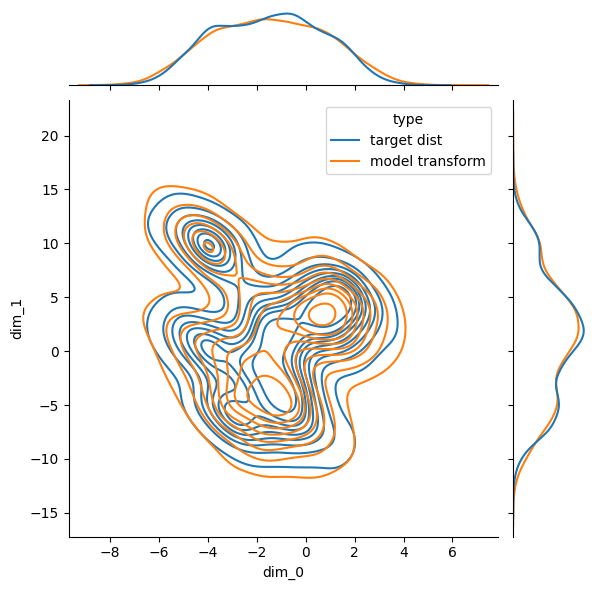

trail: 0 m step: 0 kl_test: 0.5947656631469727


  2%|▏         | 100/6000 [00:31<34:25,  2.86it/s]

trail: 0 m step: 1 Loss: 0.5621441327608548  L_n: 0.4956216812133789  kld: 0.008647918701171875 KLD1: 0.4713069200515747 KLD2: 0.32092753052711487


  3%|▎         | 200/6000 [01:02<33:18,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5379877824049729  L_n: 0.4814128875732422  kld: 0.007354736328125 KLD1: 0.48775044083595276 KLD2: 0.3318485617637634


  5%|▌         | 300/6000 [01:33<32:52,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5275013997004583  L_n: 0.45522022247314453  kld: 0.009396553039550781 KLD1: 0.46962770819664 KLD2: 0.31961047649383545


  7%|▋         | 400/6000 [02:05<32:18,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5360336303710938  L_n: 0.4720420837402344  kld: 0.008318901062011719 KLD1: 0.4565763473510742 KLD2: 0.32050296664237976


  8%|▊         | 500/6000 [02:36<31:32,  2.91it/s]

trail: 0 m step: 1 Loss: 0.5323440111600436  L_n: 0.47002506256103516  kld: 0.008101463317871094 KLD1: 0.49163153767585754 KLD2: 0.3067447543144226


 10%|█         | 600/6000 [03:07<31:04,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5473770728478065  L_n: 0.4778175354003906  kld: 0.009042739868164062 KLD1: 0.47661659121513367 KLD2: 0.3173539638519287


 12%|█▏        | 700/6000 [03:38<30:36,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5462754322932317  L_n: 0.44462108612060547  kld: 0.013215065002441406 KLD1: 0.4469611346721649 KLD2: 0.3106091320514679


 13%|█▎        | 800/6000 [04:10<30:01,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5553972537700946  L_n: 0.4713125228881836  kld: 0.010931015014648438 KLD1: 0.4592532217502594 KLD2: 0.30696606636047363


 15%|█▌        | 900/6000 [04:41<29:25,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5492272010216346  L_n: 0.4673652648925781  kld: 0.010642051696777344 KLD1: 0.47076404094696045 KLD2: 0.31241080164909363


 17%|█▋        | 1000/6000 [05:12<28:56,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5389397694514348  L_n: 0.47877025604248047  kld: 0.007822036743164062 KLD1: 0.48338088393211365 KLD2: 0.3239147365093231


 18%|█▊        | 1100/6000 [05:44<28:13,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5550113091102014  L_n: 0.46044349670410156  kld: 0.012293815612792969 KLD1: 0.44661766290664673 KLD2: 0.30731603503227234


 20%|██        | 1200/6000 [06:15<27:35,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5690989861121545  L_n: 0.4788227081298828  kld: 0.011735916137695312 KLD1: 0.4463186264038086 KLD2: 0.3089059889316559


 22%|██▏       | 1300/6000 [06:46<27:02,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5611570064838116  L_n: 0.46242237091064453  kld: 0.012835502624511719 KLD1: 0.4564605951309204 KLD2: 0.31324297189712524


 23%|██▎       | 1400/6000 [07:17<26:28,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5637587033785306  L_n: 0.4743480682373047  kld: 0.011623382568359375 KLD1: 0.46081191301345825 KLD2: 0.30438119173049927


 25%|██▌       | 1500/6000 [07:49<25:54,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5366114836472731  L_n: 0.4501352310180664  kld: 0.011241912841796875 KLD1: 0.4588782489299774 KLD2: 0.30758652091026306


 27%|██▋       | 1600/6000 [08:20<25:21,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5667585959801307  L_n: 0.4776487350463867  kld: 0.011584281921386719 KLD1: 0.45277518033981323 KLD2: 0.3080941438674927


 28%|██▊       | 1700/6000 [08:51<24:47,  2.89it/s]

trail: 0 m step: 1 Loss: 0.558161368736854  L_n: 0.46662330627441406  kld: 0.011899948120117188 KLD1: 0.44620534777641296 KLD2: 0.30360591411590576


 30%|███       | 1800/6000 [09:22<24:15,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5390729904174805  L_n: 0.4476156234741211  kld: 0.011889457702636719 KLD1: 0.43625354766845703 KLD2: 0.32018759846687317


 32%|███▏      | 1900/6000 [09:54<23:38,  2.89it/s]

trail: 0 m step: 1 Loss: 0.543701905470628  L_n: 0.4672832489013672  kld: 0.009934425354003906 KLD1: 0.4563519060611725 KLD2: 0.32330992817878723


 33%|███▎      | 2000/6000 [10:25<23:05,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5469457186185397  L_n: 0.48462677001953125  kld: 0.008101463317871094 KLD1: 0.46153905987739563 KLD2: 0.30315086245536804


 35%|███▌      | 2100/6000 [10:56<22:29,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5089826583862305  L_n: 0.44975948333740234  kld: 0.007699012756347656 KLD1: 0.4908280074596405 KLD2: 0.31336814165115356


 37%|███▋      | 2200/6000 [11:28<21:59,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5563672872690054  L_n: 0.4808216094970703  kld: 0.009820938110351562 KLD1: 0.4508882761001587 KLD2: 0.3194541931152344


 38%|███▊      | 2300/6000 [11:59<21:18,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5191753827608548  L_n: 0.45322513580322266  kld: 0.008573532104492188 KLD1: 0.4717490077018738 KLD2: 0.2935466170310974


 40%|████      | 2400/6000 [12:30<20:47,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5292247625497671  L_n: 0.4519624710083008  kld: 0.010044097900390625 KLD1: 0.4609193205833435 KLD2: 0.31274211406707764


 42%|████▏     | 2500/6000 [13:02<20:07,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5489484346829928  L_n: 0.4654579162597656  kld: 0.010853767395019531 KLD1: 0.44114118814468384 KLD2: 0.314118891954422


 43%|████▎     | 2600/6000 [13:33<19:39,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5416316252488357  L_n: 0.4756593704223633  kld: 0.008576393127441406 KLD1: 0.477806955575943 KLD2: 0.3055543899536133


 45%|████▌     | 2700/6000 [14:04<19:00,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5156536102294922  L_n: 0.44307899475097656  kld: 0.009434700012207031 KLD1: 0.4428247809410095 KLD2: 0.2969655394554138


 47%|████▋     | 2800/6000 [14:35<18:27,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5336509117713342  L_n: 0.45424652099609375  kld: 0.01032257080078125 KLD1: 0.45078688859939575 KLD2: 0.3085308372974396


 48%|████▊     | 2900/6000 [15:07<17:51,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5121675638052133  L_n: 0.45114707946777344  kld: 0.007932662963867188 KLD1: 0.4578036367893219 KLD2: 0.30459025502204895


 50%|█████     | 3000/6000 [15:38<17:14,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5372015146108774  L_n: 0.4526252746582031  kld: 0.010994911193847656 KLD1: 0.45099568367004395 KLD2: 0.3128410875797272


 52%|█████▏    | 3100/6000 [16:09<16:41,  2.90it/s]

trail: 0 m step: 1 Loss: 0.5166996442354642  L_n: 0.45694828033447266  kld: 0.007767677307128906 KLD1: 0.4482780992984772 KLD2: 0.32326191663742065


 53%|█████▎    | 3200/6000 [16:40<16:09,  2.89it/s]

trail: 0 m step: 1 Loss: 0.547734260559082  L_n: 0.4716310501098633  kld: 0.009893417358398438 KLD1: 0.4516732394695282 KLD2: 0.30492356419563293


 55%|█████▌    | 3300/6000 [17:12<15:32,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5215673446655273  L_n: 0.44002819061279297  kld: 0.010600090026855469 KLD1: 0.44126415252685547 KLD2: 0.30723780393600464


 57%|█████▋    | 3400/6000 [17:43<14:59,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5255531164316031  L_n: 0.4626913070678711  kld: 0.008172035217285156 KLD1: 0.4770944118499756 KLD2: 0.31086111068725586


 58%|█████▊    | 3500/6000 [18:14<14:24,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5121885446401743  L_n: 0.4404869079589844  kld: 0.009321212768554688 KLD1: 0.4569641351699829 KLD2: 0.3018993139266968


 60%|██████    | 3600/6000 [18:46<13:49,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5502257713904748  L_n: 0.4593772888183594  kld: 0.011810302734375 KLD1: 0.42485272884368896 KLD2: 0.3027430474758148


 62%|██████▏   | 3700/6000 [19:17<13:15,  2.89it/s]

trail: 0 m step: 1 Loss: 0.53814513866718  L_n: 0.4655485153198242  kld: 0.00943756103515625 KLD1: 0.4593289792537689 KLD2: 0.31239810585975647


 63%|██████▎   | 3800/6000 [19:48<12:41,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5385233805729792  L_n: 0.4561185836791992  kld: 0.010712623596191406 KLD1: 0.44814422726631165 KLD2: 0.3115129768848419


 65%|██████▌   | 3900/6000 [20:19<12:04,  2.90it/s]

trail: 0 m step: 1 Loss: 0.536296771122859  L_n: 0.46135997772216797  kld: 0.009741783142089844 KLD1: 0.45774906873703003 KLD2: 0.3074526786804199


 67%|██████▋   | 4000/6000 [20:51<11:33,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5089627779447116  L_n: 0.43491363525390625  kld: 0.009626388549804688 KLD1: 0.45015251636505127 KLD2: 0.3040170669555664


 68%|██████▊   | 4100/6000 [21:22<10:57,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5090495623075045  L_n: 0.4403409957885742  kld: 0.008932113647460938 KLD1: 0.46064406633377075 KLD2: 0.298769474029541


 70%|███████   | 4200/6000 [21:53<10:22,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5324344635009766  L_n: 0.4653911590576172  kld: 0.008715629577636719 KLD1: 0.4583874046802521 KLD2: 0.3044402003288269


 72%|███████▏  | 4300/6000 [22:25<09:48,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5259841038630559  L_n: 0.4544658660888672  kld: 0.009297370910644531 KLD1: 0.43303993344306946 KLD2: 0.315143346786499


 73%|███████▎  | 4400/6000 [22:56<09:14,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5601092852078952  L_n: 0.4812917709350586  kld: 0.01024627685546875 KLD1: 0.4430978298187256 KLD2: 0.31919384002685547


 75%|███████▌  | 4500/6000 [23:27<08:39,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4881770060612605  L_n: 0.4291372299194336  kld: 0.0076751708984375 KLD1: 0.46079984307289124 KLD2: 0.3096981942653656


 77%|███████▋  | 4600/6000 [23:58<08:06,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5284877923818735  L_n: 0.4568815231323242  kld: 0.009308815002441406 KLD1: 0.4578319191932678 KLD2: 0.31802383065223694


 78%|███████▊  | 4700/6000 [24:30<07:30,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5063911584707407  L_n: 0.46129703521728516  kld: 0.005862236022949219 KLD1: 0.47689157724380493 KLD2: 0.31372153759002686


 80%|████████  | 4800/6000 [25:01<06:56,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5209344717172476  L_n: 0.459503173828125  kld: 0.007986068725585938 KLD1: 0.45318832993507385 KLD2: 0.3185664117336273


 82%|████████▏ | 4900/6000 [25:32<06:21,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4884932591364934  L_n: 0.43709754943847656  kld: 0.0066814422607421875 KLD1: 0.4718165993690491 KLD2: 0.308638334274292


 83%|████████▎ | 5000/6000 [26:04<05:46,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5275274423452524  L_n: 0.46555328369140625  kld: 0.008056640625 KLD1: 0.4455782175064087 KLD2: 0.31550344824790955


 85%|████████▌ | 5100/6000 [26:35<05:11,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5658956674429086  L_n: 0.4913330078125  kld: 0.009693145751953125 KLD1: 0.4437949061393738 KLD2: 0.3148359954357147


 87%|████████▋ | 5200/6000 [27:06<04:37,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5145945182213416  L_n: 0.44303226470947266  kld: 0.009303092956542969 KLD1: 0.4488556981086731 KLD2: 0.3338356018066406


 88%|████████▊ | 5300/6000 [27:38<04:02,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5017837377694937  L_n: 0.4442625045776367  kld: 0.007477760314941406 KLD1: 0.47081658244132996 KLD2: 0.3092849552631378


 90%|█████████ | 5400/6000 [28:09<03:27,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5316792268019456  L_n: 0.45336055755615234  kld: 0.010181427001953125 KLD1: 0.43962493538856506 KLD2: 0.30603423714637756


 92%|█████████▏| 5500/6000 [28:40<02:53,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5373593843900241  L_n: 0.4765663146972656  kld: 0.007903099060058594 KLD1: 0.46558696031570435 KLD2: 0.3110157251358032


 93%|█████████▎| 5600/6000 [29:12<02:18,  2.88it/s]

trail: 0 m step: 1 Loss: 0.5208921432495117  L_n: 0.4476499557495117  kld: 0.009521484375 KLD1: 0.4377097487449646 KLD2: 0.30616968870162964


 95%|█████████▌| 5700/6000 [29:43<01:43,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5267893717839167  L_n: 0.44982051849365234  kld: 0.010005950927734375 KLD1: 0.43401482701301575 KLD2: 0.3113502264022827


 97%|█████████▋| 5800/6000 [30:14<01:09,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5246235774113581  L_n: 0.4595756530761719  kld: 0.008456230163574219 KLD1: 0.46838513016700745 KLD2: 0.31447547674179077


 98%|█████████▊| 5900/6000 [30:45<00:34,  2.89it/s]

trail: 0 m step: 1 Loss: 0.5149126052856445  L_n: 0.44786930084228516  kld: 0.008715629577636719 KLD1: 0.44714364409446716 KLD2: 0.31167903542518616


100%|██████████| 6000/6000 [31:17<00:00,  3.20it/s]

trail: 0 m step: 1 Loss: 0.5158711946927584  L_n: 0.4524078369140625  kld: 0.008250236511230469 KLD1: 0.4571194648742676 KLD2: 0.3020745515823364



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


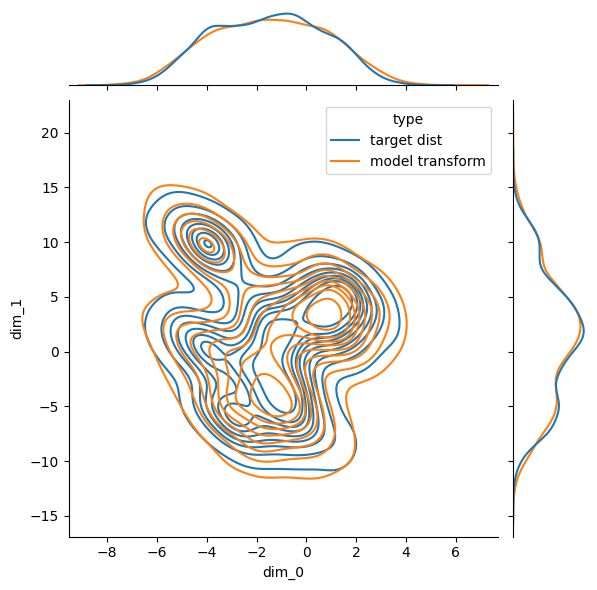

trail: 0 m step: 1 kl_test: 0.4483022689819336


  2%|▏         | 100/6000 [00:31<34:28,  2.85it/s]

trail: 0 m step: 2 Loss: 0.4228289564685708  L_n: 0.3631763458251953  kld: 0.010081291198730469 KLD1: 0.34739047288894653 KLD2: 0.24024689197540283


  3%|▎         | 200/6000 [01:02<33:24,  2.89it/s]

trail: 0 m step: 2 Loss: 0.4134540445000462  L_n: 0.3582763671875  kld: 0.009325027465820312 KLD1: 0.362324982881546 KLD2: 0.25145137310028076


  5%|▌         | 300/6000 [01:34<33:01,  2.88it/s]

trail: 0 m step: 2 Loss: 0.40999026552459894  L_n: 0.3428211212158203  kld: 0.011351585388183594 KLD1: 0.3357374668121338 KLD2: 0.24394789338111877


  7%|▋         | 400/6000 [02:05<32:22,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4057811082467525  L_n: 0.3514442443847656  kld: 0.009182929992675781 KLD1: 0.34431585669517517 KLD2: 0.24185685813426971


  8%|▊         | 500/6000 [02:36<31:42,  2.89it/s]

trail: 0 m step: 2 Loss: 0.41038144128562426  L_n: 0.35262489318847656  kld: 0.009760856628417969 KLD1: 0.3520413041114807 KLD2: 0.23230500519275665


 10%|█         | 600/6000 [03:08<31:06,  2.89it/s]

trail: 0 m step: 2 Loss: 0.42086327569724535  L_n: 0.3621530532836914  kld: 0.009922027587890625 KLD1: 0.3604191541671753 KLD2: 0.24281051754951477


 12%|█▏        | 700/6000 [03:39<30:37,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4176929011147403  L_n: 0.3299379348754883  kld: 0.014830589294433594 KLD1: 0.31623291969299316 KLD2: 0.23357532918453217


 13%|█▎        | 800/6000 [04:10<30:04,  2.88it/s]

trail: 0 m step: 2 Loss: 0.41850755905963966  L_n: 0.34813880920410156  kld: 0.011892318725585938 KLD1: 0.3210964798927307 KLD2: 0.22901274263858795


 15%|█▌        | 900/6000 [04:42<29:37,  2.87it/s]

trail: 0 m step: 2 Loss: 0.40361345731295073  L_n: 0.3362693786621094  kld: 0.011381149291992188 KLD1: 0.34278634190559387 KLD2: 0.23446974158287048


 17%|█▋        | 1000/6000 [05:13<28:58,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4022412046172915  L_n: 0.3500938415527344  kld: 0.008812904357910156 KLD1: 0.35701921582221985 KLD2: 0.24809247255325317


 18%|█▊        | 1100/6000 [05:45<28:18,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4157803100947092  L_n: 0.3451576232910156  kld: 0.011935234069824219 KLD1: 0.33426204323768616 KLD2: 0.2316315919160843


 20%|██        | 1200/6000 [06:16<27:42,  2.89it/s]

trail: 0 m step: 2 Loss: 0.42961123426990394  L_n: 0.34630298614501953  kld: 0.014079093933105469 KLD1: 0.32635873556137085 KLD2: 0.23533710837364197


 22%|██▏       | 1300/6000 [06:47<27:11,  2.88it/s]

trail: 0 m step: 2 Loss: 0.40315071083384857  L_n: 0.33551883697509766  kld: 0.011429786682128906 KLD1: 0.33041903376579285 KLD2: 0.23802492022514343


 23%|██▎       | 1400/6000 [07:18<26:35,  2.88it/s]

trail: 0 m step: 2 Loss: 0.42502151015242173  L_n: 0.3465719223022461  kld: 0.013257980346679688 KLD1: 0.33857256174087524 KLD2: 0.22920536994934082


 25%|██▌       | 1500/6000 [07:50<26:06,  2.87it/s]

trail: 0 m step: 2 Loss: 0.4065124692296135  L_n: 0.33438873291015625  kld: 0.012188911437988281 KLD1: 0.3341986835002899 KLD2: 0.23168763518333435


 27%|██▋       | 1600/6000 [08:21<25:25,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4197991388083915  L_n: 0.34577369689941406  kld: 0.012510299682617188 KLD1: 0.33409079909324646 KLD2: 0.2331816405057907


 28%|██▊       | 1700/6000 [08:52<24:48,  2.89it/s]

trail: 0 m step: 2 Loss: 0.41365754392725473  L_n: 0.3426342010498047  kld: 0.012002944946289062 KLD1: 0.32781121134757996 KLD2: 0.22702933847904205


 30%|███       | 1800/6000 [09:24<24:13,  2.89it/s]

trail: 0 m step: 2 Loss: 0.4113159066826634  L_n: 0.33420372009277344  kld: 0.013031959533691406 KLD1: 0.3322417736053467 KLD2: 0.24287809431552887


 32%|███▏      | 1900/6000 [09:55<23:44,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4090575438279372  L_n: 0.34508800506591797  kld: 0.01081085205078125 KLD1: 0.3423161506652832 KLD2: 0.2427482157945633


 33%|███▎      | 2000/6000 [10:26<23:10,  2.88it/s]

trail: 0 m step: 2 Loss: 0.41423529562865485  L_n: 0.3443574905395508  kld: 0.011809349060058594 KLD1: 0.34009304642677307 KLD2: 0.22920583188533783


 35%|███▌      | 2100/6000 [10:58<22:31,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3789081460625462  L_n: 0.32277679443359375  kld: 0.009486198425292969 KLD1: 0.3461078107357025 KLD2: 0.23560982942581177


 37%|███▋      | 2200/6000 [11:29<21:59,  2.88it/s]

trail: 0 m step: 2 Loss: 0.40576807845979046  L_n: 0.33803462982177734  kld: 0.011446952819824219 KLD1: 0.32829999923706055 KLD2: 0.24050937592983246


 38%|███▊      | 2300/6000 [12:00<21:23,  2.88it/s]

trail: 0 m step: 2 Loss: 0.387469432763094  L_n: 0.3285560607910156  kld: 0.00995635986328125 KLD1: 0.35023000836372375 KLD2: 0.22052721679210663


 40%|████      | 2400/6000 [12:32<20:51,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3914112677940955  L_n: 0.3222332000732422  kld: 0.011691093444824219 KLD1: 0.3276757597923279 KLD2: 0.2355940341949463


 42%|████▏     | 2500/6000 [13:03<20:16,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4217292740500185  L_n: 0.34606170654296875  kld: 0.012787818908691406 KLD1: 0.31737372279167175 KLD2: 0.23711161315441132


 43%|████▎     | 2600/6000 [13:34<19:37,  2.89it/s]

trail: 0 m step: 2 Loss: 0.40954680696747003  L_n: 0.3557291030883789  kld: 0.009095191955566406 KLD1: 0.34847334027290344 KLD2: 0.22808808088302612


 45%|████▌     | 2700/6000 [14:06<19:05,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3904564930842473  L_n: 0.33257579803466797  kld: 0.009781837463378906 KLD1: 0.33266523480415344 KLD2: 0.22571156919002533


 47%|████▋     | 2800/6000 [14:37<18:32,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4247312432915501  L_n: 0.35524845123291016  kld: 0.011742591857910156 KLD1: 0.32902729511260986 KLD2: 0.23366817831993103


 48%|████▊     | 2900/6000 [15:09<17:59,  2.87it/s]

trail: 0 m step: 2 Loss: 0.3843203268107578  L_n: 0.33200931549072266  kld: 0.008840560913085938 KLD1: 0.3373044729232788 KLD2: 0.23221556842327118


 50%|█████     | 3000/6000 [15:40<17:21,  2.88it/s]

trail: 0 m step: 2 Loss: 0.40365138984996185  L_n: 0.3331584930419922  kld: 0.011913299560546875 KLD1: 0.33470863103866577 KLD2: 0.2341902256011963


 52%|█████▏    | 3100/6000 [16:11<16:46,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3875946236785347  L_n: 0.3379640579223633  kld: 0.008387565612792969 KLD1: 0.33550605177879333 KLD2: 0.24567240476608276


 53%|█████▎    | 3200/6000 [16:43<16:11,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4096074527537329  L_n: 0.3385276794433594  kld: 0.012012481689453125 KLD1: 0.3294907510280609 KLD2: 0.22820112109184265


 55%|█████▌    | 3300/6000 [17:14<15:40,  2.87it/s]

trail: 0 m step: 2 Loss: 0.3895222082645935  L_n: 0.32498836517333984  kld: 0.010906219482421875 KLD1: 0.3238222599029541 KLD2: 0.23126254975795746


 57%|█████▋    | 3400/6000 [17:46<15:04,  2.88it/s]

trail: 0 m step: 2 Loss: 0.38802150861751394  L_n: 0.33223438262939453  kld: 0.009428024291992188 KLD1: 0.3402739465236664 KLD2: 0.23123593628406525


 58%|█████▊    | 3500/6000 [18:17<14:29,  2.87it/s]

trail: 0 m step: 2 Loss: 0.38531865452873637  L_n: 0.32264137268066406  kld: 0.010592460632324219 KLD1: 0.341071754693985 KLD2: 0.2244682013988495


 60%|██████    | 3600/6000 [18:48<13:55,  2.87it/s]

trail: 0 m step: 2 Loss: 0.40249113500470945  L_n: 0.3342723846435547  kld: 0.011528968811035156 KLD1: 0.3178574740886688 KLD2: 0.22862136363983154


 62%|██████▏   | 3700/6000 [19:20<13:21,  2.87it/s]

trail: 0 m step: 2 Loss: 0.39315199993065825  L_n: 0.32637786865234375  kld: 0.011284828186035156 KLD1: 0.32951635122299194 KLD2: 0.23457787930965424


 63%|██████▎   | 3800/6000 [19:51<12:43,  2.88it/s]

trail: 0 m step: 2 Loss: 0.41335108153213407  L_n: 0.33869361877441406  kld: 0.012617111206054688 KLD1: 0.3208545446395874 KLD2: 0.2346949428319931


 65%|██████▌   | 3900/6000 [20:23<12:11,  2.87it/s]

trail: 0 m step: 2 Loss: 0.40276404386441383  L_n: 0.3450469970703125  kld: 0.009754180908203125 KLD1: 0.3328452706336975 KLD2: 0.2324790209531784


 67%|██████▋   | 4000/6000 [20:54<11:34,  2.88it/s]

trail: 0 m step: 2 Loss: 0.38418976936114607  L_n: 0.32119083404541016  kld: 0.010646820068359375 KLD1: 0.33666181564331055 KLD2: 0.2291995733976364


 68%|██████▊   | 4100/6000 [21:25<11:00,  2.88it/s]

trail: 0 m step: 2 Loss: 0.37855552921633745  L_n: 0.31951236724853516  kld: 0.009978294372558594 KLD1: 0.3284991383552551 KLD2: 0.22241103649139404


 70%|███████   | 4200/6000 [21:57<10:24,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3866358085496891  L_n: 0.32907676696777344  kld: 0.00972747802734375 KLD1: 0.32651469111442566 KLD2: 0.22661414742469788


 72%|███████▏  | 4300/6000 [22:28<09:48,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3964043058587249  L_n: 0.33489513397216797  kld: 0.010395050048828125 KLD1: 0.318716824054718 KLD2: 0.2364172339439392


 73%|███████▎  | 4400/6000 [22:59<09:15,  2.88it/s]

trail: 0 m step: 2 Loss: 0.41966619999451044  L_n: 0.3501777648925781  kld: 0.011743545532226562 KLD1: 0.3250880837440491 KLD2: 0.23902086913585663


 75%|███████▌  | 4500/6000 [23:31<08:39,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3671159123527933  L_n: 0.31350135803222656  kld: 0.009060859680175781 KLD1: 0.34260547161102295 KLD2: 0.22955253720283508


 77%|███████▋  | 4600/6000 [24:02<08:04,  2.89it/s]

trail: 0 m step: 2 Loss: 0.4001436741394404  L_n: 0.3365917205810547  kld: 0.010740280151367188 KLD1: 0.32750141620635986 KLD2: 0.23769313097000122


 78%|███████▊  | 4700/6000 [24:33<07:31,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3803900261602458  L_n: 0.33535289764404297  kld: 0.007611274719238281 KLD1: 0.35173821449279785 KLD2: 0.23553165793418884


 80%|████████  | 4800/6000 [25:05<06:55,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3936725198869874  L_n: 0.33199405670166016  kld: 0.010423660278320312 KLD1: 0.32193055748939514 KLD2: 0.23855353891849518


 82%|████████▏ | 4900/6000 [25:36<06:21,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3865576128987871  L_n: 0.33942127227783203  kld: 0.007966041564941406 KLD1: 0.3349589407444 KLD2: 0.23136571049690247


 83%|████████▎ | 5000/6000 [26:07<05:46,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3895245783427763  L_n: 0.33469676971435547  kld: 0.009265899658203125 KLD1: 0.3199780583381653 KLD2: 0.2368864268064499


 85%|████████▌ | 5100/6000 [26:38<05:12,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4155323999167899  L_n: 0.351043701171875  kld: 0.010898590087890625 KLD1: 0.3257572650909424 KLD2: 0.236146479845047


 87%|████████▋ | 5200/6000 [27:10<04:37,  2.88it/s]

trail: 0 m step: 2 Loss: 0.38447623281083865  L_n: 0.32286548614501953  kld: 0.010412216186523438 KLD1: 0.32867559790611267 KLD2: 0.25317224860191345


 88%|████████▊ | 5300/6000 [27:41<04:03,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3728398035263874  L_n: 0.31806278228759766  kld: 0.009257316589355469 KLD1: 0.3476331830024719 KLD2: 0.23141121864318848


 90%|█████████ | 5400/6000 [28:13<03:28,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3868263966938448  L_n: 0.3243522644042969  kld: 0.010558128356933594 KLD1: 0.3196815848350525 KLD2: 0.22864383459091187


 92%|█████████▏| 5500/6000 [28:44<02:53,  2.88it/s]

trail: 0 m step: 2 Loss: 0.39891909424369854  L_n: 0.3466024398803711  kld: 0.008841514587402344 KLD1: 0.34162211418151855 KLD2: 0.23350058495998383


 93%|█████████▎| 5600/6000 [29:15<02:19,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3808388963958921  L_n: 0.32140636444091797  kld: 0.010044097900390625 KLD1: 0.31342026591300964 KLD2: 0.22852392494678497


 95%|█████████▌| 5700/6000 [29:47<01:44,  2.88it/s]

trail: 0 m step: 2 Loss: 0.38609553229879345  L_n: 0.32305145263671875  kld: 0.010654449462890625 KLD1: 0.3111143112182617 KLD2: 0.23098739981651306


 97%|█████████▋| 5800/6000 [30:18<01:09,  2.88it/s]

trail: 0 m step: 2 Loss: 0.4012733211178751  L_n: 0.3403453826904297  kld: 0.010296821594238281 KLD1: 0.33593764901161194 KLD2: 0.2346697747707367


 98%|█████████▊| 5900/6000 [30:49<00:34,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3924039016813921  L_n: 0.33350181579589844  kld: 0.009954452514648438 KLD1: 0.3205576539039612 KLD2: 0.23439130187034607


100%|██████████| 6000/6000 [31:21<00:00,  3.19it/s]

trail: 0 m step: 2 Loss: 0.39546771303436457  L_n: 0.3368816375732422  kld: 0.009901046752929688 KLD1: 0.3377440273761749 KLD2: 0.22436603903770447



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


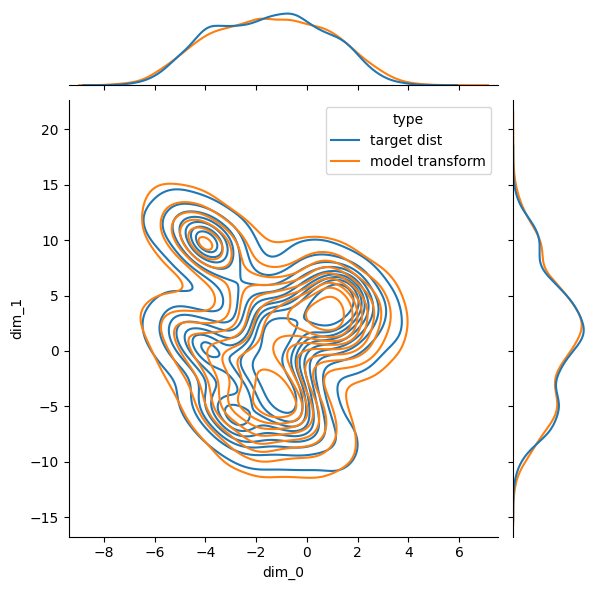

trail: 0 m step: 2 kl_test: 0.33298587799072266


  2%|▏         | 100/6000 [00:31<34:20,  2.86it/s]

trail: 0 m step: 3 Loss: 0.30635328774675763  L_n: 0.25734996795654297  kld: 0.010766029357910156 KLD1: 0.2509078085422516 KLD2: 0.17347387969493866


  3%|▎         | 200/6000 [01:02<33:29,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28851589268861055  L_n: 0.2536592483520508  kld: 0.0076580047607421875 KLD1: 0.25257956981658936 KLD2: 0.18055860698223114


  5%|▌         | 300/6000 [01:34<32:51,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29795437310574324  L_n: 0.24869060516357422  kld: 0.010823249816894531 KLD1: 0.24041393399238586 KLD2: 0.17460897564888


  7%|▋         | 400/6000 [02:05<32:19,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28504630398305375  L_n: 0.2413778305053711  kld: 0.009593963623046875 KLD1: 0.2410120964050293 KLD2: 0.1738816797733307


  8%|▊         | 500/6000 [02:36<31:37,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2928620665302372  L_n: 0.24730968475341797  kld: 0.010007858276367188 KLD1: 0.2488657385110855 KLD2: 0.16884857416152954


 10%|█         | 600/6000 [03:07<31:10,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29017957167349784  L_n: 0.24893760681152344  kld: 0.009060859680175781 KLD1: 0.24998441338539124 KLD2: 0.17345912754535675


 12%|█▏        | 700/6000 [03:39<30:35,  2.89it/s]

trail: 0 m step: 3 Loss: 0.3079783574635189  L_n: 0.24053096771240234  kld: 0.014818191528320312 KLD1: 0.22745658457279205 KLD2: 0.17012929916381836


 13%|█▎        | 800/6000 [04:10<29:56,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29868934780671264  L_n: 0.24138641357421875  kld: 0.012589454650878906 KLD1: 0.23144926130771637 KLD2: 0.1643723100423813


 15%|█▌        | 900/6000 [04:41<29:22,  2.89it/s]

trail: 0 m step: 3 Loss: 0.296187554916361  L_n: 0.23344993591308594  kld: 0.013783454895019531 KLD1: 0.23851370811462402 KLD2: 0.1689901202917099


 17%|█▋        | 1000/6000 [05:13<28:52,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2929660782360412  L_n: 0.2494668960571289  kld: 0.009556770324707031 KLD1: 0.24833989143371582 KLD2: 0.17962956428527832


 18%|█▊        | 1100/6000 [05:44<28:15,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2951557843534307  L_n: 0.23526573181152344  kld: 0.013157844543457031 KLD1: 0.2488010674715042 KLD2: 0.16356875002384186


 20%|██        | 1200/6000 [06:15<27:40,  2.89it/s]

trail: 0 m step: 3 Loss: 0.30908711867056815  L_n: 0.24877166748046875  kld: 0.013251304626464844 KLD1: 0.22681334614753723 KLD2: 0.17061172425746918


 22%|██▏       | 1300/6000 [06:46<27:07,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2993740251946569  L_n: 0.24720191955566406  kld: 0.011462211608886719 KLD1: 0.2426282912492752 KLD2: 0.17398642003536224


 23%|██▎       | 1400/6000 [07:18<26:31,  2.89it/s]

trail: 0 m step: 3 Loss: 0.3104178871845841  L_n: 0.247589111328125  kld: 0.013803482055664062 KLD1: 0.24308422207832336 KLD2: 0.16683022677898407


 25%|██▌       | 1500/6000 [07:49<25:57,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28612387131494343  L_n: 0.2243976593017578  kld: 0.013561248779296875 KLD1: 0.24489882588386536 KLD2: 0.16572228074073792


 27%|██▋       | 1600/6000 [08:20<25:18,  2.90it/s]

trail: 0 m step: 3 Loss: 0.3015725470479098  L_n: 0.2403411865234375  kld: 0.013452529907226562 KLD1: 0.23776204884052277 KLD2: 0.16943903267383575


 28%|██▊       | 1700/6000 [08:51<24:46,  2.89it/s]

trail: 0 m step: 3 Loss: 0.3006527561679123  L_n: 0.24025917053222656  kld: 0.013268470764160156 KLD1: 0.22970929741859436 KLD2: 0.15998396277427673


 30%|███       | 1800/6000 [09:23<24:14,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29518669303786393  L_n: 0.22312068939208984  kld: 0.015832901000976562 KLD1: 0.22832728922367096 KLD2: 0.17403274774551392


 32%|███▏      | 1900/6000 [09:54<23:36,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29776733660621973  L_n: 0.24006938934326172  kld: 0.012676239013671875 KLD1: 0.2323826551437378 KLD2: 0.17489196360111237


 33%|███▎      | 2000/6000 [10:25<23:04,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29063981220729795  L_n: 0.24300384521484375  kld: 0.010465621948242188 KLD1: 0.23809286952018738 KLD2: 0.16412493586540222


 35%|███▌      | 2100/6000 [10:56<22:27,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2780078285436062  L_n: 0.23453903198242188  kld: 0.009550094604492188 KLD1: 0.24979911744594574 KLD2: 0.17020633816719055


 37%|███▋      | 2200/6000 [11:28<21:54,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28582902403923943  L_n: 0.23382186889648438  kld: 0.011425971984863281 KLD1: 0.22665604948997498 KLD2: 0.17361396551132202


 38%|███▊      | 2300/6000 [11:59<21:21,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2753083828529771  L_n: 0.23268604278564453  kld: 0.009364128112792969 KLD1: 0.24304766952991486 KLD2: 0.15370289981365204


 40%|████      | 2400/6000 [12:30<20:44,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2794832295594456  L_n: 0.22655582427978516  kld: 0.011628150939941406 KLD1: 0.23145827651023865 KLD2: 0.1640835851430893


 42%|████▏     | 2500/6000 [13:01<20:10,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2906968525229772  L_n: 0.2371530532836914  kld: 0.011763572692871094 KLD1: 0.21875424683094025 KLD2: 0.16783985495567322


 43%|████▎     | 2600/6000 [13:33<19:38,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2938953767758258  L_n: 0.24506568908691406  kld: 0.010727882385253906 KLD1: 0.24336856603622437 KLD2: 0.16189664602279663


 45%|████▌     | 2700/6000 [14:04<19:00,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28031362855656883  L_n: 0.22585391998291016  kld: 0.011964797973632812 KLD1: 0.24201855063438416 KLD2: 0.16018058359622955


 47%|████▋     | 2800/6000 [14:35<18:26,  2.89it/s]

trail: 0 m step: 3 Loss: 0.30274159766133396  L_n: 0.24702739715576172  kld: 0.012240409851074219 KLD1: 0.21611171960830688 KLD2: 0.1649828404188156


 48%|████▊     | 2900/6000 [15:06<17:49,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2752619262820328  L_n: 0.2286243438720703  kld: 0.01024627685546875 KLD1: 0.23353366553783417 KLD2: 0.1630818247795105


 50%|█████     | 3000/6000 [15:38<17:17,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28816954222493785  L_n: 0.2221546173095703  kld: 0.01450347900390625 KLD1: 0.2344028800725937 KLD2: 0.16892041265964508


 52%|█████▏    | 3100/6000 [16:09<16:45,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2940076043185832  L_n: 0.24444866180419922  kld: 0.010888099670410156 KLD1: 0.22419150173664093 KLD2: 0.17408901453018188


 53%|█████▎    | 3200/6000 [16:40<16:06,  2.90it/s]

trail: 0 m step: 3 Loss: 0.3039522900275333  L_n: 0.25201892852783203  kld: 0.011409759521484375 KLD1: 0.23244838416576385 KLD2: 0.1635308861732483


 55%|█████▌    | 3300/6000 [17:12<15:32,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2734741046855164  L_n: 0.22126293182373047  kld: 0.011470794677734375 KLD1: 0.2300632745027542 KLD2: 0.16550609469413757


 57%|█████▋    | 3400/6000 [17:43<14:59,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2783105569803883  L_n: 0.2338390350341797  kld: 0.009770393371582031 KLD1: 0.24408270418643951 KLD2: 0.1652582287788391


 58%|█████▊    | 3500/6000 [18:14<14:24,  2.89it/s]

trail: 0 m step: 3 Loss: 0.26905021007678487  L_n: 0.2170734405517578  kld: 0.011419296264648438 KLD1: 0.22571083903312683 KLD2: 0.1577625423669815


 60%|██████    | 3600/6000 [18:45<13:49,  2.89it/s]

trail: 0 m step: 3 Loss: 0.30237655136115343  L_n: 0.2381153106689453  kld: 0.014118194580078125 KLD1: 0.21493014693260193 KLD2: 0.16175465285778046


 62%|██████▏   | 3700/6000 [19:17<13:13,  2.90it/s]

trail: 0 m step: 3 Loss: 0.28029778636364594  L_n: 0.23122501373291016  kld: 0.010781288146972656 KLD1: 0.2304435521364212 KLD2: 0.17026570439338684


 63%|██████▎   | 3800/6000 [19:48<12:41,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2968174227270475  L_n: 0.23756980895996094  kld: 0.013016700744628906 KLD1: 0.22854363918304443 KLD2: 0.16597624123096466


 65%|██████▌   | 3900/6000 [20:19<12:05,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2954998775997865  L_n: 0.2461709976196289  kld: 0.010837554931640625 KLD1: 0.2395862191915512 KLD2: 0.16835249960422516


 67%|██████▋   | 4000/6000 [20:50<11:34,  2.88it/s]

trail: 0 m step: 3 Loss: 0.28143229243643564  L_n: 0.22487163543701172  kld: 0.012426376342773438 KLD1: 0.233377143740654 KLD2: 0.16510233283042908


 68%|██████▊   | 4100/6000 [21:22<10:58,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2732242055518767  L_n: 0.2279062271118164  kld: 0.00995635986328125 KLD1: 0.23939523100852966 KLD2: 0.16108378767967224


 70%|███████   | 4200/6000 [21:53<10:22,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2850442208319183  L_n: 0.24055099487304688  kld: 0.009775161743164062 KLD1: 0.2259012907743454 KLD2: 0.1642005741596222


 72%|███████▏  | 4300/6000 [22:24<09:47,  2.89it/s]

trail: 0 m step: 3 Loss: 0.29086824346793255  L_n: 0.2439441680908203  kld: 0.010309219360351562 KLD1: 0.2235962301492691 KLD2: 0.1697048544883728


 73%|███████▎  | 4400/6000 [22:55<09:12,  2.89it/s]

trail: 0 m step: 3 Loss: 0.30219660990336944  L_n: 0.24559688568115234  kld: 0.012434959411621094 KLD1: 0.22774213552474976 KLD2: 0.1730562299489975


 75%|███████▌  | 4500/6000 [23:27<08:38,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2582829296995848  L_n: 0.2157430648803711  kld: 0.00934600830078125 KLD1: 0.23469696938991547 KLD2: 0.1633068025112152


 77%|███████▋  | 4600/6000 [23:58<08:03,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2883751044015099  L_n: 0.2339935302734375  kld: 0.0119476318359375 KLD1: 0.22964471578598022 KLD2: 0.16965337097644806


 78%|███████▊  | 4700/6000 [24:29<07:29,  2.89it/s]

trail: 0 m step: 3 Loss: 0.272166827292566  L_n: 0.23518753051757812  kld: 0.008124351501464844 KLD1: 0.24244247376918793 KLD2: 0.16883452236652374


 80%|████████  | 4800/6000 [25:00<06:55,  2.88it/s]

trail: 0 m step: 3 Loss: 0.27746264371320667  L_n: 0.2331256866455078  kld: 0.009740829467773438 KLD1: 0.23455023765563965 KLD2: 0.16990125179290771


 82%|████████▏ | 4900/6000 [25:32<06:20,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2688388364337822  L_n: 0.23212432861328125  kld: 0.008066177368164062 KLD1: 0.23760107159614563 KLD2: 0.16404925286769867


 83%|████████▎ | 5000/6000 [26:03<05:46,  2.89it/s]

trail: 0 m step: 3 Loss: 0.27720644477285145  L_n: 0.23363780975341797  kld: 0.009572029113769531 KLD1: 0.22208823263645172 KLD2: 0.16893181204795837


 85%|████████▌ | 5100/6000 [26:34<05:11,  2.89it/s]

trail: 0 m step: 3 Loss: 0.30779583496454904  L_n: 0.25638771057128906  kld: 0.011294364929199219 KLD1: 0.22523468732833862 KLD2: 0.16960841417312622


 87%|████████▋ | 5200/6000 [27:06<04:37,  2.88it/s]

trail: 0 m step: 3 Loss: 0.2775113700897953  L_n: 0.2277050018310547  kld: 0.010942459106445312 KLD1: 0.22689288854599 KLD2: 0.18259531259536743


 88%|████████▊ | 5300/6000 [27:37<04:02,  2.88it/s]

trail: 0 m step: 3 Loss: 0.2626986188892891  L_n: 0.22346210479736328  kld: 0.008620262145996094 KLD1: 0.23683065176010132 KLD2: 0.16438226401805878


 90%|█████████ | 5400/6000 [28:08<03:27,  2.89it/s]

trail: 0 m step: 3 Loss: 0.28366920087464464  L_n: 0.22588443756103516  kld: 0.0126953125 KLD1: 0.21931664645671844 KLD2: 0.1621629297733307


 92%|█████████▏| 5500/6000 [28:39<02:53,  2.88it/s]

trail: 0 m step: 3 Loss: 0.2892331894712661  L_n: 0.2449960708618164  kld: 0.009718894958496094 KLD1: 0.23174452781677246 KLD2: 0.16750860214233398


 93%|█████████▎| 5600/6000 [29:11<02:18,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2784137495767544  L_n: 0.2314462661743164  kld: 0.010318756103515625 KLD1: 0.22202685475349426 KLD2: 0.1634143739938736


 95%|█████████▌| 5700/6000 [29:42<01:43,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2807405082865851  L_n: 0.22832965850830078  kld: 0.011514663696289062 KLD1: 0.22140908241271973 KLD2: 0.16507844626903534


 97%|█████████▋| 5800/6000 [30:13<01:09,  2.89it/s]

trail: 0 m step: 3 Loss: 0.27261598879606225  L_n: 0.2247152328491211  kld: 0.010523796081542969 KLD1: 0.23614779114723206 KLD2: 0.16697059571743011


 98%|█████████▊| 5900/6000 [30:45<00:34,  2.90it/s]

trail: 0 m step: 3 Loss: 0.27805232654444784  L_n: 0.2301168441772461  kld: 0.010531425476074219 KLD1: 0.2160455584526062 KLD2: 0.16795262694358826


100%|██████████| 6000/6000 [31:16<00:00,  3.20it/s]

trail: 0 m step: 3 Loss: 0.2775235208642445  L_n: 0.23126792907714844  kld: 0.010162353515625 KLD1: 0.23782962560653687 KLD2: 0.15686428546905518



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


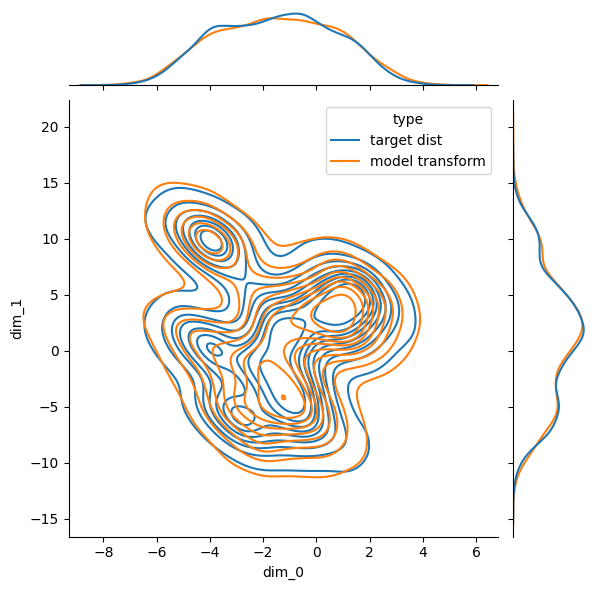

trail: 0 m step: 3 kl_test: 0.2378978729248047


  2%|▏         | 100/6000 [00:31<34:16,  2.87it/s]

trail: 0 m step: 4 Loss: 0.19980149021845212  L_n: 0.16309833526611328  kld: 0.0104827880859375 KLD1: 0.16654042899608612 KLD2: 0.11954430490732193


  3%|▎         | 200/6000 [01:02<33:15,  2.91it/s]

trail: 0 m step: 4 Loss: 0.217499046055886  L_n: 0.16843128204345703  kld: 0.014014244079589844 KLD1: 0.17074213922023773 KLD2: 0.12579184770584106


  5%|▌         | 300/6000 [01:33<32:49,  2.89it/s]

trail: 0 m step: 4 Loss: 0.2017244456057363  L_n: 0.1614551544189453  kld: 0.011501312255859375 KLD1: 0.16575631499290466 KLD2: 0.12277799844741821


  7%|▋         | 400/6000 [02:04<32:17,  2.89it/s]

trail: 0 m step: 4 Loss: 0.21234243696867294  L_n: 0.1765909194946289  kld: 0.010210990905761719 KLD1: 0.1632308065891266 KLD2: 0.11913229525089264


  8%|▊         | 500/6000 [02:36<31:44,  2.89it/s]

trail: 0 m step: 4 Loss: 0.21059156588607172  L_n: 0.17202186584472656  kld: 0.011015892028808594 KLD1: 0.17584051191806793 KLD2: 0.11830632388591766


 10%|█         | 600/6000 [03:07<31:09,  2.89it/s]

trail: 0 m step: 4 Loss: 0.20795878003005122  L_n: 0.17638111114501953  kld: 0.009018898010253906 KLD1: 0.1797337830066681 KLD2: 0.12037236988544464


 12%|█▏        | 700/6000 [03:38<30:27,  2.90it/s]

trail: 0 m step: 4 Loss: 0.22500695134114118  L_n: 0.1678152084350586  kld: 0.01633453369140625 KLD1: 0.1713375449180603 KLD2: 0.11774680018424988


 13%|█▎        | 800/6000 [04:09<29:48,  2.91it/s]

trail: 0 m step: 4 Loss: 0.2232289193896226  L_n: 0.17623138427734375  kld: 0.013422966003417969 KLD1: 0.1594051867723465 KLD2: 0.11174015700817108


 15%|█▌        | 900/6000 [04:40<29:14,  2.91it/s]

trail: 0 m step: 4 Loss: 0.20592000475200609  L_n: 0.16339683532714844  kld: 0.012145042419433594 KLD1: 0.1706889122724533 KLD2: 0.11395324766635895


 17%|█▋        | 1000/6000 [05:11<28:39,  2.91it/s]

trail: 0 m step: 4 Loss: 0.20171351399576457  L_n: 0.16265296936035156  kld: 0.011156082153320312 KLD1: 0.16880570352077484 KLD2: 0.1235455796122551


 18%|█▊        | 1100/6000 [05:43<28:07,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20361661682283838  L_n: 0.15659236907958984  kld: 0.013430595397949219 KLD1: 0.17218318581581116 KLD2: 0.11088960617780685


 20%|██        | 1200/6000 [06:14<27:34,  2.90it/s]

trail: 0 m step: 4 Loss: 0.22729066491673788  L_n: 0.1814718246459961  kld: 0.013086318969726562 KLD1: 0.15862911939620972 KLD2: 0.12023905664682388


 22%|██▏       | 1300/6000 [06:45<27:04,  2.89it/s]

trail: 0 m step: 4 Loss: 0.2057502583367856  L_n: 0.16451263427734375  kld: 0.011777877807617188 KLD1: 0.16119042038917542 KLD2: 0.12122844159603119


 23%|██▎       | 1400/6000 [07:16<26:25,  2.90it/s]

trail: 0 m step: 4 Loss: 0.21435685066118162  L_n: 0.16745948791503906  kld: 0.013394355773925781 KLD1: 0.15571513772010803 KLD2: 0.11256368458271027


 25%|██▌       | 1500/6000 [07:48<25:57,  2.89it/s]

trail: 0 m step: 4 Loss: 0.1965678289388142  L_n: 0.15787792205810547  kld: 0.011050224304199219 KLD1: 0.1615695357322693 KLD2: 0.11274567246437073


 27%|██▋       | 1600/6000 [08:19<25:18,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20568062976054344  L_n: 0.16185855865478516  kld: 0.012516021728515625 KLD1: 0.16162636876106262 KLD2: 0.11827275156974792


 28%|██▊       | 1700/6000 [08:50<24:41,  2.90it/s]

trail: 0 m step: 4 Loss: 0.2079849555367937  L_n: 0.1634817123413086  kld: 0.0127105712890625 KLD1: 0.15301838517189026 KLD2: 0.10994191467761993


 30%|███       | 1800/6000 [09:21<24:08,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19165525449423773  L_n: 0.1508951187133789  kld: 0.011641502380371094 KLD1: 0.15876100957393646 KLD2: 0.12406840175390244


 32%|███▏      | 1900/6000 [09:52<23:34,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20149283377230448  L_n: 0.15825176239013672  kld: 0.012350082397460938 KLD1: 0.16439813375473022 KLD2: 0.12249445170164108


 33%|███▎      | 2000/6000 [10:24<23:02,  2.89it/s]

trail: 0 m step: 4 Loss: 0.20334358501824998  L_n: 0.16492748260498047  kld: 0.010972023010253906 KLD1: 0.14813445508480072 KLD2: 0.11116362363100052


 35%|███▌      | 2100/6000 [10:55<22:28,  2.89it/s]

trail: 0 m step: 4 Loss: 0.18919063737206188  L_n: 0.15584659576416016  kld: 0.009523391723632812 KLD1: 0.1682417243719101 KLD2: 0.11836569756269455


 37%|███▋      | 2200/6000 [11:26<21:57,  2.88it/s]

trail: 0 m step: 4 Loss: 0.1972991100509086  L_n: 0.16173458099365234  kld: 0.010157585144042969 KLD1: 0.15841378271579742 KLD2: 0.12225330621004105


 38%|███▊      | 2300/6000 [11:57<21:17,  2.90it/s]

trail: 0 m step: 4 Loss: 0.18741792958180345  L_n: 0.15229415893554688  kld: 0.010031700134277344 KLD1: 0.164535254240036 KLD2: 0.10572507232427597


 40%|████      | 2400/6000 [12:29<20:43,  2.90it/s]

trail: 0 m step: 4 Loss: 0.18921900448322143  L_n: 0.14870262145996094  kld: 0.011571884155273438 KLD1: 0.1568872630596161 KLD2: 0.11298771947622299


 42%|████▏     | 2500/6000 [13:00<20:05,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20864798404026721  L_n: 0.16614151000976562  kld: 0.012140274047851562 KLD1: 0.15500669181346893 KLD2: 0.11404121667146683


 43%|████▎     | 2600/6000 [13:31<19:33,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19629794945841572  L_n: 0.16019248962402344  kld: 0.010312080383300781 KLD1: 0.16314458847045898 KLD2: 0.10755246132612228


 45%|████▌     | 2700/6000 [14:02<18:54,  2.91it/s]

trail: 0 m step: 4 Loss: 0.18818283885772694  L_n: 0.14896869659423828  kld: 0.011199951171875 KLD1: 0.16407503187656403 KLD2: 0.10790711641311646


 47%|████▋     | 2800/6000 [14:33<18:24,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19965024784304908  L_n: 0.15926074981689453  kld: 0.01153564453125 KLD1: 0.15174686908721924 KLD2: 0.11232821643352509


 48%|████▊     | 2900/6000 [15:04<17:48,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19053642202427873  L_n: 0.1633129119873047  kld: 0.007775306701660156 KLD1: 0.1468866914510727 KLD2: 0.11304424703121185


 50%|█████     | 3000/6000 [15:36<17:17,  2.89it/s]

trail: 0 m step: 4 Loss: 0.19763940269091163  L_n: 0.15861892700195312  kld: 0.011144638061523438 KLD1: 0.15408483147621155 KLD2: 0.116200752556324


 52%|█████▏    | 3100/6000 [16:07<16:42,  2.89it/s]

trail: 0 m step: 4 Loss: 0.20778378354773075  L_n: 0.17227935791015625  kld: 0.010140419006347656 KLD1: 0.15732790529727936 KLD2: 0.12156498432159424


 53%|█████▎    | 3200/6000 [16:38<16:07,  2.89it/s]

trail: 0 m step: 4 Loss: 0.21394027566246981  L_n: 0.16785430908203125  kld: 0.013162612915039062 KLD1: 0.15540355443954468 KLD2: 0.11411740630865097


 55%|█████▌    | 3300/6000 [17:09<15:31,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19634563838319907  L_n: 0.15108108520507812  kld: 0.012928009033203125 KLD1: 0.16130013763904572 KLD2: 0.11466259509325027


 57%|█████▋    | 3400/6000 [17:41<14:56,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19060943145126877  L_n: 0.156707763671875  kld: 0.009682655334472656 KLD1: 0.1640215963125229 KLD2: 0.11426345258951187


 58%|█████▊    | 3500/6000 [18:12<14:20,  2.91it/s]

trail: 0 m step: 4 Loss: 0.18040194507573631  L_n: 0.14473724365234375  kld: 0.010186195373535156 KLD1: 0.15654151141643524 KLD2: 0.10824050009250641


 60%|██████    | 3600/6000 [18:43<13:46,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19796803369812926  L_n: 0.1534748077392578  kld: 0.012707710266113281 KLD1: 0.14350448548793793 KLD2: 0.11174372583627701


 62%|██████▏   | 3700/6000 [19:14<13:11,  2.91it/s]

trail: 0 m step: 4 Loss: 0.19750964601919482  L_n: 0.1547260284423828  kld: 0.012219429016113281 KLD1: 0.16015522181987762 KLD2: 0.11531654745340347


 63%|██████▎   | 3800/6000 [19:45<12:37,  2.90it/s]

trail: 0 m step: 4 Loss: 0.21066055679842183  L_n: 0.1594390869140625  kld: 0.014629364013671875 KLD1: 0.15715007483959198 KLD2: 0.11278115957975388


 65%|██████▌   | 3900/6000 [20:16<12:04,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20640244238024594  L_n: 0.16551876068115234  kld: 0.011676788330078125 KLD1: 0.15651480853557587 KLD2: 0.11418826878070831


 67%|██████▋   | 4000/6000 [20:48<11:30,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1798660120982916  L_n: 0.14542007446289062  kld: 0.009838104248046875 KLD1: 0.156657412648201 KLD2: 0.11328297853469849


 68%|██████▊   | 4100/6000 [21:19<10:55,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19260412995327186  L_n: 0.15715312957763672  kld: 0.010125160217285156 KLD1: 0.15005460381507874 KLD2: 0.10732000321149826


 70%|███████   | 4200/6000 [21:50<10:19,  2.91it/s]

trail: 0 m step: 4 Loss: 0.19359744451179636  L_n: 0.16058731079101562  kld: 0.009428024291992188 KLD1: 0.16210781037807465 KLD2: 0.11163704842329025


 72%|███████▏  | 4300/6000 [22:21<09:44,  2.91it/s]

trail: 0 m step: 4 Loss: 0.19487868767443134  L_n: 0.16191864013671875  kld: 0.009413719177246094 KLD1: 0.14719675481319427 KLD2: 0.11696945875883102


 73%|███████▎  | 4400/6000 [22:52<09:11,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20669277315108717  L_n: 0.1620626449584961  kld: 0.012746810913085938 KLD1: 0.15235266089439392 KLD2: 0.11948185414075851


 75%|███████▌  | 4500/6000 [23:23<08:36,  2.90it/s]

trail: 0 m step: 4 Loss: 0.18676617026917552  L_n: 0.15273761749267578  kld: 0.009718894958496094 KLD1: 0.16210082173347473 KLD2: 0.11115551739931107


 77%|███████▋  | 4600/6000 [23:54<08:03,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19193646897872635  L_n: 0.1515035629272461  kld: 0.011548042297363281 KLD1: 0.15043485164642334 KLD2: 0.11665543913841248


 78%|███████▊  | 4700/6000 [24:26<07:27,  2.91it/s]

trail: 0 m step: 4 Loss: 0.19083621153740157  L_n: 0.1600799560546875  kld: 0.008784294128417969 KLD1: 0.16206689178943634 KLD2: 0.11489589512348175


 80%|████████  | 4800/6000 [24:57<06:53,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1791051527577402  L_n: 0.14287948608398438  kld: 0.010346412658691406 KLD1: 0.1515871286392212 KLD2: 0.11527404189109802


 82%|████████▏ | 4900/6000 [25:28<06:19,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19181344372305997  L_n: 0.16706085205078125  kld: 0.007069587707519531 KLD1: 0.17238149046897888 KLD2: 0.11172851175069809


 83%|████████▎ | 5000/6000 [25:59<05:44,  2.91it/s]

trail: 0 m step: 4 Loss: 0.20034002066535075  L_n: 0.1618337631225586  kld: 0.010997772216796875 KLD1: 0.15076787769794464 KLD2: 0.11723963171243668


 85%|████████▌ | 5100/6000 [26:30<05:09,  2.91it/s]

trail: 0 m step: 4 Loss: 0.21427964110705186  L_n: 0.17381000518798828  kld: 0.01155853271484375 KLD1: 0.14833210408687592 KLD2: 0.11560814827680588


 87%|████████▋ | 5200/6000 [27:01<04:34,  2.91it/s]

trail: 0 m step: 4 Loss: 0.18995406403018497  L_n: 0.15396881103515625  kld: 0.010277748107910156 KLD1: 0.1493496298789978 KLD2: 0.1261172890663147


 88%|████████▊ | 5300/6000 [27:33<04:00,  2.91it/s]

trail: 0 m step: 4 Loss: 0.19163328766267693  L_n: 0.1588001251220703  kld: 0.009377479553222656 KLD1: 0.1696605235338211 KLD2: 0.11217135936021805


 90%|█████████ | 5400/6000 [28:04<03:27,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19296724068960308  L_n: 0.15686511993408203  kld: 0.010311126708984375 KLD1: 0.15943363308906555 KLD2: 0.11101161688566208


 92%|█████████▏| 5500/6000 [28:35<02:52,  2.90it/s]

trail: 0 m step: 4 Loss: 0.20285065967718352  L_n: 0.1745452880859375  kld: 0.008084297180175781 KLD1: 0.15595565736293793 KLD2: 0.11493012309074402


 93%|█████████▎| 5600/6000 [29:06<02:17,  2.90it/s]

trail: 0 m step: 4 Loss: 0.18764050590120057  L_n: 0.15019607543945312  kld: 0.010694503784179688 KLD1: 0.15586578845977783 KLD2: 0.10899130254983902


 95%|█████████▌| 5700/6000 [29:37<01:43,  2.90it/s]

trail: 0 m step: 4 Loss: 0.19093274046762754  L_n: 0.15176868438720703  kld: 0.011185646057128906 KLD1: 0.15221458673477173 KLD2: 0.11026030033826828


 97%|█████████▋| 5800/6000 [30:08<01:08,  2.91it/s]

trail: 0 m step: 4 Loss: 0.18976865329477308  L_n: 0.15226078033447266  kld: 0.010712623596191406 KLD1: 0.1557876616716385 KLD2: 0.11285492777824402


 98%|█████████▊| 5900/6000 [30:40<00:34,  2.90it/s]

trail: 0 m step: 4 Loss: 0.18980204682152985  L_n: 0.15355968475341797  kld: 0.010351181030273438 KLD1: 0.1482686698436737 KLD2: 0.11542658507823944


100%|██████████| 6000/6000 [31:11<00:00,  3.21it/s]

trail: 0 m step: 4 Loss: 0.18562512911817305  L_n: 0.15020751953125  kld: 0.010115623474121094 KLD1: 0.16215309500694275 KLD2: 0.10429895669221878



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


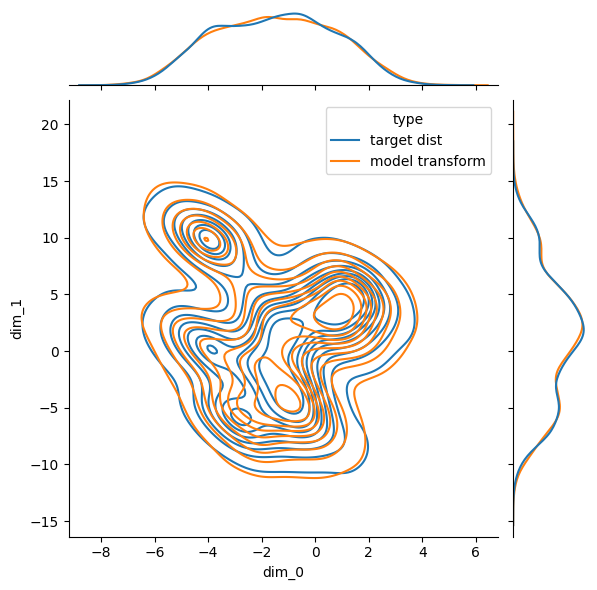

trail: 0 m step: 4 kl_test: 0.16109943389892578


  2%|▏         | 100/6000 [00:31<34:23,  2.86it/s]

trail: 0 m step: 5 Loss: 0.1498374086600749  L_n: 0.12595272064208984  kld: 0.008868217468261719 KLD1: 0.11801771074533463 KLD2: 0.08225962519645691


  3%|▎         | 200/6000 [01:02<33:32,  2.88it/s]

trail: 0 m step: 5 Loss: 0.15024443563981013  L_n: 0.1262826919555664  kld: 0.008896827697753906 KLD1: 0.1160752922296524 KLD2: 0.08302144706249237


  5%|▌         | 300/6000 [01:34<33:02,  2.88it/s]

trail: 0 m step: 5 Loss: 0.14259582747595473  L_n: 0.11540031433105469  kld: 0.010097503662109375 KLD1: 0.11153813451528549 KLD2: 0.08535189926624298


  7%|▋         | 400/6000 [02:05<32:29,  2.87it/s]

trail: 0 m step: 5 Loss: 0.13584274994246706  L_n: 0.11216354370117188  kld: 0.008791923522949219 KLD1: 0.10929716378450394 KLD2: 0.08109645545482635


  8%|▊         | 500/6000 [02:37<31:54,  2.87it/s]

trail: 0 m step: 5 Loss: 0.14814013345863777  L_n: 0.12332820892333984  kld: 0.009212493896484375 KLD1: 0.11840654164552689 KLD2: 0.08194024115800858


 10%|█         | 600/6000 [03:08<31:08,  2.89it/s]

trail: 0 m step: 5 Loss: 0.14816756151550936  L_n: 0.1177511215209961  kld: 0.011293411254882812 KLD1: 0.12209810316562653 KLD2: 0.0845809131860733


 12%|█▏        | 700/6000 [03:39<30:47,  2.87it/s]

trail: 0 m step: 5 Loss: 0.1418600967201991  L_n: 0.1040334701538086  kld: 0.014044761657714844 KLD1: 0.11234479397535324 KLD2: 0.08226484060287476


 13%|█▎        | 800/6000 [04:11<30:11,  2.87it/s]

trail: 0 m step: 5 Loss: 0.14833415592503665  L_n: 0.11833381652832031  kld: 0.011138916015625 KLD1: 0.10803043842315674 KLD2: 0.07663538306951523


 15%|█▌        | 900/6000 [04:42<29:36,  2.87it/s]

trail: 0 m step: 5 Loss: 0.13948315943755643  L_n: 0.10973453521728516  kld: 0.011045455932617188 KLD1: 0.10361003130674362 KLD2: 0.07827030122280121


 17%|█▋        | 1000/6000 [05:14<28:58,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13956988894698913  L_n: 0.11278533935546875  kld: 0.009944915771484375 KLD1: 0.11919267475605011 KLD2: 0.08673861622810364


 18%|█▊        | 1100/6000 [05:45<28:23,  2.88it/s]

trail: 0 m step: 5 Loss: 0.14848923314262502  L_n: 0.11106586456298828  kld: 0.013895034790039062 KLD1: 0.1121855229139328 KLD2: 0.07417362183332443


 20%|██        | 1200/6000 [06:16<27:47,  2.88it/s]

trail: 0 m step: 5 Loss: 0.15060115861808837  L_n: 0.11605453491210938  kld: 0.012826919555664062 KLD1: 0.09716061502695084 KLD2: 0.08228819072246552


 22%|██▏       | 1300/6000 [06:48<27:12,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1493086678812907  L_n: 0.11668586730957031  kld: 0.012112617492675781 KLD1: 0.10686935484409332 KLD2: 0.0815824642777443


 23%|██▎       | 1400/6000 [07:19<26:40,  2.87it/s]

trail: 0 m step: 5 Loss: 0.14627981652741998  L_n: 0.1156167984008789  kld: 0.011384963989257812 KLD1: 0.11977934092283249 KLD2: 0.07979848235845566


 25%|██▌       | 1500/6000 [07:50<26:00,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13542068053570608  L_n: 0.10137748718261719  kld: 0.012639999389648438 KLD1: 0.10661014169454575 KLD2: 0.07819757610559464


 27%|██▋       | 1600/6000 [08:22<25:31,  2.87it/s]

trail: 0 m step: 5 Loss: 0.1506193058619173  L_n: 0.11298274993896484  kld: 0.013974189758300781 KLD1: 0.10984412580728531 KLD2: 0.0858626589179039


 28%|██▊       | 1700/6000 [08:53<24:51,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1442455225629148  L_n: 0.11568355560302734  kld: 0.0106048583984375 KLD1: 0.10530727356672287 KLD2: 0.07631706446409225


 30%|███       | 1800/6000 [09:25<24:17,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1467407185044907  L_n: 0.11109733581542969  kld: 0.013234138488769531 KLD1: 0.10953769087791443 KLD2: 0.08583450317382812


 32%|███▏      | 1900/6000 [09:56<23:41,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13758823901555095  L_n: 0.11539363861083984  kld: 0.008240699768066406 KLD1: 0.10395552963018417 KLD2: 0.08686289191246033


 33%|███▎      | 2000/6000 [10:27<23:03,  2.89it/s]

trail: 0 m step: 5 Loss: 0.15395632197092107  L_n: 0.12003898620605469  kld: 0.012593269348144531 KLD1: 0.10517170280218124 KLD2: 0.07737944275140762


 35%|███▌      | 2100/6000 [10:58<22:31,  2.89it/s]

trail: 0 m step: 5 Loss: 0.12937182291176277  L_n: 0.10455989837646484  kld: 0.009212493896484375 KLD1: 0.107811838388443 KLD2: 0.07768793404102325


 37%|███▋      | 2200/6000 [11:30<22:00,  2.88it/s]

trail: 0 m step: 5 Loss: 0.14127917800523054  L_n: 0.11607170104980469  kld: 0.009359359741210938 KLD1: 0.10247752070426941 KLD2: 0.08132471889257431


 38%|███▊      | 2300/6000 [12:01<21:24,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13303063860138456  L_n: 0.10980606079101562  kld: 0.008623123168945312 KLD1: 0.10448303073644638 KLD2: 0.06910403817892075


 40%|████      | 2400/6000 [12:33<20:51,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12009545722419755  L_n: 0.09119701385498047  kld: 0.010729789733886719 KLD1: 0.110188327729702 KLD2: 0.07572036981582642


 42%|████▏     | 2500/6000 [13:04<20:16,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13609783803292638  L_n: 0.10754871368408203  kld: 0.010600090026855469 KLD1: 0.09704285115003586 KLD2: 0.07696405053138733


 43%|████▎     | 2600/6000 [13:35<19:38,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12897653556312677  L_n: 0.10684871673583984  kld: 0.008215904235839844 KLD1: 0.11101005226373672 KLD2: 0.07268538326025009


 45%|████▌     | 2700/6000 [14:07<19:05,  2.88it/s]

trail: 0 m step: 5 Loss: 0.11970427400932077  L_n: 0.09892749786376953  kld: 0.007714271545410156 KLD1: 0.10608235746622086 KLD2: 0.07144592702388763


 47%|████▋     | 2800/6000 [14:38<18:31,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12593651740741124  L_n: 0.09837627410888672  kld: 0.010232925415039062 KLD1: 0.09629153460264206 KLD2: 0.0737205222249031


 48%|████▊     | 2900/6000 [15:09<17:57,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1350983233648759  L_n: 0.10652351379394531  kld: 0.010609626770019531 KLD1: 0.11185425519943237 KLD2: 0.07589751482009888


 50%|█████     | 3000/6000 [15:41<17:21,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1402488136619761  L_n: 0.11090087890625  kld: 0.010896682739257812 KLD1: 0.11304333060979843 KLD2: 0.07873117178678513


 52%|█████▏    | 3100/6000 [16:12<16:47,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13593281579272629  L_n: 0.11391544342041016  kld: 0.008174896240234375 KLD1: 0.10382077097892761 KLD2: 0.07997068762779236


 53%|█████▎    | 3200/6000 [16:44<16:15,  2.87it/s]

trail: 0 m step: 5 Loss: 0.14635927923546455  L_n: 0.11425018310546875  kld: 0.011921882629394531 KLD1: 0.10240963101387024 KLD2: 0.07640596479177475


 55%|█████▌    | 3300/6000 [17:15<15:37,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13419721691971612  L_n: 0.1049032211303711  kld: 0.010876655578613281 KLD1: 0.09676103293895721 KLD2: 0.07869493961334229


 57%|█████▋    | 3400/6000 [17:46<15:04,  2.87it/s]

trail: 0 m step: 5 Loss: 0.12824757494646238  L_n: 0.10628414154052734  kld: 0.008154869079589844 KLD1: 0.10597158223390579 KLD2: 0.07589346915483475


 58%|█████▊    | 3500/6000 [18:18<14:27,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12511083044904098  L_n: 0.09782028198242188  kld: 0.010132789611816406 KLD1: 0.097011998295784 KLD2: 0.07044390588998795


 60%|██████    | 3600/6000 [18:49<13:54,  2.87it/s]

trail: 0 m step: 5 Loss: 0.13198294969141644  L_n: 0.1018362045288086  kld: 0.011193275451660156 KLD1: 0.09693742543458939 KLD2: 0.0757940337061882


 62%|██████▏   | 3700/6000 [19:20<13:21,  2.87it/s]

trail: 0 m step: 5 Loss: 0.13384657859332205  L_n: 0.10670757293701172  kld: 0.010076522827148438 KLD1: 0.10639301687479019 KLD2: 0.07827682048082352


 63%|██████▎   | 3800/6000 [19:52<12:42,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1320739753059582  L_n: 0.10477828979492188  kld: 0.010134696960449219 KLD1: 0.10705087333917618 KLD2: 0.07494212687015533


 65%|██████▌   | 3900/6000 [20:23<12:09,  2.88it/s]

trail: 0 m step: 5 Loss: 0.14218437946846424  L_n: 0.11532020568847656  kld: 0.009974479675292969 KLD1: 0.10646577179431915 KLD2: 0.07813721150159836


 67%|██████▋   | 4000/6000 [20:54<11:34,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12613573784357412  L_n: 0.09723472595214844  kld: 0.010730743408203125 KLD1: 0.10216031223535538 KLD2: 0.07789737731218338


 68%|██████▊   | 4100/6000 [21:26<11:01,  2.87it/s]

trail: 0 m step: 5 Loss: 0.13264155777073744  L_n: 0.1065530776977539  kld: 0.009686470031738281 KLD1: 0.09941092133522034 KLD2: 0.07055830955505371


 70%|███████   | 4200/6000 [21:57<10:25,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12858901473471715  L_n: 0.10414695739746094  kld: 0.009075164794921875 KLD1: 0.1111922487616539 KLD2: 0.07580495625734329


 72%|███████▏  | 4300/6000 [22:29<09:50,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13780890038348953  L_n: 0.10879230499267578  kld: 0.010773658752441406 KLD1: 0.10483061522245407 KLD2: 0.08019926398992538


 73%|███████▎  | 4400/6000 [23:00<09:14,  2.89it/s]

trail: 0 m step: 5 Loss: 0.1392928694294791  L_n: 0.10631561279296875  kld: 0.012244224548339844 KLD1: 0.10784225910902023 KLD2: 0.08294814079999924


 75%|███████▌  | 4500/6000 [23:31<08:42,  2.87it/s]

trail: 0 m step: 5 Loss: 0.12665559696537243  L_n: 0.10449695587158203  kld: 0.008227348327636719 KLD1: 0.11171931773424149 KLD2: 0.07397829741239548


 77%|███████▋  | 4600/6000 [24:03<08:06,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12578351513709832  L_n: 0.09935855865478516  kld: 0.0098114013671875 KLD1: 0.10667480528354645 KLD2: 0.07869470119476318


 78%|███████▊  | 4700/6000 [24:34<07:32,  2.88it/s]

trail: 0 m step: 5 Loss: 0.1233128740186902  L_n: 0.10563373565673828  kld: 0.006564140319824219 KLD1: 0.1131817102432251 KLD2: 0.07773452997207642


 80%|████████  | 4800/6000 [25:05<06:57,  2.87it/s]

trail: 0 m step: 5 Loss: 0.12134488937797894  L_n: 0.10156726837158203  kld: 0.007343292236328125 KLD1: 0.09829577058553696 KLD2: 0.07733897864818573


 82%|████████▏ | 4900/6000 [25:37<06:21,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12504227556131542  L_n: 0.10549068450927734  kld: 0.007259368896484375 KLD1: 0.11528187245130539 KLD2: 0.0759836733341217


 83%|████████▎ | 5000/6000 [26:08<05:47,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12630334075766142  L_n: 0.10208988189697266  kld: 0.008990287780761719 KLD1: 0.09679556638002396 KLD2: 0.07942523062229156


 85%|████████▌ | 5100/6000 [26:40<05:12,  2.88it/s]

trail: 0 m step: 5 Loss: 0.14584492578982236  L_n: 0.11984634399414062  kld: 0.009653091430664062 KLD1: 0.10081713646650314 KLD2: 0.07789983600378036


 87%|████████▋ | 5200/6000 [27:11<04:38,  2.87it/s]

trail: 0 m step: 5 Loss: 0.1332138720493221  L_n: 0.10682487487792969  kld: 0.009798049926757812 KLD1: 0.09875842183828354 KLD2: 0.08597207069396973


 88%|████████▊ | 5300/6000 [27:42<04:03,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13134860694739917  L_n: 0.10944938659667969  kld: 0.008131027221679688 KLD1: 0.11400158703327179 KLD2: 0.07448048889636993


 90%|█████████ | 5400/6000 [28:14<03:27,  2.89it/s]

trail: 0 m step: 5 Loss: 0.1279367228313037  L_n: 0.10323524475097656  kld: 0.009171485900878906 KLD1: 0.10935717821121216 KLD2: 0.07347497344017029


 92%|█████████▏| 5500/6000 [28:45<02:53,  2.88it/s]

trail: 0 m step: 5 Loss: 0.14070863090588473  L_n: 0.11980342864990234  kld: 0.007761955261230469 KLD1: 0.11115717142820358 KLD2: 0.07712428271770477


 93%|█████████▎| 5600/6000 [29:16<02:19,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12818696636781227  L_n: 0.10183906555175781  kld: 0.009782791137695312 KLD1: 0.10009188950061798 KLD2: 0.07232515513896942


 95%|█████████▌| 5700/6000 [29:48<01:44,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13575325692659934  L_n: 0.1040191650390625  kld: 0.011782646179199219 KLD1: 0.08853089809417725 KLD2: 0.0724925547838211


 97%|█████████▋| 5800/6000 [30:19<01:09,  2.88it/s]

trail: 0 m step: 5 Loss: 0.13160072432359982  L_n: 0.10593605041503906  kld: 0.00952911376953125 KLD1: 0.1012338325381279 KLD2: 0.07691942900419235


 98%|█████████▊| 5900/6000 [30:51<00:34,  2.88it/s]

trail: 0 m step: 5 Loss: 0.12584322184595645  L_n: 0.10144996643066406  kld: 0.009057044982910156 KLD1: 0.0988134890794754 KLD2: 0.07802224904298782


100%|██████████| 6000/6000 [31:22<00:00,  3.19it/s]

trail: 0 m step: 5 Loss: 0.1251349008129609  L_n: 0.10103702545166016  kld: 0.008947372436523438 KLD1: 0.10120738297700882 KLD2: 0.06837578117847443



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


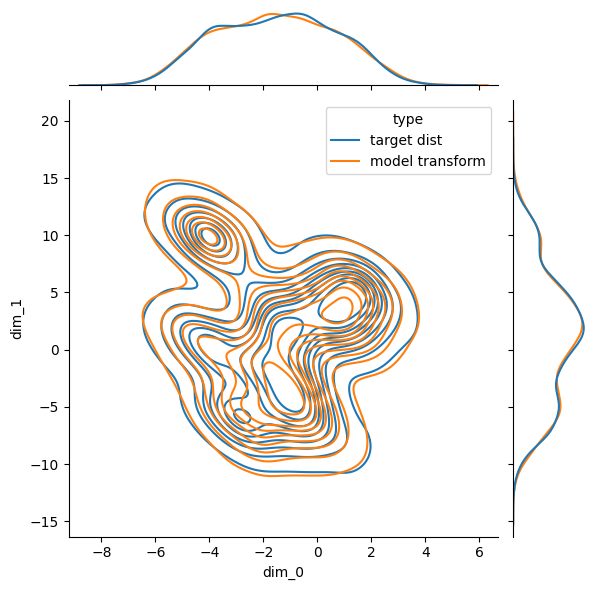

trail: 0 m step: 5 kl_test: 0.1048126220703125


  2%|▏         | 100/6000 [00:31<34:07,  2.88it/s]

trail: 0 m step: 6 Loss: 0.09838300708817926  L_n: 0.07602500915527344  kld: 0.010791778564453125 KLD1: 0.07564210146665573 KLD2: 0.0578751340508461


  3%|▎         | 200/6000 [01:02<33:16,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10588185369567614  L_n: 0.08710002899169922  kld: 0.009065628051757812 KLD1: 0.0739319920539856 KLD2: 0.05877481400966644


  5%|▌         | 300/6000 [01:33<32:37,  2.91it/s]

trail: 0 m step: 6 Loss: 0.0991645976811789  L_n: 0.07731437683105469  kld: 0.010546684265136719 KLD1: 0.0861426368355751 KLD2: 0.06193618103861809


  7%|▋         | 400/6000 [02:04<32:11,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09871981605158721  L_n: 0.08381843566894531  kld: 0.0071926116943359375 KLD1: 0.06817876547574997 KLD2: 0.05671463906764984


  8%|▊         | 500/6000 [02:35<31:31,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10409745544887374  L_n: 0.08746528625488281  kld: 0.008028030395507812 KLD1: 0.08118196576833725 KLD2: 0.06146468222141266


 10%|█         | 600/6000 [03:07<30:58,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10270461188315001  L_n: 0.08608627319335938  kld: 0.008021354675292969 KLD1: 0.09151394665241241 KLD2: 0.059030137956142426


 12%|█▏        | 700/6000 [03:38<30:23,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10995892111530751  L_n: 0.08203315734863281  kld: 0.013479232788085938 KLD1: 0.08016937971115112 KLD2: 0.06329640001058578


 13%|█▎        | 800/6000 [04:09<29:49,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10669223242764905  L_n: 0.08265876770019531  kld: 0.011600494384765625 KLD1: 0.07281031459569931 KLD2: 0.05183533951640129


 15%|█▌        | 900/6000 [04:40<29:11,  2.91it/s]

trail: 0 m step: 6 Loss: 0.09408561491769464  L_n: 0.0708780288696289  kld: 0.011201858520507812 KLD1: 0.07503394782543182 KLD2: 0.05653847008943558


 17%|█▋        | 1000/6000 [05:11<28:42,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09702453538647898  L_n: 0.08120441436767578  kld: 0.007636070251464844 KLD1: 0.08473995327949524 KLD2: 0.06411126255989075


 18%|█▊        | 1100/6000 [05:42<28:05,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10443800790932137  L_n: 0.07962608337402344  kld: 0.011976242065429688 KLD1: 0.08975376933813095 KLD2: 0.05559571459889412


 20%|██        | 1200/6000 [06:14<27:34,  2.90it/s]

trail: 0 m step: 6 Loss: 0.12101214870045364  L_n: 0.09558773040771484  kld: 0.012271881103515625 KLD1: 0.08328461647033691 KLD2: 0.06337036937475204


 22%|██▏       | 1300/6000 [06:45<26:59,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10353905442437175  L_n: 0.08240604400634766  kld: 0.01020050048828125 KLD1: 0.07543541491031647 KLD2: 0.05782494321465492


 23%|██▎       | 1400/6000 [07:16<26:23,  2.90it/s]

trail: 0 m step: 6 Loss: 0.11199292396548133  L_n: 0.08817481994628906  kld: 0.011496543884277344 KLD1: 0.0785495713353157 KLD2: 0.056980859488248825


 25%|██▌       | 1500/6000 [07:47<25:52,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10280714327610593  L_n: 0.07469367980957031  kld: 0.013569831848144531 KLD1: 0.0786195918917656 KLD2: 0.054780296981334686


 27%|██▋       | 1600/6000 [08:18<25:14,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10571866831635146  L_n: 0.07490825653076172  kld: 0.014871597290039062 KLD1: 0.0837574452161789 KLD2: 0.06379751861095428


 28%|██▊       | 1700/6000 [08:49<24:41,  2.90it/s]

trail: 0 m step: 6 Loss: 0.1128577755681236  L_n: 0.08477592468261719  kld: 0.013554573059082031 KLD1: 0.0770418643951416 KLD2: 0.05558693781495094


 30%|███       | 1800/6000 [09:21<24:06,  2.90it/s]

trail: 0 m step: 6 Loss: 0.0969187725005634  L_n: 0.0682382583618164  kld: 0.013843536376953125 KLD1: 0.07357989251613617 KLD2: 0.0614507682621479


 32%|███▏      | 1900/6000 [09:52<23:32,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09495828713265313  L_n: 0.07772350311279297  kld: 0.008318901062011719 KLD1: 0.07556678354740143 KLD2: 0.06654713302850723


 33%|███▎      | 2000/6000 [10:23<23:02,  2.89it/s]

trail: 0 m step: 6 Loss: 0.10847425363320254  L_n: 0.08351612091064453  kld: 0.01204681396484375 KLD1: 0.0649496540427208 KLD2: 0.05768526345491409


 35%|███▌      | 2100/6000 [10:54<22:21,  2.91it/s]

trail: 0 m step: 6 Loss: 0.09305838039422643  L_n: 0.07571887969970703  kld: 0.00836944580078125 KLD1: 0.07573145627975464 KLD2: 0.053753990679979324


 37%|███▋      | 2200/6000 [11:25<21:46,  2.91it/s]

trail: 0 m step: 6 Loss: 0.10020615510660708  L_n: 0.08041667938232422  kld: 0.009552001953125 KLD1: 0.06984198093414307 KLD2: 0.058163292706012726


 38%|███▊      | 2300/6000 [11:56<21:15,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08927132468479299  L_n: 0.07160186767578125  kld: 0.008528709411621094 KLD1: 0.0798146203160286 KLD2: 0.0479515865445137


 40%|████      | 2400/6000 [12:28<20:43,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09260930292526891  L_n: 0.07251358032226562  kld: 0.009699821472167969 KLD1: 0.08156397193670273 KLD2: 0.05362553521990776


 42%|████▏     | 2500/6000 [12:59<20:07,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09986974127991381  L_n: 0.0790548324584961  kld: 0.010046958923339844 KLD1: 0.06714018434286118 KLD2: 0.05441642180085182


 43%|████▎     | 2600/6000 [13:30<19:32,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09424459445155883  L_n: 0.07534027099609375  kld: 0.009124755859375 KLD1: 0.07447027415037155 KLD2: 0.04905517026782036


 45%|████▌     | 2700/6000 [14:01<19:00,  2.89it/s]

trail: 0 m step: 6 Loss: 0.08723093063039969  L_n: 0.07045650482177734  kld: 0.008096694946289062 KLD1: 0.07599471509456635 KLD2: 0.049409717321395874


 47%|████▋     | 2800/6000 [14:32<18:24,  2.90it/s]

trail: 0 m step: 6 Loss: 0.0971329634305094  L_n: 0.07127189636230469  kld: 0.012482643127441406 KLD1: 0.06446734070777893 KLD2: 0.05258440971374512


 48%|████▊     | 2900/6000 [15:04<17:53,  2.89it/s]

trail: 0 m step: 6 Loss: 0.09855174392243138  L_n: 0.07743453979492188  kld: 0.01019287109375 KLD1: 0.07318717241287231 KLD2: 0.05393565446138382


 50%|█████     | 3000/6000 [15:35<17:15,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10165300444478904  L_n: 0.07896900177001953  kld: 0.010949134826660156 KLD1: 0.06964004039764404 KLD2: 0.05604863166809082


 52%|█████▏    | 3100/6000 [16:06<16:41,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10775014296082913  L_n: 0.07982635498046875  kld: 0.013478279113769531 KLD1: 0.08028600364923477 KLD2: 0.058218542486429214


 53%|█████▎    | 3200/6000 [16:37<16:05,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10317347398596988  L_n: 0.07304668426513672  kld: 0.0145416259765625 KLD1: 0.06542528420686722 KLD2: 0.058234140276908875


 55%|█████▌    | 3300/6000 [17:08<15:32,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09823820587475264  L_n: 0.07067203521728516  kld: 0.0133056640625 KLD1: 0.07960223406553268 KLD2: 0.05861600860953331


 57%|█████▋    | 3400/6000 [17:40<14:56,  2.90it/s]

trail: 0 m step: 6 Loss: 0.1005087785572173  L_n: 0.0745706558227539  kld: 0.01251983642578125 KLD1: 0.07661992311477661 KLD2: 0.05651702731847763


 58%|█████▊    | 3500/6000 [18:11<14:20,  2.91it/s]

trail: 0 m step: 6 Loss: 0.09227797528842653  L_n: 0.06960582733154297  kld: 0.010943412780761719 KLD1: 0.06748279929161072 KLD2: 0.05117203667759895


 60%|██████    | 3600/6000 [18:42<13:47,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10556194463157217  L_n: 0.07547664642333984  kld: 0.014521598815917969 KLD1: 0.07640010863542557 KLD2: 0.0539669468998909


 62%|██████▏   | 3700/6000 [19:13<13:12,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10261769419449414  L_n: 0.07540321350097656  kld: 0.013135910034179688 KLD1: 0.07914944738149643 KLD2: 0.05815248191356659


 63%|██████▎   | 3800/6000 [19:44<12:38,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10452247642709252  L_n: 0.07336235046386719  kld: 0.015040397644042969 KLD1: 0.07672619074583054 KLD2: 0.05441020429134369


 65%|██████▌   | 3900/6000 [20:15<11:59,  2.92it/s]

trail: 0 m step: 6 Loss: 0.10311360177991544  L_n: 0.0797262191772461  kld: 0.011288642883300781 KLD1: 0.076339490711689 KLD2: 0.057470232248306274


 67%|██████▋   | 4000/6000 [20:46<11:29,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09265530547751  L_n: 0.06861591339111328  kld: 0.011603355407714844 KLD1: 0.07074972242116928 KLD2: 0.05554782599210739


 68%|██████▊   | 4100/6000 [21:18<10:55,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09615498881923636  L_n: 0.06975650787353516  kld: 0.012742042541503906 KLD1: 0.07007285207509995 KLD2: 0.049500927329063416


 70%|███████   | 4200/6000 [21:49<10:20,  2.90it/s]

trail: 0 m step: 6 Loss: 0.0852144271998792  L_n: 0.0643777847290039  kld: 0.010057449340820312 KLD1: 0.07795436680316925 KLD2: 0.054242007434368134


 72%|███████▏  | 4300/6000 [22:20<09:46,  2.90it/s]

trail: 0 m step: 6 Loss: 0.0934162449936918  L_n: 0.07249069213867188  kld: 0.010100364685058594 KLD1: 0.07751666009426117 KLD2: 0.055917706340551376


 73%|███████▎  | 4400/6000 [22:51<09:12,  2.89it/s]

trail: 0 m step: 6 Loss: 0.10356894997082847  L_n: 0.08206844329833984  kld: 0.010377883911132812 KLD1: 0.07041103392839432 KLD2: 0.05706552416086197


 75%|███████▌  | 4500/6000 [23:22<08:38,  2.89it/s]

trail: 0 m step: 6 Loss: 0.08444939218807593  L_n: 0.0656280517578125  kld: 0.009084701538085938 KLD1: 0.08224443346261978 KLD2: 0.05324104428291321


 77%|███████▋  | 4600/6000 [23:53<08:02,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08944293169363894  L_n: 0.06957244873046875  kld: 0.009591102600097656 KLD1: 0.07323739677667618 KLD2: 0.054592862725257874


 78%|███████▊  | 4700/6000 [24:25<07:28,  2.90it/s]

trail: 0 m step: 6 Loss: 0.09195590053728242  L_n: 0.07566356658935547  kld: 0.007863998413085938 KLD1: 0.06757955253124237 KLD2: 0.0553109347820282


 80%|████████  | 4800/6000 [24:56<06:54,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08962593544811917  L_n: 0.06827163696289062  kld: 0.01030731201171875 KLD1: 0.06981225311756134 KLD2: 0.0530029721558094


 82%|████████▏ | 4900/6000 [25:27<06:19,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08254638206805724  L_n: 0.06808757781982422  kld: 0.0069789886474609375 KLD1: 0.07430725544691086 KLD2: 0.05495341494679451


 83%|████████▎ | 5000/6000 [25:58<05:44,  2.90it/s]

trail: 0 m step: 6 Loss: 0.0873526826599259  L_n: 0.0708627700805664  kld: 0.007959365844726562 KLD1: 0.07154050469398499 KLD2: 0.057116832584142685


 85%|████████▌ | 5100/6000 [26:30<05:10,  2.90it/s]

trail: 0 m step: 6 Loss: 0.10598055700600688  L_n: 0.08382606506347656  kld: 0.010693550109863281 KLD1: 0.08017531782388687 KLD2: 0.05610739439725876


 87%|████████▋ | 5200/6000 [27:01<04:35,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08782274309354443  L_n: 0.06772899627685547  kld: 0.009698867797851562 KLD1: 0.0696667805314064 KLD2: 0.06265795975923538


 88%|████████▊ | 5300/6000 [27:32<04:00,  2.91it/s]

trail: 0 m step: 6 Loss: 0.08631870703767129  L_n: 0.07187175750732422  kld: 0.0069732666015625 KLD1: 0.07819409668445587 KLD2: 0.05304332822561264


 90%|█████████ | 5400/6000 [28:03<03:26,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08790894126997716  L_n: 0.07187938690185547  kld: 0.007737159729003906 KLD1: 0.0696827843785286 KLD2: 0.05312458425760269


 92%|█████████▏| 5500/6000 [28:34<02:52,  2.91it/s]

trail: 0 m step: 6 Loss: 0.0919204519222736  L_n: 0.07833099365234375  kld: 0.0065593719482421875 KLD1: 0.07834727317094803 KLD2: 0.05576604977250099


 93%|█████████▎| 5600/6000 [29:05<02:17,  2.91it/s]

trail: 0 m step: 6 Loss: 0.08879230104459634  L_n: 0.06862545013427734  kld: 0.009734153747558594 KLD1: 0.07100524753332138 KLD2: 0.052337646484375


 95%|█████████▌| 5700/6000 [29:36<01:43,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08895195511941624  L_n: 0.07059097290039062  kld: 0.008862495422363281 KLD1: 0.07005009800195694 KLD2: 0.04977972060441971


 97%|█████████▋| 5800/6000 [30:08<01:09,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08474702201146042  L_n: 0.066253662109375  kld: 0.0089263916015625 KLD1: 0.08021741360425949 KLD2: 0.05323640629649162


 98%|█████████▊| 5900/6000 [30:39<00:34,  2.90it/s]

trail: 0 m step: 6 Loss: 0.08588574007262781  L_n: 0.07058525085449219  kld: 0.00738525390625 KLD1: 0.06776726990938187 KLD2: 0.056217607110738754


100%|██████████| 6000/6000 [31:10<00:00,  3.21it/s]

trail: 0 m step: 6 Loss: 0.08972413811277025  L_n: 0.07106876373291016  kld: 0.009004592895507812 KLD1: 0.07157230377197266 KLD2: 0.045727189630270004



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


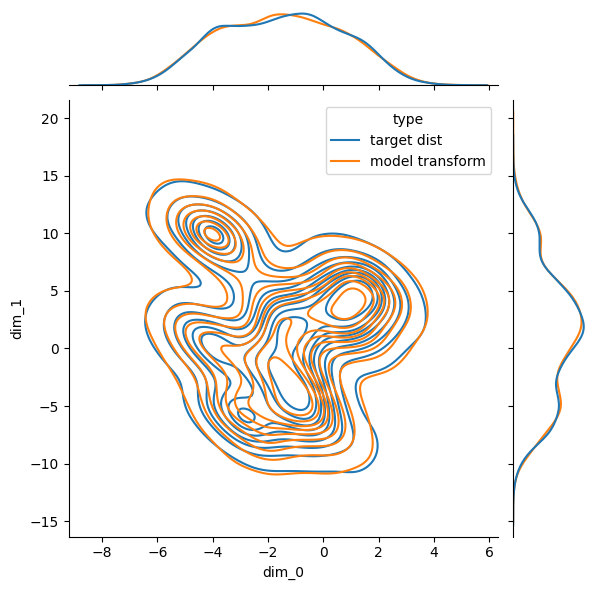

trail: 0 m step: 6 kl_test: 0.0723724365234375


  2%|▏         | 100/6000 [00:31<34:17,  2.87it/s]

trail: 0 m step: 7 Loss: 0.07374023197694134  L_n: 0.06094169616699219  kld: 0.008030891418457031 KLD1: 0.0640912801027298 KLD2: 0.04739098250865936


  3%|▎         | 200/6000 [01:02<33:28,  2.89it/s]

trail: 0 m step: 7 Loss: 0.0895805302029972  L_n: 0.07470893859863281  kld: 0.009331703186035156 KLD1: 0.05640525370836258 KLD2: 0.04821295291185379


  5%|▌         | 300/6000 [01:33<32:54,  2.89it/s]

trail: 0 m step: 7 Loss: 0.08407584891151985  L_n: 0.06731510162353516  kld: 0.010517120361328125 KLD1: 0.06421715021133423 KLD2: 0.053044360131025314


  7%|▋         | 400/6000 [02:05<32:22,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08297063474348407  L_n: 0.06575393676757812  kld: 0.01080322265625 KLD1: 0.05519237369298935 KLD2: 0.047244731336832047


  8%|▊         | 500/6000 [02:36<31:48,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07655676300221399  L_n: 0.06599998474121094  kld: 0.0066242218017578125 KLD1: 0.06843455135822296 KLD2: 0.052916113287210464


 10%|█         | 600/6000 [03:07<31:09,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07596246170141698  L_n: 0.06406974792480469  kld: 0.007462501525878906 KLD1: 0.06846035271883011 KLD2: 0.04566347971558571


 12%|█▏        | 700/6000 [03:39<30:41,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07759738185936721  L_n: 0.05849456787109375  kld: 0.011986732482910156 KLD1: 0.057906895875930786 KLD2: 0.04757404327392578


 13%|█▎        | 800/6000 [04:10<30:06,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08211686613809906  L_n: 0.06724071502685547  kld: 0.009334564208984375 KLD1: 0.0675484836101532 KLD2: 0.038454145193099976


 15%|█▌        | 900/6000 [04:41<29:28,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08018603821740285  L_n: 0.06813526153564453  kld: 0.007561683654785156 KLD1: 0.05602739751338959 KLD2: 0.043943047523498535


 17%|█▋        | 1000/6000 [05:13<28:51,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07785402152680963  L_n: 0.05623435974121094  kld: 0.013566017150878906 KLD1: 0.062252867966890335 KLD2: 0.05280657112598419


 18%|█▊        | 1100/6000 [05:44<28:14,  2.89it/s]

trail: 0 m step: 7 Loss: 0.09729350364245157  L_n: 0.06789684295654297  kld: 0.018445968627929688 KLD1: 0.07051597535610199 KLD2: 0.04714559391140938


 20%|██        | 1200/6000 [06:15<27:44,  2.88it/s]

trail: 0 m step: 7 Loss: 0.1053369831410822  L_n: 0.07560443878173828  kld: 0.01865673065185547 KLD1: 0.06776919215917587 KLD2: 0.05398304760456085


 22%|██▏       | 1300/6000 [06:47<27:08,  2.89it/s]

trail: 0 m step: 7 Loss: 0.1037535371331364  L_n: 0.06875324249267578  kld: 0.02196216583251953 KLD1: 0.06567858904600143 KLD2: 0.052716612815856934


 23%|██▎       | 1400/6000 [07:18<26:29,  2.89it/s]

trail: 0 m step: 7 Loss: 0.10052814535461677  L_n: 0.06925296783447266  kld: 0.019624710083007812 KLD1: 0.0673695057630539 KLD2: 0.05679427459836006


 25%|██▌       | 1500/6000 [07:49<26:00,  2.88it/s]

trail: 0 m step: 7 Loss: 0.0995235716529256  L_n: 0.06830310821533203  kld: 0.019590377807617188 KLD1: 0.06347126513719559 KLD2: 0.05492208153009415


 27%|██▋       | 1600/6000 [08:20<25:25,  2.88it/s]

trail: 0 m step: 7 Loss: 0.10586477170130931  L_n: 0.06937503814697266  kld: 0.022896766662597656 KLD1: 0.06994405388832092 KLD2: 0.06221316382288933


 28%|██▊       | 1700/6000 [08:52<24:48,  2.89it/s]

trail: 0 m step: 7 Loss: 0.10270137296138579  L_n: 0.07329559326171875  kld: 0.018451690673828125 KLD1: 0.0667303204536438 KLD2: 0.0526135228574276


 30%|███       | 1800/6000 [09:23<24:08,  2.90it/s]

trail: 0 m step: 7 Loss: 0.09189878534206793  L_n: 0.06649017333984375  kld: 0.015943527221679688 KLD1: 0.06660570949316025 KLD2: 0.049590691924095154


 32%|███▏      | 1900/6000 [09:54<23:44,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08739692938239187  L_n: 0.06569671630859375  kld: 0.013616561889648438 KLD1: 0.052658140659332275 KLD2: 0.053660403937101364


 33%|███▎      | 2000/6000 [10:25<23:07,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08610241114897005  L_n: 0.061763763427734375  kld: 0.015272140502929688 KLD1: 0.055817533284425735 KLD2: 0.046786077320575714


 35%|███▌      | 2100/6000 [10:57<22:33,  2.88it/s]

trail: 0 m step: 7 Loss: 0.074893804702635  L_n: 0.061809539794921875  kld: 0.008210182189941406 KLD1: 0.06582905352115631 KLD2: 0.04705910384654999


 37%|███▋      | 2200/6000 [11:28<21:59,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08631070704038714  L_n: 0.06648445129394531  kld: 0.012440681457519531 KLD1: 0.05931935831904411 KLD2: 0.05242706090211868


 38%|███▊      | 2300/6000 [11:59<21:17,  2.90it/s]

trail: 0 m step: 7 Loss: 0.07145314922954564  L_n: 0.05659675598144531  kld: 0.009322166442871094 KLD1: 0.06232040748000145 KLD2: 0.043019652366638184


 40%|████      | 2400/6000 [12:31<20:44,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07861654267768775  L_n: 0.06135272979736328  kld: 0.010832786560058594 KLD1: 0.06143038347363472 KLD2: 0.04373103380203247


 42%|████▏     | 2500/6000 [13:02<20:12,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07432173267090919  L_n: 0.058200836181640625  kld: 0.010115623474121094 KLD1: 0.0554029606282711 KLD2: 0.04397981986403465


 43%|████▎     | 2600/6000 [13:33<19:36,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07451467969690734  L_n: 0.058518409729003906  kld: 0.010037422180175781 KLD1: 0.06157802417874336 KLD2: 0.04604852944612503


 45%|████▌     | 2700/6000 [14:04<19:04,  2.88it/s]

trail: 0 m step: 7 Loss: 0.06785970123592247  L_n: 0.05185127258300781  kld: 0.010045051574707031 KLD1: 0.06293497234582901 KLD2: 0.04275847598910332


 47%|████▋     | 2800/6000 [14:36<18:31,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07899292331803343  L_n: 0.06131267547607422  kld: 0.011094093322753906 KLD1: 0.052703067660331726 KLD2: 0.048130929470062256


 48%|████▊     | 2900/6000 [15:07<17:54,  2.88it/s]

trail: 0 m step: 7 Loss: 0.08047578825380779  L_n: 0.06536102294921875  kld: 0.009484291076660156 KLD1: 0.0617213249206543 KLD2: 0.04859340563416481


 50%|█████     | 3000/6000 [15:38<17:23,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07724637875958021  L_n: 0.06431865692138672  kld: 0.008111953735351562 KLD1: 0.05669174715876579 KLD2: 0.04817589744925499


 52%|█████▏    | 3100/6000 [16:10<16:44,  2.89it/s]

trail: 0 m step: 7 Loss: 0.08043005958827244  L_n: 0.06619071960449219  kld: 0.008934974670410156 KLD1: 0.06478406488895416 KLD2: 0.04769083112478256


 53%|█████▎    | 3200/6000 [16:41<16:11,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07816080511602763  L_n: 0.05924797058105469  kld: 0.011867523193359375 KLD1: 0.05409320071339607 KLD2: 0.048193126916885376


 55%|█████▌    | 3300/6000 [17:12<15:36,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07170809035952946  L_n: 0.059807777404785156  kld: 0.0074672698974609375 KLD1: 0.04713298752903938 KLD2: 0.04648299887776375


 57%|█████▋    | 3400/6000 [17:44<15:01,  2.88it/s]

trail: 0 m step: 7 Loss: 0.07423230513877045  L_n: 0.06046867370605469  kld: 0.008636474609375 KLD1: 0.06330318748950958 KLD2: 0.04568011313676834


 58%|█████▊    | 3500/6000 [18:15<14:27,  2.88it/s]

trail: 0 m step: 7 Loss: 0.06186061053136918  L_n: 0.04908943176269531  kld: 0.008013725280761719 KLD1: 0.05567116662859917 KLD2: 0.04039047285914421


 60%|██████    | 3600/6000 [18:46<13:52,  2.88it/s]

trail: 0 m step: 7 Loss: 0.0763756767855574  L_n: 0.06076240539550781  kld: 0.009797096252441406 KLD1: 0.055199407041072845 KLD2: 0.04649355262517929


 62%|██████▏   | 3700/6000 [19:18<13:15,  2.89it/s]

trail: 0 m step: 7 Loss: 0.062379751820940216  L_n: 0.048783302307128906  kld: 0.008531570434570312 KLD1: 0.0535285621881485 KLD2: 0.048407040536403656


 63%|██████▎   | 3800/6000 [19:49<12:42,  2.88it/s]

trail: 0 m step: 7 Loss: 0.06898191029754841  L_n: 0.05520915985107422  kld: 0.008642196655273438 KLD1: 0.058589305728673935 KLD2: 0.04442279040813446


 65%|██████▌   | 3900/6000 [20:20<12:07,  2.89it/s]

trail: 0 m step: 7 Loss: 0.08554217695379915  L_n: 0.07140922546386719  kld: 0.008868217468261719 KLD1: 0.0606711283326149 KLD2: 0.0502031184732914


 67%|██████▋   | 4000/6000 [20:52<11:32,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07270675333949271  L_n: 0.05619525909423828  kld: 0.0103607177734375 KLD1: 0.055409207940101624 KLD2: 0.04878194257616997


 68%|██████▊   | 4100/6000 [21:23<10:56,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06479250964800914  L_n: 0.05377674102783203  kld: 0.0069122314453125 KLD1: 0.05466005578637123 KLD2: 0.04218555614352226


 70%|███████   | 4200/6000 [21:54<10:22,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06011077451617913  L_n: 0.05020904541015625  kld: 0.006213188171386719 KLD1: 0.0531497560441494 KLD2: 0.042091064155101776


 72%|███████▏  | 4300/6000 [22:25<09:49,  2.88it/s]

trail: 0 m step: 7 Loss: 0.060764800029066875  L_n: 0.04947090148925781  kld: 0.007086753845214844 KLD1: 0.047944024205207825 KLD2: 0.043204836547374725


 73%|███████▎  | 4400/6000 [22:57<09:14,  2.88it/s]

trail: 0 m step: 7 Loss: 0.06536373564732083  L_n: 0.05443763732910156  kld: 0.006855964660644531 KLD1: 0.05619356408715248 KLD2: 0.0460997000336647


 75%|███████▌  | 4500/6000 [23:28<08:38,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06352398601427689  L_n: 0.054920196533203125  kld: 0.005398750305175781 KLD1: 0.05274350568652153 KLD2: 0.04233526065945625


 77%|███████▋  | 4600/6000 [23:59<08:06,  2.88it/s]

trail: 0 m step: 7 Loss: 0.0645686193374407  L_n: 0.05600738525390625  kld: 0.005372047424316406 KLD1: 0.05320795252919197 KLD2: 0.041536349803209305


 78%|███████▊  | 4700/6000 [24:30<07:30,  2.88it/s]

trail: 0 m step: 7 Loss: 0.06349374303383673  L_n: 0.055006980895996094  kld: 0.0053253173828125 KLD1: 0.05345424637198448 KLD2: 0.043549902737140656


 80%|████████  | 4800/6000 [25:02<06:55,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06444858628159966  L_n: 0.052802085876464844  kld: 0.007308006286621094 KLD1: 0.048687368631362915 KLD2: 0.040914516896009445


 82%|████████▏ | 4900/6000 [25:33<06:21,  2.89it/s]

trail: 0 m step: 7 Loss: 0.054783614452326275  L_n: 0.04552173614501953  kld: 0.0058116912841796875 KLD1: 0.06000440567731857 KLD2: 0.041790563613176346


 83%|████████▎ | 5000/6000 [26:04<05:46,  2.88it/s]

trail: 0 m step: 7 Loss: 0.05707772281234556  L_n: 0.04809093475341797  kld: 0.005639076232910156 KLD1: 0.05439295992255211 KLD2: 0.044083695858716965


 85%|████████▌ | 5100/6000 [26:36<05:11,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06817211988379397  L_n: 0.05983734130859375  kld: 0.005229949951171875 KLD1: 0.05816788226366043 KLD2: 0.042510006576776505


 87%|████████▋ | 5200/6000 [27:07<04:36,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06482814122856663  L_n: 0.054139137268066406  kld: 0.006707191467285156 KLD1: 0.04920153319835663 KLD2: 0.046862389892339706


 88%|████████▊ | 5300/6000 [27:38<04:02,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06368602158357047  L_n: 0.05563545227050781  kld: 0.005051612854003906 KLD1: 0.05885044485330582 KLD2: 0.04145511984825134


 90%|█████████ | 5400/6000 [28:10<03:28,  2.88it/s]

trail: 0 m step: 7 Loss: 0.060144591528080646  L_n: 0.04953765869140625  kld: 0.006655693054199219 KLD1: 0.05338902398943901 KLD2: 0.04146852344274521


 92%|█████████▏| 5500/6000 [28:41<02:52,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06400629712161146  L_n: 0.055771827697753906  kld: 0.0051670074462890625 KLD1: 0.05180929973721504 KLD2: 0.04318830370903015


 93%|█████████▎| 5600/6000 [29:12<02:18,  2.89it/s]

trail: 0 m step: 7 Loss: 0.07032396329557354  L_n: 0.058096885681152344  kld: 0.007672309875488281 KLD1: 0.052435070276260376 KLD2: 0.041135892271995544


 95%|█████████▌| 5700/6000 [29:43<01:43,  2.89it/s]

trail: 0 m step: 7 Loss: 0.0660077801599567  L_n: 0.05592823028564453  kld: 0.00632476806640625 KLD1: 0.05770488828420639 KLD2: 0.038648854941129684


 97%|█████████▋| 5800/6000 [30:15<01:09,  2.89it/s]

trail: 0 m step: 7 Loss: 0.062247231907726124  L_n: 0.04885292053222656  kld: 0.008404731750488281 KLD1: 0.059509024024009705 KLD2: 0.04206197336316109


 98%|█████████▊| 5900/6000 [30:46<00:34,  2.89it/s]

trail: 0 m step: 7 Loss: 0.06092824568806973  L_n: 0.051453590393066406  kld: 0.0059452056884765625 KLD1: 0.0508030503988266 KLD2: 0.04551902413368225


100%|██████████| 6000/6000 [31:17<00:00,  3.20it/s]

trail: 0 m step: 7 Loss: 0.05811885472191583  L_n: 0.050548553466796875  kld: 0.004750251770019531 KLD1: 0.060477446764707565 KLD2: 0.03451049327850342



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


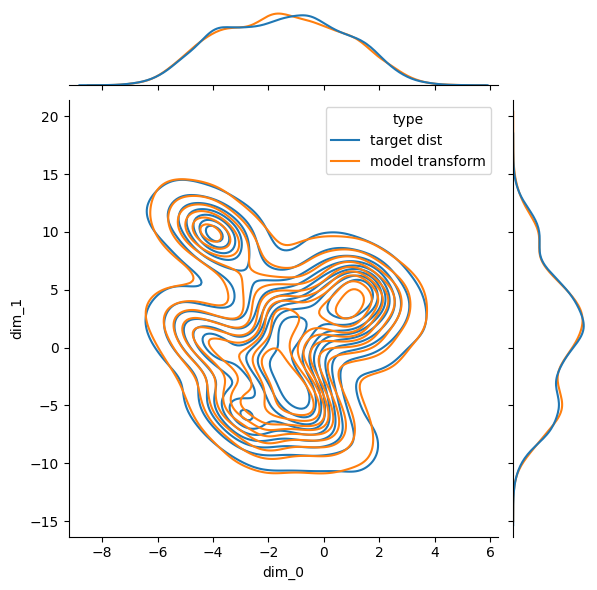

trail: 0 m step: 7 kl_test: 0.05227470397949219


  2%|▏         | 100/6000 [00:31<34:10,  2.88it/s]

trail: 0 m step: 8 Loss: 0.056111058906487814  L_n: 0.04842185974121094  kld: 0.006272315979003906 KLD1: 0.04531044140458107 KLD2: 0.03954622521996498


  3%|▎         | 200/6000 [01:02<33:20,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06873731494811765  L_n: 0.060082435607910156  kld: 0.007060050964355469 KLD1: 0.05549111217260361 KLD2: 0.04141496866941452


  5%|▌         | 300/6000 [01:33<32:42,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06406319208509009  L_n: 0.056418418884277344  kld: 0.006236076354980469 KLD1: 0.05054166913032532 KLD2: 0.04782192409038544


  7%|▋         | 400/6000 [02:04<32:13,  2.90it/s]

trail: 0 m step: 8 Loss: 0.058202312683831726  L_n: 0.052651405334472656  kld: 0.004528045654296875 KLD1: 0.04397527500987053 KLD2: 0.03651950880885124


  8%|▊         | 500/6000 [02:36<31:36,  2.90it/s]

trail: 0 m step: 8 Loss: 0.062315693519560664  L_n: 0.05592536926269531  kld: 0.0052127838134765625 KLD1: 0.04572037234902382 KLD2: 0.043492391705513


 10%|█         | 600/6000 [03:07<31:07,  2.89it/s]

trail: 0 m step: 8 Loss: 0.05182321389298159  L_n: 0.04587364196777344  kld: 0.004853248596191406 KLD1: 0.04882889240980148 KLD2: 0.04008452594280243


 12%|█▏        | 700/6000 [03:38<30:27,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06772896840495116  L_n: 0.053165435791015625  kld: 0.011879920959472656 KLD1: 0.04431106522679329 KLD2: 0.04252570867538452


 13%|█▎        | 800/6000 [04:09<29:48,  2.91it/s]

trail: 0 m step: 8 Loss: 0.06496510638831891  L_n: 0.05411815643310547  kld: 0.008848190307617188 KLD1: 0.05124936252832413 KLD2: 0.035457685589790344


 15%|█▌        | 900/6000 [04:40<29:13,  2.91it/s]

trail: 0 m step: 8 Loss: 0.058550354030417306  L_n: 0.047710418701171875  kld: 0.00884246826171875 KLD1: 0.04696220904588699 KLD2: 0.04055651277303696


 17%|█▋        | 1000/6000 [05:11<28:39,  2.91it/s]

trail: 0 m step: 8 Loss: 0.054495090903484755  L_n: 0.04741382598876953  kld: 0.005776405334472656 KLD1: 0.0485445037484169 KLD2: 0.04747961461544037


 18%|█▊        | 1100/6000 [05:43<28:11,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06428341676945129  L_n: 0.05553150177001953  kld: 0.0071392059326171875 KLD1: 0.044117990881204605 KLD2: 0.03829687833786011


 20%|██        | 1200/6000 [06:14<27:35,  2.90it/s]

trail: 0 m step: 8 Loss: 0.062262701359112105  L_n: 0.052692413330078125  kld: 0.0078067779541015625 KLD1: 0.050971657037734985 KLD2: 0.044769492000341415


 22%|██▏       | 1300/6000 [06:45<26:59,  2.90it/s]

trail: 0 m step: 8 Loss: 0.07133306928417779  L_n: 0.05703258514404297  kld: 0.01166534423828125 KLD1: 0.054995421320199966 KLD2: 0.04241793975234032


 23%|██▎       | 1400/6000 [07:16<26:27,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06889250006450846  L_n: 0.052367210388183594  kld: 0.013480186462402344 KLD1: 0.05572756379842758 KLD2: 0.04937131330370903


 25%|██▌       | 1500/6000 [07:47<25:51,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06464184292931713  L_n: 0.04950428009033203  kld: 0.012348175048828125 KLD1: 0.050156958401203156 KLD2: 0.04404383897781372


 27%|██▋       | 1600/6000 [08:18<25:22,  2.89it/s]

trail: 0 m step: 8 Loss: 0.05922856704524848  L_n: 0.05014228820800781  kld: 0.007411956787109375 KLD1: 0.053961705416440964 KLD2: 0.04778718575835228


 28%|██▊       | 1700/6000 [08:50<24:43,  2.90it/s]

trail: 0 m step: 8 Loss: 0.07084008351806288  L_n: 0.05266284942626953  kld: 0.014827728271484375 KLD1: 0.054519083350896835 KLD2: 0.04386362060904503


 30%|███       | 1800/6000 [09:21<24:08,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06739369727622285  L_n: 0.051239013671875  kld: 0.013177871704101562 KLD1: 0.05964118614792824 KLD2: 0.04672475531697273


 32%|███▏      | 1900/6000 [09:52<23:35,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06671602553285166  L_n: 0.054533958435058594  kld: 0.009937286376953125 KLD1: 0.04977945610880852 KLD2: 0.04505244269967079


 33%|███▎      | 2000/6000 [10:23<23:00,  2.90it/s]

trail: 0 m step: 8 Loss: 0.07111245992345479  L_n: 0.055571556091308594  kld: 0.012677192687988281 KLD1: 0.05391685664653778 KLD2: 0.041950568556785583


 35%|███▌      | 2100/6000 [10:55<22:31,  2.89it/s]

trail: 0 m step: 8 Loss: 0.06264300740137155  L_n: 0.05342578887939453  kld: 0.007518768310546875 KLD1: 0.056525833904743195 KLD2: 0.04082683473825455


 37%|███▋      | 2200/6000 [11:26<21:52,  2.89it/s]

trail: 0 m step: 8 Loss: 0.061116006573133076  L_n: 0.05167198181152344  kld: 0.0077037811279296875 KLD1: 0.04491928592324257 KLD2: 0.045148663222789764


 38%|███▊      | 2300/6000 [11:57<21:14,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0658637850197626  L_n: 0.05402660369873047  kld: 0.009655952453613281 KLD1: 0.0484640933573246 KLD2: 0.03816458210349083


 40%|████      | 2400/6000 [12:28<20:40,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0627751999148007  L_n: 0.05269050598144531  kld: 0.008226394653320312 KLD1: 0.055122461169958115 KLD2: 0.04062412306666374


 42%|████▏     | 2500/6000 [12:59<20:06,  2.90it/s]

trail: 0 m step: 8 Loss: 0.061417804949425225  L_n: 0.04889202117919922  kld: 0.010217666625976562 KLD1: 0.050032660365104675 KLD2: 0.03848865255713463


 43%|████▎     | 2600/6000 [13:31<19:29,  2.91it/s]

trail: 0 m step: 8 Loss: 0.06247056180976936  L_n: 0.05047321319580078  kld: 0.009786605834960938 KLD1: 0.054158929735422134 KLD2: 0.03504114970564842


 45%|████▌     | 2700/6000 [14:02<19:01,  2.89it/s]

trail: 0 m step: 8 Loss: 0.05519452227644101  L_n: 0.046568870544433594  kld: 0.0070362091064453125 KLD1: 0.05051212012767792 KLD2: 0.03761932998895645


 47%|████▋     | 2800/6000 [14:33<18:21,  2.91it/s]

trail: 0 m step: 8 Loss: 0.0509132819100369  L_n: 0.043732643127441406  kld: 0.0058574676513671875 KLD1: 0.03595985472202301 KLD2: 0.03739645332098007


 48%|████▊     | 2900/6000 [15:04<17:49,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0575390400339959  L_n: 0.049102783203125  kld: 0.0068817138671875 KLD1: 0.048188939690589905 KLD2: 0.03997434675693512


 50%|█████     | 3000/6000 [15:35<17:13,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05812869987480396  L_n: 0.04994964599609375  kld: 0.006671905517578125 KLD1: 0.047794159501791 KLD2: 0.042086999863386154


 52%|█████▏    | 3100/6000 [16:06<16:37,  2.91it/s]

trail: 0 m step: 8 Loss: 0.054049291128083925  L_n: 0.0461578369140625  kld: 0.0064373016357421875 KLD1: 0.042787130922079086 KLD2: 0.03776153177022934


 53%|█████▎    | 3200/6000 [16:38<16:03,  2.91it/s]

trail: 0 m step: 8 Loss: 0.060505231981043864  L_n: 0.05095481872558594  kld: 0.007790565490722656 KLD1: 0.050926364958286285 KLD2: 0.04048170894384384


 55%|█████▌    | 3300/6000 [17:09<15:32,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05546310989985975  L_n: 0.04313373565673828  kld: 0.010057449340820312 KLD1: 0.050129543989896774 KLD2: 0.04234093800187111


 57%|█████▋    | 3400/6000 [17:40<14:58,  2.89it/s]

trail: 0 m step: 8 Loss: 0.058908434638928274  L_n: 0.04989814758300781  kld: 0.007349967956542969 KLD1: 0.04643581807613373 KLD2: 0.04034600406885147


 58%|█████▊    | 3500/6000 [18:11<14:21,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05730827595219405  L_n: 0.046387672424316406  kld: 0.008908271789550781 KLD1: 0.05292500928044319 KLD2: 0.03689993545413017


 60%|██████    | 3600/6000 [18:42<13:48,  2.90it/s]

trail: 0 m step: 8 Loss: 0.07179928150937334  L_n: 0.05637645721435547  kld: 0.01258087158203125 KLD1: 0.0473548099398613 KLD2: 0.045816875994205475


 62%|██████▏   | 3700/6000 [19:13<13:16,  2.89it/s]

trail: 0 m step: 8 Loss: 0.05990727417636309  L_n: 0.04742240905761719  kld: 0.010184288024902344 KLD1: 0.04624219238758087 KLD2: 0.043976616114377975


 63%|██████▎   | 3800/6000 [19:45<12:38,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0634859284125103  L_n: 0.052188873291015625  kld: 0.009215354919433594 KLD1: 0.05651141330599785 KLD2: 0.037668731063604355


 65%|██████▌   | 3900/6000 [20:16<12:04,  2.90it/s]

trail: 0 m step: 8 Loss: 0.06653831544244623  L_n: 0.058037757873535156  kld: 0.006934165954589844 KLD1: 0.048066411167383194 KLD2: 0.042339619249105453


 67%|██████▋   | 4000/6000 [20:47<11:31,  2.89it/s]

trail: 0 m step: 8 Loss: 0.055800012314675185  L_n: 0.044623374938964844  kld: 0.00911712646484375 KLD1: 0.05180706828832626 KLD2: 0.042521581053733826


 68%|██████▊   | 4100/6000 [21:18<10:54,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05392282729257343  L_n: 0.044243812561035156  kld: 0.007895469665527344 KLD1: 0.05371237173676491 KLD2: 0.03849891945719719


 70%|███████   | 4200/6000 [21:50<10:19,  2.90it/s]

trail: 0 m step: 8 Loss: 0.057880022368572745  L_n: 0.05033111572265625  kld: 0.006157875061035156 KLD1: 0.052612558007240295 KLD2: 0.0380447655916214


 72%|███████▏  | 4300/6000 [22:21<09:47,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05832936037922226  L_n: 0.05030345916748047  kld: 0.006546974182128906 KLD1: 0.039778802543878555 KLD2: 0.040329787880182266


 73%|███████▎  | 4400/6000 [22:52<09:12,  2.90it/s]

trail: 0 m step: 8 Loss: 0.055951089585074346  L_n: 0.044818878173828125  kld: 0.009080886840820312 KLD1: 0.04663237929344177 KLD2: 0.04084295034408569


 75%|███████▌  | 4500/6000 [23:23<08:37,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05206940582404201  L_n: 0.04497528076171875  kld: 0.005786895751953125 KLD1: 0.04615853726863861 KLD2: 0.039960525929927826


 77%|███████▋  | 4600/6000 [23:54<08:04,  2.89it/s]

trail: 0 m step: 8 Loss: 0.045913371859345  L_n: 0.03760337829589844  kld: 0.006778717041015625 KLD1: 0.04809273034334183 KLD2: 0.03941766917705536


 78%|███████▊  | 4700/6000 [24:26<07:28,  2.90it/s]

trail: 0 m step: 8 Loss: 0.052148615605341606  L_n: 0.04429340362548828  kld: 0.006407737731933594 KLD1: 0.044427540153265 KLD2: 0.038738708943128586


 80%|████████  | 4800/6000 [24:57<06:52,  2.91it/s]

trail: 0 m step: 8 Loss: 0.05257483213084441  L_n: 0.04534626007080078  kld: 0.005896568298339844 KLD1: 0.04534308984875679 KLD2: 0.036888379603624344


 82%|████████▏ | 4900/6000 [25:28<06:19,  2.90it/s]

trail: 0 m step: 8 Loss: 0.054283879948258784  L_n: 0.047883033752441406  kld: 0.005221366882324219 KLD1: 0.041635703295469284 KLD2: 0.03596875071525574


 83%|████████▎ | 5000/6000 [25:59<05:44,  2.90it/s]

trail: 0 m step: 8 Loss: 0.053107078974751545  L_n: 0.04453754425048828  kld: 0.0069904327392578125 KLD1: 0.04605047404766083 KLD2: 0.04145526513457298


 85%|████████▌ | 5100/6000 [26:30<05:10,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05534775906724546  L_n: 0.04668235778808594  kld: 0.007068634033203125 KLD1: 0.0439629852771759 KLD2: 0.03895008936524391


 87%|████████▋ | 5200/6000 [27:02<04:35,  2.91it/s]

trail: 0 m step: 8 Loss: 0.052515606349725366  L_n: 0.04365730285644531  kld: 0.007225990295410156 KLD1: 0.04421504586935043 KLD2: 0.0404309444129467


 88%|████████▊ | 5300/6000 [27:33<04:01,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05282983019146243  L_n: 0.04392242431640625  kld: 0.007266044616699219 KLD1: 0.04693324491381645 KLD2: 0.03598931059241295


 90%|█████████ | 5400/6000 [28:04<03:26,  2.90it/s]

trail: 0 m step: 8 Loss: 0.05228814899923989  L_n: 0.04458141326904297  kld: 0.00628662109375 KLD1: 0.04501980170607567 KLD2: 0.039726268500089645


 92%|█████████▏| 5500/6000 [28:35<02:52,  2.91it/s]

trail: 0 m step: 8 Loss: 0.05868111361517206  L_n: 0.05021095275878906  kld: 0.006909370422363281 KLD1: 0.046732526272535324 KLD2: 0.03798917308449745


 93%|█████████▎| 5600/6000 [29:06<02:17,  2.91it/s]

trail: 0 m step: 8 Loss: 0.056232101262207124  L_n: 0.047011375427246094  kld: 0.007521629333496094 KLD1: 0.04287120699882507 KLD2: 0.03500327840447426


 95%|█████████▌| 5700/6000 [29:37<01:43,  2.91it/s]

trail: 0 m step: 8 Loss: 0.05041873210880767  L_n: 0.043137550354003906  kld: 0.005939483642578125 KLD1: 0.04940345883369446 KLD2: 0.03260904550552368


 97%|█████████▋| 5800/6000 [30:09<01:08,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0595177857442436  L_n: 0.05158424377441406  kld: 0.0064716339111328125 KLD1: 0.049939315766096115 KLD2: 0.03780646249651909


 98%|█████████▊| 5900/6000 [30:40<00:34,  2.90it/s]

trail: 0 m step: 8 Loss: 0.055944735098806944  L_n: 0.046332359313964844  kld: 0.007841110229492188 KLD1: 0.041950203478336334 KLD2: 0.04327007755637169


100%|██████████| 6000/6000 [31:11<00:00,  3.21it/s]

trail: 0 m step: 8 Loss: 0.053180409702001795  L_n: 0.04517555236816406  kld: 0.006529808044433594 KLD1: 0.04712674021720886 KLD2: 0.033147796988487244



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


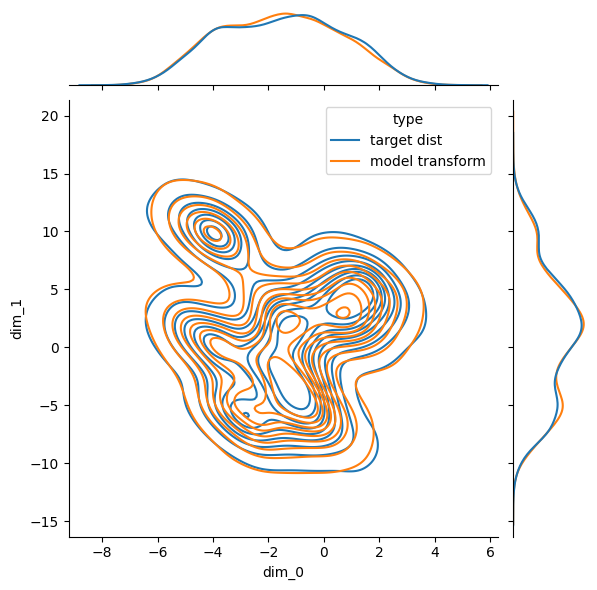

trail: 0 m step: 8 kl_test: 0.04107093811035156


  2%|▏         | 100/6000 [00:31<34:18,  2.87it/s]

trail: 0 m step: 9 Loss: 0.05995030115626351  L_n: 0.05150127410888672  kld: 0.008959770202636719 KLD1: 0.0424765907227993 KLD2: 0.04810625687241554


  3%|▎         | 200/6000 [01:02<33:19,  2.90it/s]

trail: 0 m step: 9 Loss: 0.11383035985014917  L_n: 0.078582763671875  kld: 0.03737831115722656 KLD1: 0.07643357664346695 KLD2: 0.06192568317055702


  5%|▌         | 300/6000 [01:33<32:56,  2.88it/s]

trail: 0 m step: 9 Loss: 0.07332792124216721  L_n: 0.055846214294433594  kld: 0.018538475036621094 KLD1: 0.05038589984178543 KLD2: 0.05344787612557411


  7%|▋         | 400/6000 [02:05<32:19,  2.89it/s]

trail: 0 m step: 9 Loss: 0.08001809190287389  L_n: 0.06173419952392578  kld: 0.01938915252685547 KLD1: 0.05818384885787964 KLD2: 0.046992167830467224


  8%|▊         | 500/6000 [02:36<31:43,  2.89it/s]

trail: 0 m step: 9 Loss: 0.08436636633426603  L_n: 0.059906005859375  kld: 0.025938987731933594 KLD1: 0.06637053191661835 KLD2: 0.05947829410433769


 10%|█         | 600/6000 [03:07<31:07,  2.89it/s]

trail: 0 m step: 9 Loss: 0.08149429619558143  L_n: 0.06174182891845703  kld: 0.020946502685546875 KLD1: 0.06313154101371765 KLD2: 0.05824693292379379


 12%|█▏        | 700/6000 [03:38<30:30,  2.90it/s]

trail: 0 m step: 9 Loss: 0.07278181055830424  L_n: 0.06073284149169922  kld: 0.012777328491210938 KLD1: 0.046969830989837646 KLD2: 0.05348572880029678


 13%|█▎        | 800/6000 [04:10<29:56,  2.89it/s]

trail: 0 m step: 9 Loss: 0.07071033928775713  L_n: 0.05798149108886719  kld: 0.013498306274414062 KLD1: 0.05881515517830849 KLD2: 0.04240664094686508


 15%|█▌        | 900/6000 [04:41<29:22,  2.89it/s]

trail: 0 m step: 9 Loss: 0.06660532316821037  L_n: 0.05623626708984375  kld: 0.010995864868164062 KLD1: 0.05499693378806114 KLD2: 0.044685039669275284


 17%|█▋        | 1000/6000 [05:12<28:41,  2.90it/s]

trail: 0 m step: 9 Loss: 0.060231430140442146  L_n: 0.05002784729003906  kld: 0.010820388793945312 KLD1: 0.04180261120200157 KLD2: 0.04707883670926094


 18%|█▊        | 1100/6000 [05:43<28:12,  2.89it/s]

trail: 0 m step: 9 Loss: 0.06559474700439243  L_n: 0.05546760559082031  kld: 0.010739326477050781 KLD1: 0.04960500821471214 KLD2: 0.04783652350306511


 20%|██        | 1200/6000 [06:14<27:35,  2.90it/s]

trail: 0 m step: 9 Loss: 0.059676714620669695  L_n: 0.051166534423828125  kld: 0.009024620056152344 KLD1: 0.04379921406507492 KLD2: 0.047453686594963074


 22%|██▏       | 1300/6000 [06:46<27:04,  2.89it/s]

trail: 0 m step: 9 Loss: 0.0663294567710893  L_n: 0.05620861053466797  kld: 0.010732650756835938 KLD1: 0.05312164127826691 KLD2: 0.04483555257320404


 23%|██▎       | 1400/6000 [07:17<26:29,  2.89it/s]

trail: 0 m step: 9 Loss: 0.059841734110096446  L_n: 0.047214508056640625  kld: 0.013390541076660156 KLD1: 0.054292380809783936 KLD2: 0.05036592110991478


 25%|██▌       | 1500/6000 [07:48<25:56,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05707998348312358  L_n: 0.04458045959472656  kld: 0.013255119323730469 KLD1: 0.047352030873298645 KLD2: 0.03799910843372345


 27%|██▋       | 1600/6000 [08:19<25:18,  2.90it/s]

trail: 0 m step: 9 Loss: 0.07860130671861713  L_n: 0.051662445068359375  kld: 0.02856731414794922 KLD1: 0.050067637115716934 KLD2: 0.05205175653100014


 28%|██▊       | 1700/6000 [08:50<24:48,  2.89it/s]

trail: 0 m step: 9 Loss: 0.07056703564513579  L_n: 0.0512237548828125  kld: 0.02051258087158203 KLD1: 0.04117095097899437 KLD2: 0.04235526919364929


 30%|███       | 1800/6000 [09:22<24:12,  2.89it/s]

trail: 0 m step: 9 Loss: 0.06158079498816681  L_n: 0.04528617858886719  kld: 0.017279624938964844 KLD1: 0.0430428571999073 KLD2: 0.04217222332954407


 32%|███▏      | 1900/6000 [09:53<23:36,  2.89it/s]

trail: 0 m step: 9 Loss: 0.0656515095535006  L_n: 0.05215644836425781  kld: 0.014310836791992188 KLD1: 0.04688531160354614 KLD2: 0.0515112578868866


 33%|███▎      | 2000/6000 [10:24<23:01,  2.89it/s]

trail: 0 m step: 9 Loss: 0.04606932901333603  L_n: 0.03556537628173828  kld: 0.011138916015625 KLD1: 0.04290425777435303 KLD2: 0.03537716343998909


 35%|███▌      | 2100/6000 [10:55<22:27,  2.89it/s]

trail: 0 m step: 9 Loss: 0.04659500741384551  L_n: 0.040259361267089844  kld: 0.006718635559082031 KLD1: 0.03953423351049423 KLD2: 0.035969577729701996


 37%|███▋      | 2200/6000 [11:27<21:50,  2.90it/s]

trail: 0 m step: 9 Loss: 0.05089952818394151  L_n: 0.042601585388183594  kld: 0.008799552917480469 KLD1: 0.04414739832282066 KLD2: 0.040661491453647614


 38%|███▊      | 2300/6000 [11:58<21:20,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05367291008310469  L_n: 0.046196937561035156  kld: 0.007927894592285156 KLD1: 0.049571406096220016 KLD2: 0.03689155355095863


 40%|████      | 2400/6000 [12:29<20:41,  2.90it/s]

trail: 0 m step: 9 Loss: 0.04760620134361251  L_n: 0.040534019470214844  kld: 0.00749969482421875 KLD1: 0.04117700085043907 KLD2: 0.03620120882987976


 42%|████▏     | 2500/6000 [13:00<20:09,  2.89it/s]

trail: 0 m step: 9 Loss: 0.04890140859653387  L_n: 0.04121589660644531  kld: 0.008150100708007812 KLD1: 0.04591544717550278 KLD2: 0.03582850843667984


 43%|████▎     | 2600/6000 [13:32<19:37,  2.89it/s]

trail: 0 m step: 9 Loss: 0.051478345013544057  L_n: 0.04527759552001953  kld: 0.006575584411621094 KLD1: 0.0478423610329628 KLD2: 0.03629534691572189


 45%|████▌     | 2700/6000 [14:03<19:01,  2.89it/s]

trail: 0 m step: 9 Loss: 0.048936259789345855  L_n: 0.04327869415283203  kld: 0.005999565124511719 KLD1: 0.04548317566514015 KLD2: 0.03724271059036255


 47%|████▋     | 2800/6000 [14:34<18:26,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05904262422012666  L_n: 0.04742622375488281  kld: 0.012318611145019531 KLD1: 0.04370143264532089 KLD2: 0.039955984801054


 48%|████▊     | 2900/6000 [15:06<17:53,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05635167961752351  L_n: 0.04808521270751953  kld: 0.00876617431640625 KLD1: 0.039651013910770416 KLD2: 0.040056969970464706


 50%|█████     | 3000/6000 [15:37<17:17,  2.89it/s]

trail: 0 m step: 9 Loss: 0.051519731242348064  L_n: 0.04256439208984375  kld: 0.009496688842773438 KLD1: 0.045409347862005234 KLD2: 0.03947632387280464


 52%|█████▏    | 3100/6000 [16:08<16:42,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05301282151359775  L_n: 0.04375171661376953  kld: 0.009820938110351562 KLD1: 0.04141240566968918 KLD2: 0.0368896946310997


 53%|█████▎    | 3200/6000 [16:39<16:09,  2.89it/s]

trail: 0 m step: 9 Loss: 0.060431683363101237  L_n: 0.05238914489746094  kld: 0.008528709411621094 KLD1: 0.04330706223845482 KLD2: 0.04580054432153702


 55%|█████▌    | 3300/6000 [17:11<15:32,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05212683767893234  L_n: 0.04633617401123047  kld: 0.006140708923339844 KLD1: 0.04275956749916077 KLD2: 0.04090578481554985


 57%|█████▋    | 3400/6000 [17:42<15:00,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05105340442079482  L_n: 0.043628692626953125  kld: 0.00787353515625 KLD1: 0.047828398644924164 KLD2: 0.041873589158058167


 58%|█████▊    | 3500/6000 [18:13<14:25,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05028382801238372  L_n: 0.04278087615966797  kld: 0.007956504821777344 KLD1: 0.04389306902885437 KLD2: 0.033253014087677


 60%|██████    | 3600/6000 [18:45<13:51,  2.89it/s]

trail: 0 m step: 9 Loss: 0.05011348015915931  L_n: 0.04201698303222656  kld: 0.008585929870605469 KLD1: 0.0394432470202446 KLD2: 0.03833737224340439


 62%|██████▏   | 3700/6000 [19:16<13:17,  2.88it/s]

trail: 0 m step: 9 Loss: 0.04849853038433879  L_n: 0.042052268981933594  kld: 0.0068359375 KLD1: 0.03930909186601639 KLD2: 0.03972570598125458


 63%|██████▎   | 3800/6000 [19:47<12:42,  2.89it/s]

trail: 0 m step: 9 Loss: 0.047937459766861944  L_n: 0.04211711883544922  kld: 0.00617218017578125 KLD1: 0.0418364554643631 KLD2: 0.03515993803739548


 65%|██████▌   | 3900/6000 [20:18<12:04,  2.90it/s]

trail: 0 m step: 9 Loss: 0.05059261462514823  L_n: 0.04447460174560547  kld: 0.006487846374511719 KLD1: 0.040269628167152405 KLD2: 0.03648291900753975


 67%|██████▋   | 4000/6000 [20:50<11:30,  2.90it/s]

trail: 0 m step: 9 Loss: 0.051589283826588034  L_n: 0.044005393981933594  kld: 0.008042335510253906 KLD1: 0.03863899037241936 KLD2: 0.039573945105075836


 68%|██████▊   | 4100/6000 [21:21<10:55,  2.90it/s]

trail: 0 m step: 9 Loss: 0.054633162358189644  L_n: 0.04726600646972656  kld: 0.0078125 KLD1: 0.04450537636876106 KLD2: 0.03466831147670746


 70%|███████   | 4200/6000 [21:52<10:22,  2.89it/s]

trail: 0 m step: 9 Loss: 0.049593000851669886  L_n: 0.0434722900390625  kld: 0.0064907073974609375 KLD1: 0.047540124505758286 KLD2: 0.03894830867648125


 72%|███████▏  | 4300/6000 [22:23<09:46,  2.90it/s]

trail: 0 m step: 9 Loss: 0.04807595752300944  L_n: 0.04301643371582031  kld: 0.0053653717041015625 KLD1: 0.03493368625640869 KLD2: 0.03862646222114563


 73%|███████▎  | 4400/6000 [22:55<09:11,  2.90it/s]

trail: 0 m step: 9 Loss: 0.05099269312086701  L_n: 0.04636573791503906  kld: 0.004906654357910156 KLD1: 0.037362754344940186 KLD2: 0.039013076573610306


 75%|███████▌  | 4500/6000 [23:26<08:36,  2.90it/s]

trail: 0 m step: 9 Loss: 0.04605493168073105  L_n: 0.042285919189453125  kld: 0.003996849060058594 KLD1: 0.03967544436454773 KLD2: 0.04073270037770271


 77%|███████▋  | 4600/6000 [23:57<08:02,  2.90it/s]

trail: 0 m step: 9 Loss: 0.04176863929977263  L_n: 0.03792858123779297  kld: 0.0040721893310546875 KLD1: 0.03670245409011841 KLD2: 0.03774847090244293


 78%|███████▊  | 4700/6000 [24:28<07:29,  2.89it/s]

trail: 0 m step: 9 Loss: 0.051397712344677465  L_n: 0.048201560974121094  kld: 0.0033893585205078125 KLD1: 0.03733570873737335 KLD2: 0.037635788321495056


 80%|████████  | 4800/6000 [24:59<06:54,  2.89it/s]

trail: 0 m step: 9 Loss: 0.04263915553380266  L_n: 0.03822803497314453  kld: 0.004677772521972656 KLD1: 0.04346777871251106 KLD2: 0.03448427468538284


 82%|████████▏ | 4900/6000 [25:31<06:21,  2.89it/s]

trail: 0 m step: 9 Loss: 0.03958110763943751  L_n: 0.035696983337402344  kld: 0.004118919372558594 KLD1: 0.04084249585866928 KLD2: 0.03565805405378342


 83%|████████▎ | 5000/6000 [26:02<05:45,  2.89it/s]

trail: 0 m step: 9 Loss: 0.044429737515967  L_n: 0.041194915771484375  kld: 0.0034303665161132812 KLD1: 0.037356048822402954 KLD2: 0.040174201130867004


 85%|████████▌ | 5100/6000 [26:33<05:10,  2.90it/s]

trail: 0 m step: 9 Loss: 0.0419282598251408  L_n: 0.03769969940185547  kld: 0.0044841766357421875 KLD1: 0.03644861653447151 KLD2: 0.036962222307920456


 87%|████████▋ | 5200/6000 [27:05<04:36,  2.89it/s]

trail: 0 m step: 9 Loss: 0.04297240378136416  L_n: 0.03814220428466797  kld: 0.005122184753417969 KLD1: 0.03874635696411133 KLD2: 0.039973724633455276


 88%|████████▊ | 5300/6000 [27:36<04:02,  2.88it/s]

trail: 0 m step: 9 Loss: 0.040800116235671625  L_n: 0.03695106506347656  kld: 0.00408172607421875 KLD1: 0.046777136623859406 KLD2: 0.035739511251449585


 90%|█████████ | 5400/6000 [28:07<03:27,  2.90it/s]

trail: 0 m step: 9 Loss: 0.05100493675121152  L_n: 0.04779529571533203  kld: 0.0034036636352539062 KLD1: 0.04061689227819443 KLD2: 0.03958873823285103


 92%|█████████▏| 5500/6000 [28:38<02:52,  2.90it/s]

trail: 0 m step: 9 Loss: 0.04622246901547092  L_n: 0.042148590087890625  kld: 0.0043201446533203125 KLD1: 0.046640608459711075 KLD2: 0.037468936294317245


 93%|█████████▎| 5600/6000 [29:10<02:18,  2.89it/s]

trail: 0 m step: 9 Loss: 0.04458442982726176  L_n: 0.03927040100097656  kld: 0.005635261535644531 KLD1: 0.04300989583134651 KLD2: 0.03488567844033241


 95%|█████████▌| 5700/6000 [29:41<01:43,  2.88it/s]

trail: 0 m step: 9 Loss: 0.047401977888418226  L_n: 0.04348278045654297  kld: 0.0041561126708984375 KLD1: 0.04529033228754997 KLD2: 0.03303767740726471


 97%|█████████▋| 5800/6000 [30:12<01:09,  2.90it/s]

trail: 0 m step: 9 Loss: 0.046062562162253864  L_n: 0.039879798889160156  kld: 0.006556510925292969 KLD1: 0.04715965315699577 KLD2: 0.03882806375622749


 98%|█████████▊| 5900/6000 [30:43<00:34,  2.90it/s]

trail: 0 m step: 9 Loss: 0.04672276316771685  L_n: 0.04119110107421875  kld: 0.005866050720214844 KLD1: 0.039679016917943954 KLD2: 0.04574669152498245


100%|██████████| 6000/6000 [31:15<00:00,  3.20it/s]

trail: 0 m step: 9 Loss: 0.04519024437129677  L_n: 0.03978538513183594  kld: 0.0057315826416015625 KLD1: 0.04528682678937912 KLD2: 0.03433489799499512



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


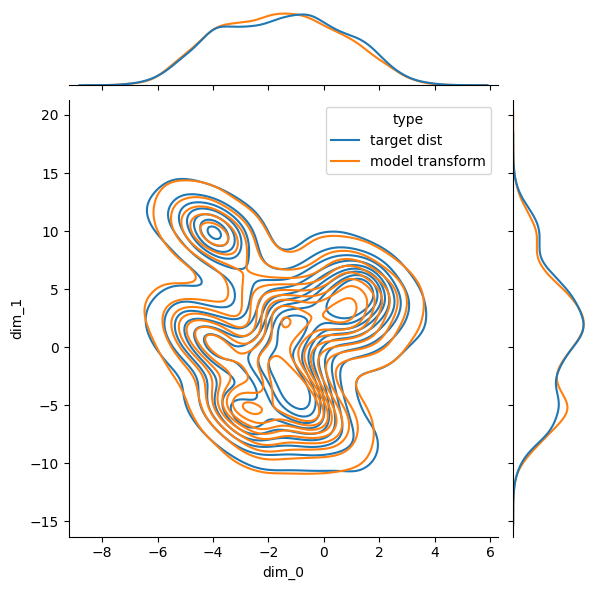

trail: 0 m step: 9 kl_test: 0.04504680633544922


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = (eta*(1.3**mirror_itr))
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )

